In [3]:
#def flat_list(inlist):
#  return [item for sublist in inlist for item in sublist]

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import subprocess
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import uproot
from scipy import stats
import re
import glob
import sys
import lmfit
from lmfit.models import LinearModel
import hist
import mplhep as hep
import awkward as ak
from numpy.core.function_base import linspace
import uncertainties.unumpy as unumpy
import dask as dd

hep.style.use('ATLAS')  # or ATLAS/LHCb2
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
plt.rcParams.update({'figure.max_open_warning': 0})
BAD_RUNS=[]
BAD_RUNS=[42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66, 67, 68, 69, 80, 83, 87, 88, 89, 91, 96, 101, 105, 110, 115, 1027, 1066, 1084, 1134, 1173]
#FEBID=[22, 25, 17, 14, 1, 20]
FEBID=[25, 17]
INPUT_FILELIST=['rec.mu2e.CRV_wideband_cosmics.crvaging-001-v5.txt', 'rec.mu2e.CRV_wideband_cosmics.crvaging-007-v5.txt']
#INPUT_FILELIST=['rec.mu2e.CRV_wideband_cosmics.crvaging-007-v5.txt']

In [2]:
BAD_RUNS_STRLIST = []
for ele in BAD_RUNS:
    ele_ = str(ele).zfill(6)
    BAD_RUNS_STRLIST.append(ele_)

In [3]:
INPUT_FILELIST

['rec.mu2e.CRV_wideband_cosmics.crvaging-001-v5.txt',
 'rec.mu2e.CRV_wideband_cosmics.crvaging-007-v5.txt']

In [4]:
file_list = []
for file in INPUT_FILELIST:
    with open(file) as run_list:    
        for root_file in run_list:
            root_file = 'root://fndca1.fnal.gov'+root_file[:5]+'/fnal.gov/usr/'+root_file[6:-1]            
            if any(ele in root_file for ele in BAD_RUNS_STRLIST):
                continue
#            print(root_file)
            file_list.append(root_file)

In [5]:
file_list_ = ["{}{}".format(i,":run") for i in file_list[0:25]]
#dd_run = uproot.dask(file_list_, xrootdsource={"timeout": 360, "num_workers": 2, "file_handler": 'MultithreadedFileSource'}, library='ak')
#dd_run = uproot.dask(file_list_, xrootdsource={"timeout": 360}, step_size='10 MB', library='ak', filter_branch=['*'])
#dd_run = uproot.dask(file_list_, xrootdsource={"timeout": 360}, step_size='1000 MB', library='np', filter_name=['spillTimestamp', 'temperature'])
#dd_run = uproot.dask(file_list_, xrootdsource={"timeout": 360}, step_size='0.01GB', library='np')
#dd_run = uproot.dask(file_list_, xrootdsource={"timeout": 360, "num_workers": 4, "file_handler": 'MultithreadedFileSource'}, step_size='4 GB', filter_name=['spillTimestamp', 'temperature'])
dd_run = uproot.dask(file_list_, xrootdsource={"timeout": 360}, step_size='4 GB', filter_name=['spillTimestamp', 'temperature'])

In [6]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(processes=False, n_workers=4, threads_per_worker=1, memory_limit='4GiB')
#cluster = LocalCluster(processes=False, threads_per_worker=8)
cluster = LocalCluster(n_workers=4, threads_per_worker=8)
#cluster.scale(2)  # Sets the number of workers to 2
client = Client(cluster)

#from dask_jobqueue import HTCondorCluster
#cluster = HTCondorCluster(cores=2, memory="2GB", disk="1 GB")
#cluster.scale(10)
#client = Client(cluster)

#client.restart()

In [ ]:
x=dd_run['spillTimestamp'].compute()
y=dd_run['temperature'].compute()[:,0,0]

cut=(x>0)
x=x[cut]
y=y[cut]

plt.plot(x.to_numpy().astype('datetime64[s]'),y,'k.', markersize=0.01);

In [16]:
file_list_ = ["{}{}".format(i,":runSummary") for i in file_list]
ar = uproot.concatenate(file_list_, xrootdsource={"timeout": 360})
file_list_ = ["{}{}".format(i,":spills") for i in file_list]
arSpills = uproot.concatenate(file_list_, xrootdsource={"timeout": 360})
#df = ak.to_pandas(ar) # entry - event, subentry - FEB, subsubentry - AFE
#dfSpills = ak.to_pandas(arSpills) # 

In [ ]:
file_list_ = ["{}{}".format(i,":run") for i in file_list]
arRun = uproot.concatenate(file_list_, xrootdsource={"timeout": 360}, filter_name=['spillTimestamp', 'temperature'], library='ak')

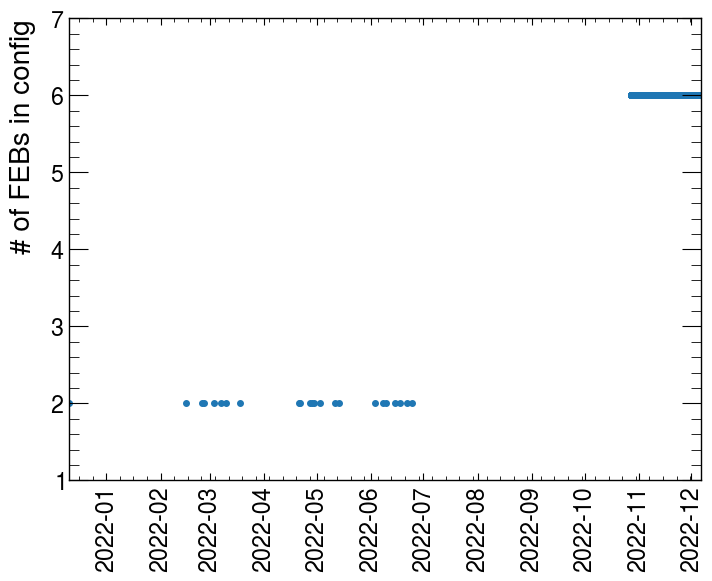

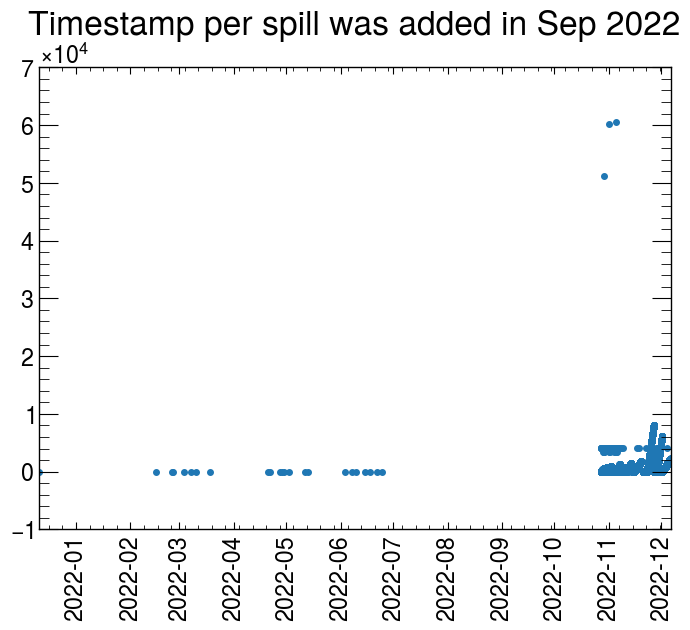

In [9]:
cut = (arSpills['spill_timestamp'] > 0)
x=arSpills["spill_timestamp", cut].to_numpy()
y=arSpills["spill_number_of_febs", cut].to_numpy()
    
plt.plot(x.astype('datetime64[s]'), y, '.')
plt.xticks(rotation = 90);
plt.ylabel('# of FEBs in config')

plt.figure()
y=arSpills["spill_num", cut].to_numpy()
plt.plot(x.astype('datetime64[s]'), y, '.')
plt.xticks(rotation = 90);
plt.title('Timestamp per spill was added in Sep 2022');

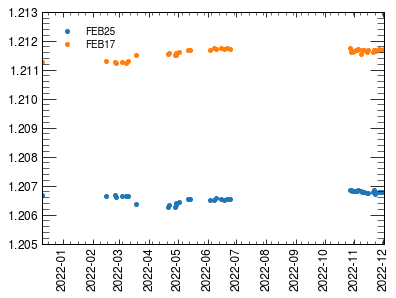

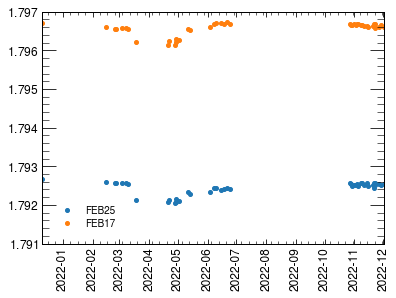

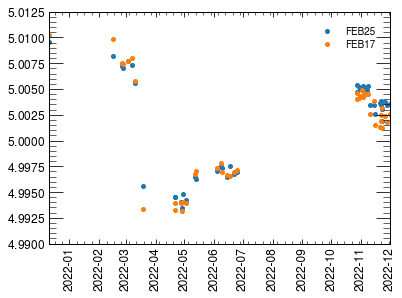

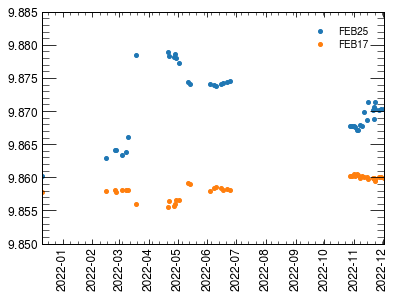

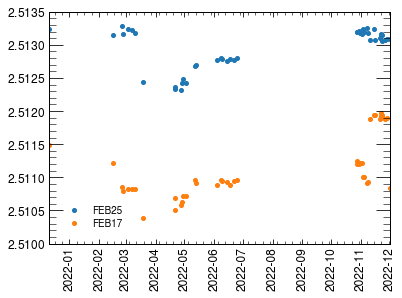

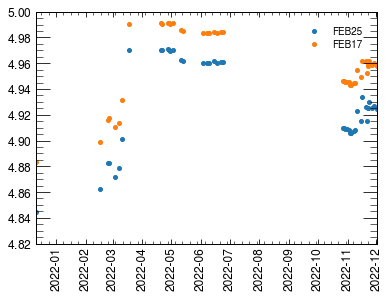

In [14]:
for volt in range(0,6):
    plt.figure()
    for feb in FEBID:
        x=df.query('subsubentry==%d & subrunNumber==0 & febID==%d'%(volt, feb))['timestamp'].to_numpy().astype('datetime64[s]')
        y=df.query('subsubentry==%d & subrunNumber==0 & febID==%d'%(volt, feb))['supplyMonitorsAvg'].to_numpy()
        plt.plot(x,y, '.', label='FEB%d'%feb)
    plt.legend()
    plt.xticks(rotation = 90);    

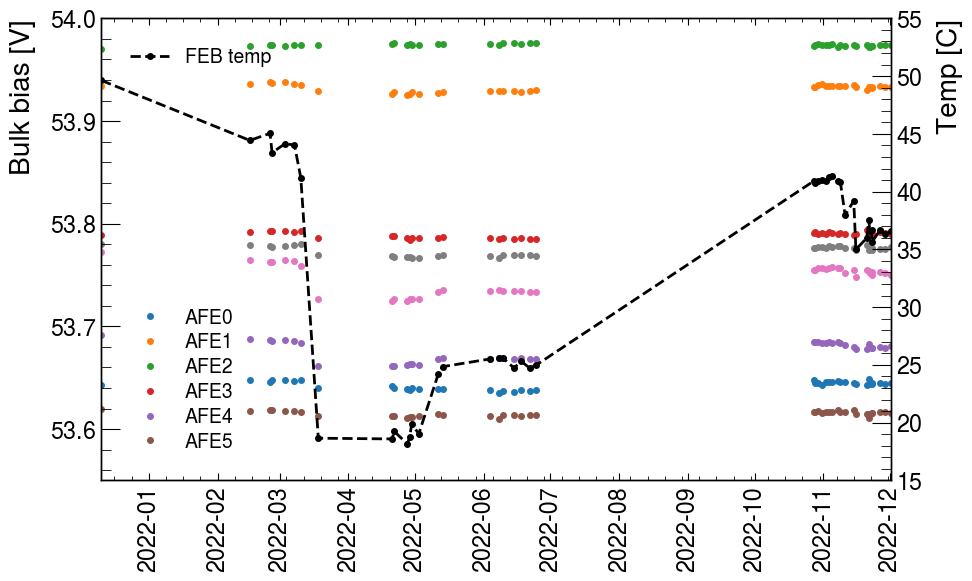

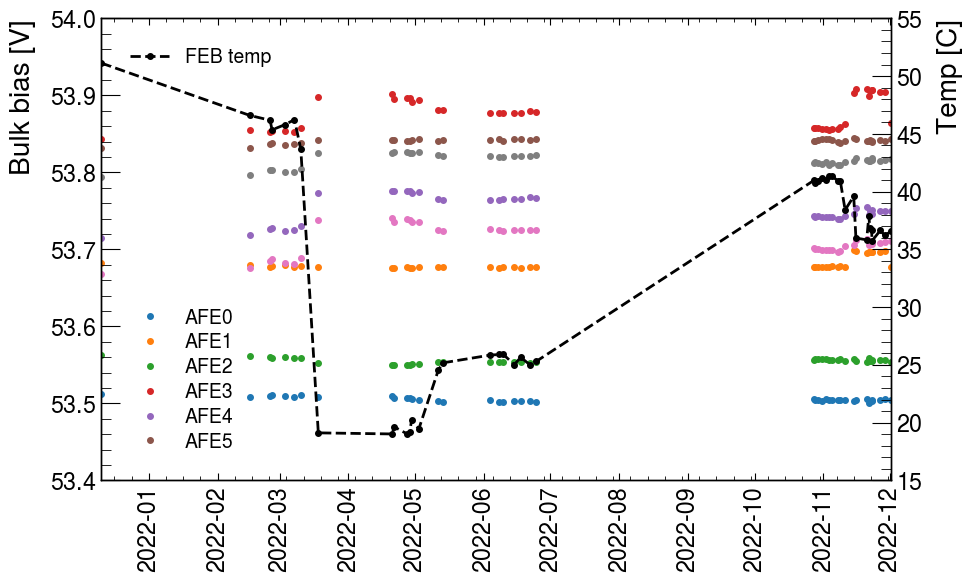

In [78]:
#for feb in FEBID:
for idx, feb in enumerate(FEBID):

    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.subplots_adjust(wspace=0.5)
    plt.xticks(rotation = 90);
    ax2 = ax1.twinx()
    
    cut = (ar['timestamp'] > 0)
    x=ar['timestamp', cut].to_numpy().astype('datetime64[s]')
    y=ar['biasVoltagesAvg', cut][:,idx,:].to_numpy()
    lineObjects = ax1.plot(x,y, '.', label='afe%d'%afe)    
    ax1.legend([f'AFE{i}' for i in range(0, 6)], loc='lower left')

    y=ar['febTemperaturesAvg', cut][:,idx].to_numpy()
    ax2.plot(x,y, 'k.--', label='afe%d'%afe)
    ax1.set_ylabel('Bulk bias [V]')
    ax2.set_ylabel('Temp [C]')
    ax2.legend(['FEB temp'], loc='upper left')
    plt.xticks(rotation = 90);
#    plt.set_title('FEB%d'%feb)
#    plt.set_ylim(df['biasVoltagesAvg'].min()-0.1, df['biasVoltagesAvg'].max()+0.1)
#    plt.ylabel('biasVoltagesAvg [V]')
#    plt.set_ylim(53.49, 54.)
#    plt.legend()

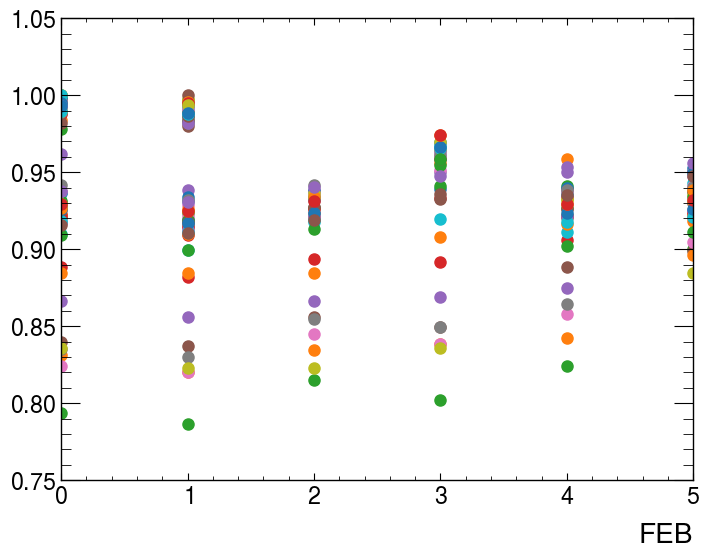

In [51]:
list_ = (ar['spillsRecorded']/ar['febSpills']).to_list()
for l in list_:
    plt.plot(l, 'o')
plt.xlabel('FEB');

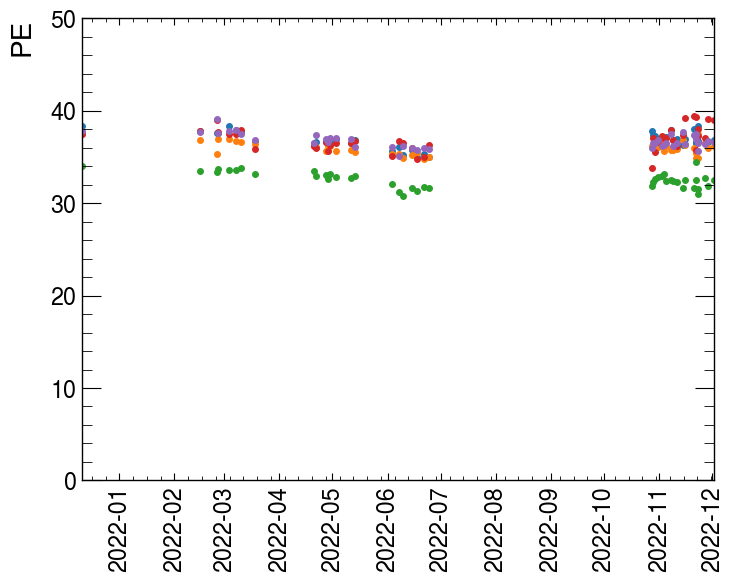

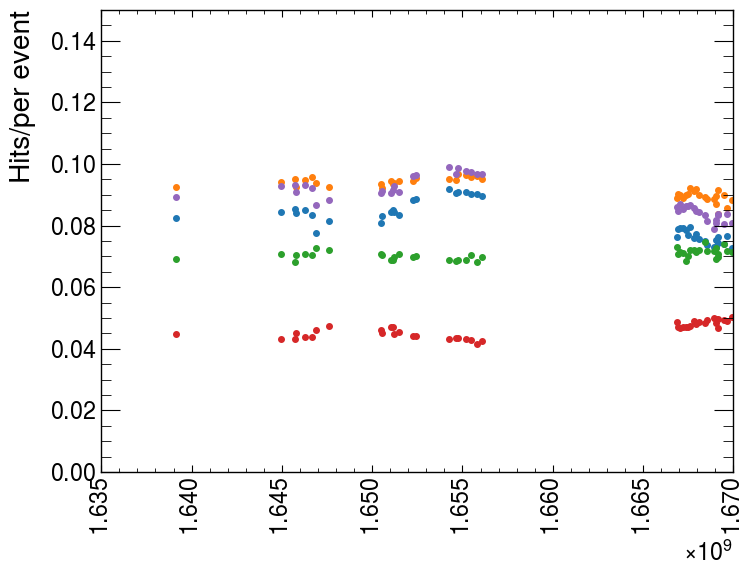

In [52]:
for chan in [0,8,16,24,32]:
    cut = (ar['timestamp'] >0)
    x=ar['timestamp', cut]
    y=ar['PEsTemperatureCorrected', cut][:,1,chan]
    plt.plot(ar['timestamp', cut].to_numpy().astype('datetime64[s]'), y, '.')
    plt.xticks(rotation = 90);
    plt.ylim(0, 50);
    plt.ylabel('PE')

plt.figure()
for chan in [0,8,16,24,32]:
    cut = (ar['timestamp'] >0)
    x=ar['timestamp', cut]
    y=ar['signalsTemperatureCorrected', cut][:,1,chan].to_numpy()/ar['eventsRecorded', cut][:]
    plt.plot(x, y, '.')
    plt.xticks(rotation = 90);
    plt.ylim(0,0.15)
    plt.ylabel('Hits/per event')


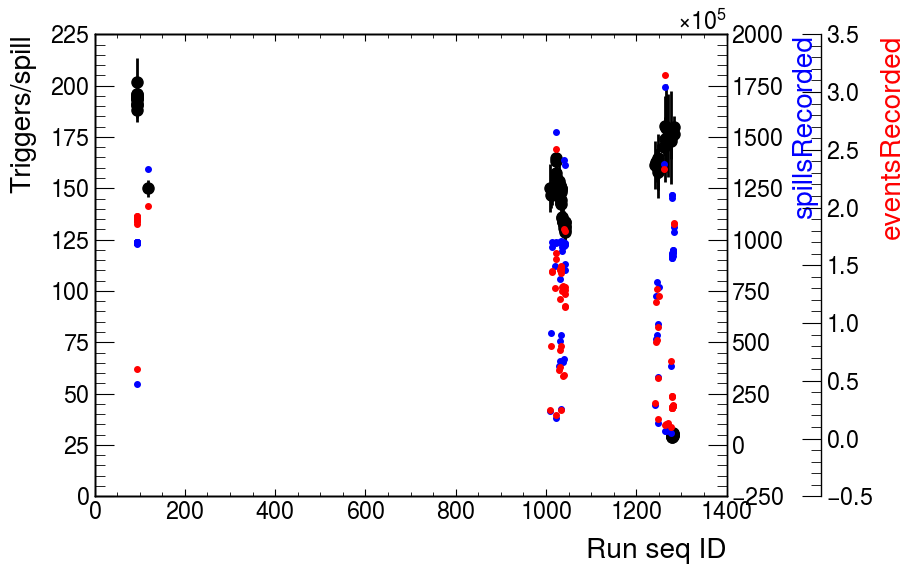

In [53]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.subplots_adjust(wspace=0.5)

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.15))

x=len(ar['eventsRecorded'][:].to_numpy())

y1=ar['eventsRecorded'][:].to_numpy()
y1_std=np.sqrt(y1)
y1=unumpy.uarray(y1, y1_std) 

y2=ar['spillsRecorded'][:].to_numpy()
y2_std=np.sqrt(y2)
y2=unumpy.uarray(y2, y2_std) 

#x=linspace(0,x-1,x)
x=ar['runNumber'][:].to_numpy()

y=y1/y2

ax1.errorbar(x, unumpy.nominal_values(y), yerr=unumpy.std_devs(y), fmt="o", color="k")
ax2.plot(x,ar['spillsRecorded'][:].to_numpy(), '.b')
ax3.plot(x,ar['eventsRecorded'][:].to_numpy(), '.r')

ax1.set_ylabel('Triggers/spill')
ax2.set_ylabel('spillsRecorded', color='b', labelpad=5)
ax3.set_ylabel('eventsRecorded', color='r', labelpad=5)
ax1.set_xlabel('Run seq ID');

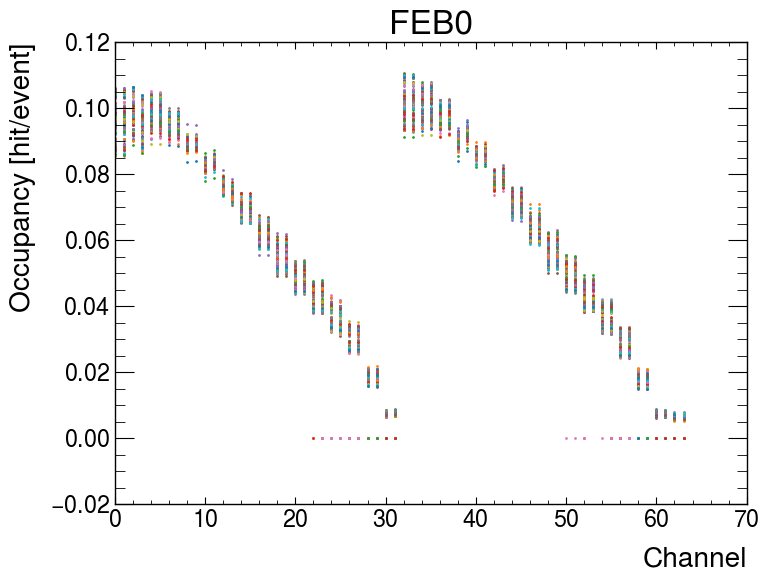

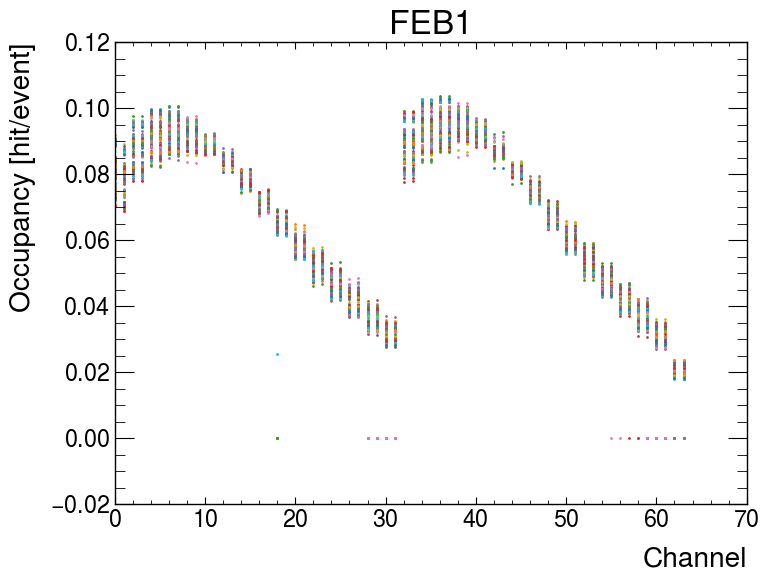

In [54]:
from numpy.core.function_base import linspace
for feb in range(0, 2):
  plt.figure()
  for run in range(0,ak.count(ar['eventsRecorded'])):
    x=linspace(0,63,64)
#    y=ar['signalsTemperatureCorrected'][run,feb,:].to_numpy()/ar['spillsRecorded'][run]
    y=ar['signalsTemperatureCorrected'][run,feb,:].to_numpy()/ar['eventsRecorded'][run]
    plt.plot(x,y, '.', markersize=2, label='Run: %d'%run);
    plt.ylabel('Occupancy [hit/event]')
    plt.xlabel('Channel')
#    plt.ylim(0,0.1)
    plt.title('FEB%d'%feb)
#    plt.legend(prop={'size': 6})

<Figure size 800x600 with 0 Axes>

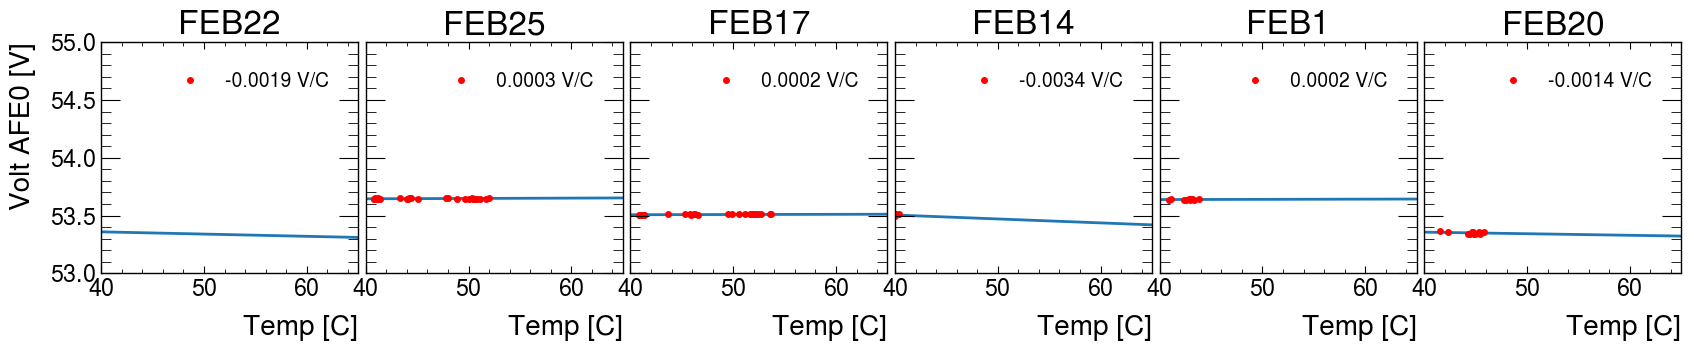

<Figure size 800x600 with 0 Axes>

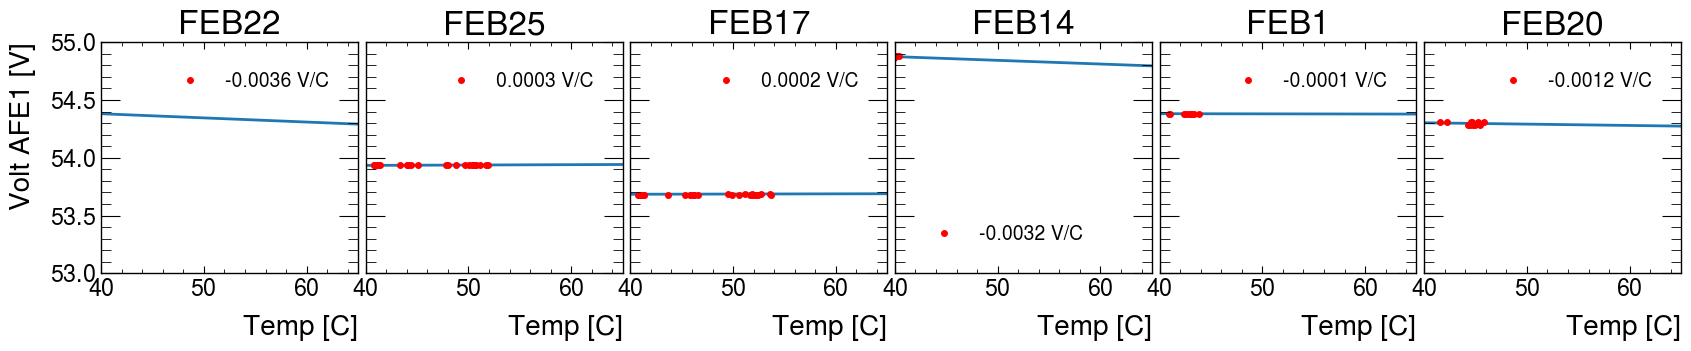

<Figure size 800x600 with 0 Axes>

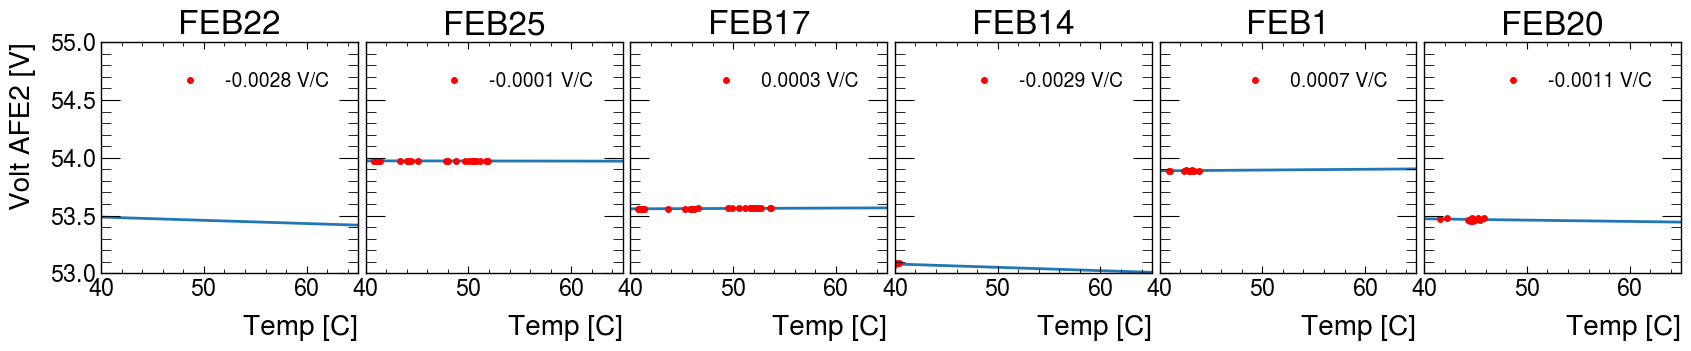

<Figure size 800x600 with 0 Axes>

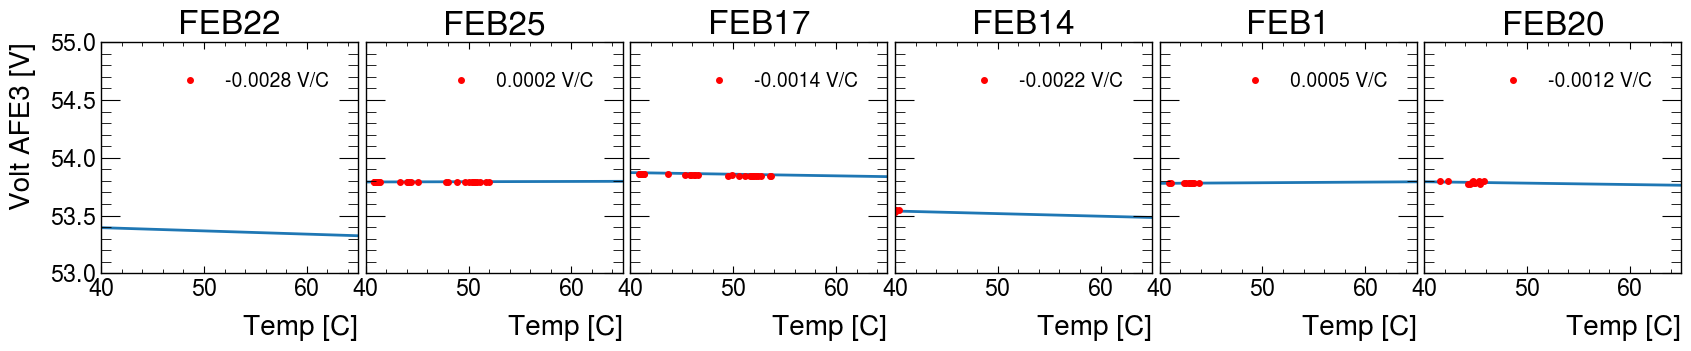

<Figure size 800x600 with 0 Axes>

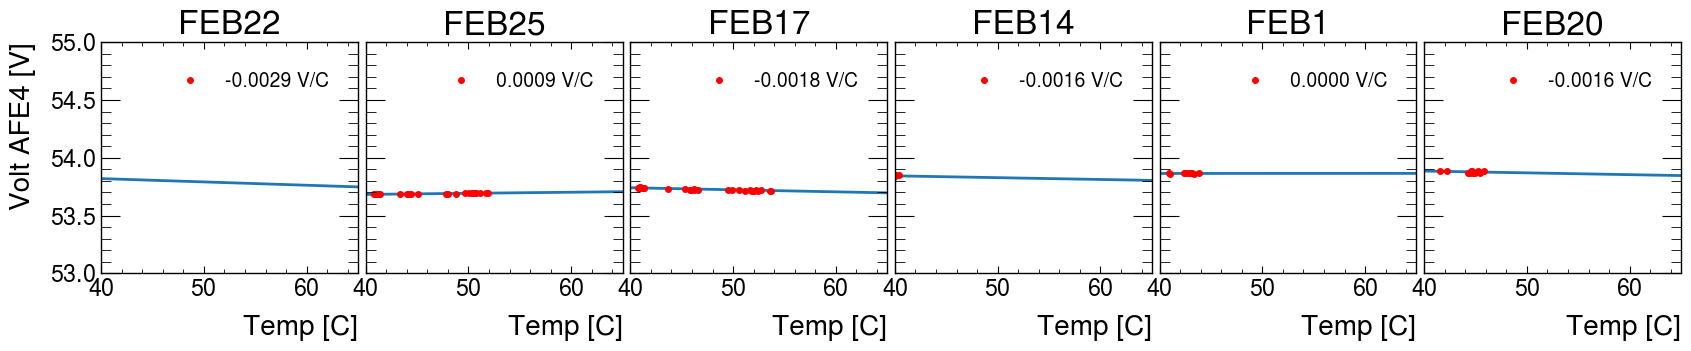

<Figure size 800x600 with 0 Axes>

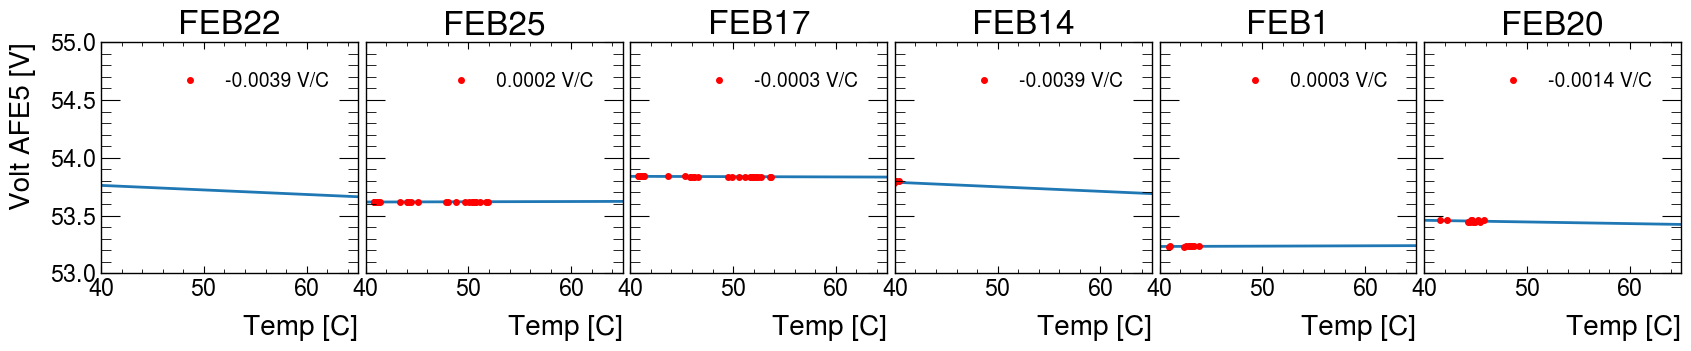

<Figure size 800x600 with 0 Axes>

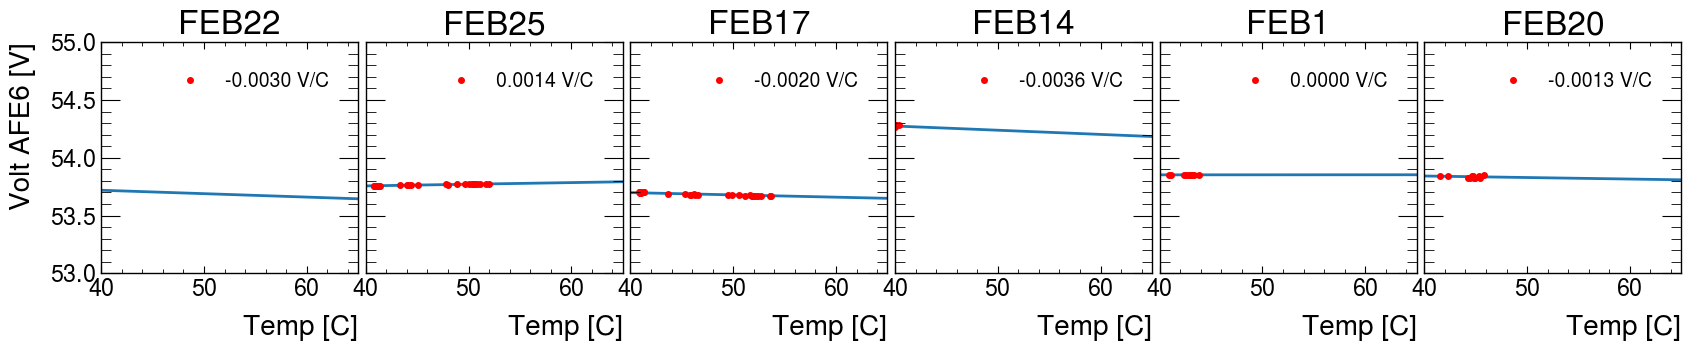

<Figure size 800x600 with 0 Axes>

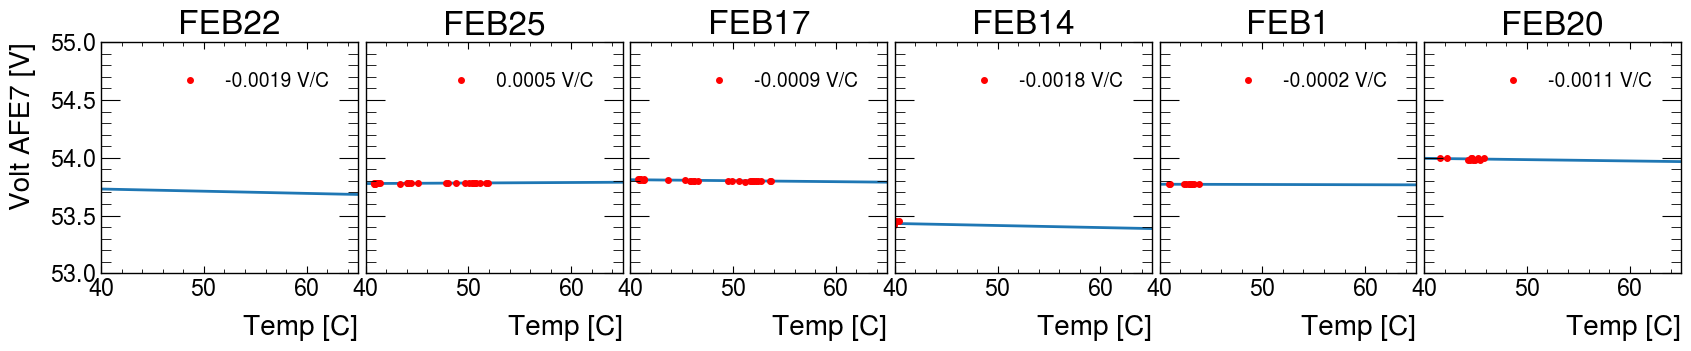

In [55]:
for i in range(0,8): # Loop thgough AFEs

  plt.figure()
  fig, ax1 = plt.subplots(nrows=1, ncols=6, figsize=(20, 3), sharey='row')
  plt.subplots_adjust(wspace=0.03)
  ax1[0].set_ylabel('Volt AFE%d [V]'%(i))


  for idx, feb in enumerate([22, 25, 17, 14, 1, 20]):
#  for idx, feb in enumerate(FEBID):

    cut = (ar['febID'] == feb)
    x=ar["febTemperaturesAvg", cut]
    y=ar["biasVoltagesAvg", cut]

    x=x[ak.num(x) > 0, 0].to_numpy()    
    y=y[ak.num(y) > 0, 0].to_numpy()[:,i]
    
    linmodel = np.poly1d(np.polyfit(x, y, 1))
    xline = np.linspace(40, 65, 100)
    ax1[idx].plot(xline, linmodel(xline))
    ax1[idx].plot(x,y,'r.', label='%.4f V/C'%linmodel.coeffs[0])

    ax1[idx].set_xlabel('Temp [C]')
    
    ax1[idx].set_xlim(40,65)
    ax1[idx].set_ylim(53,55)
    ax1[idx].legend()
    ax1[idx].set_title('FEB%d'%feb)

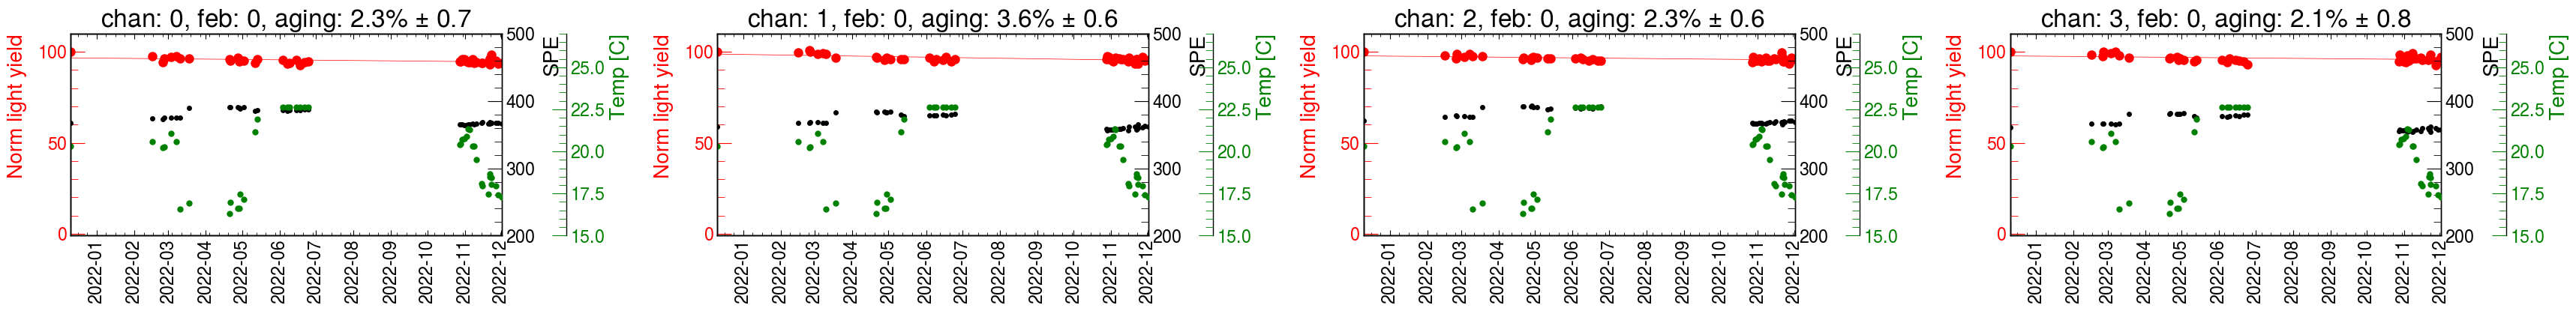

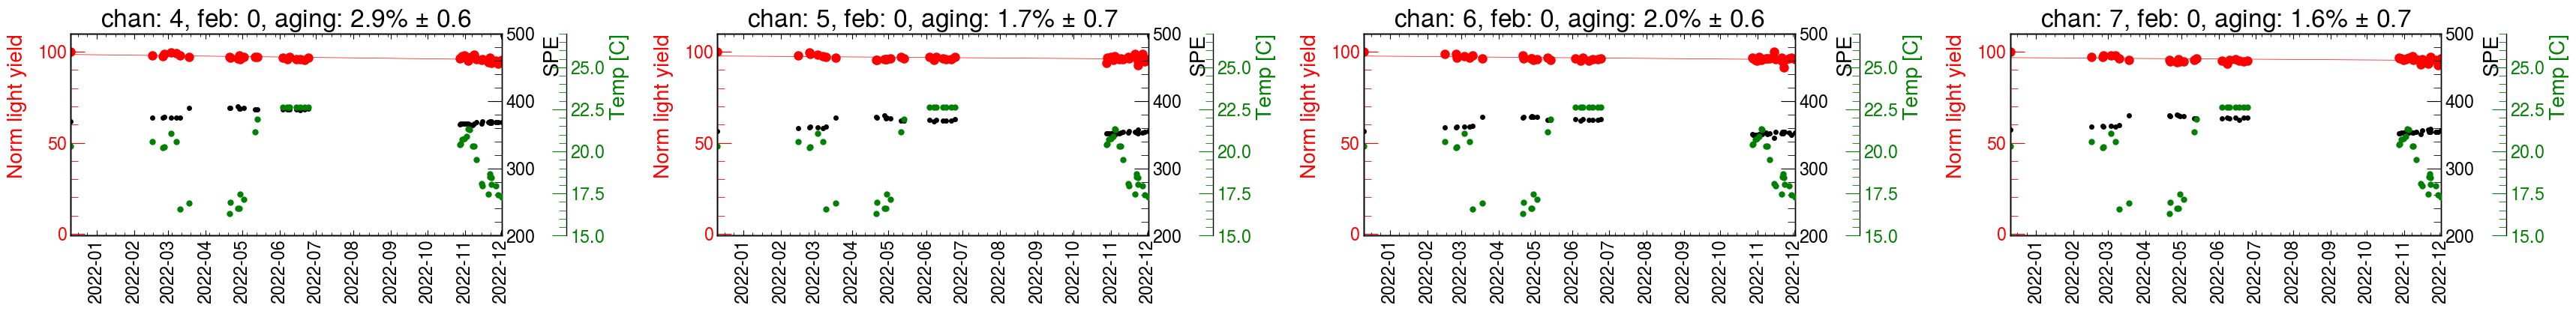

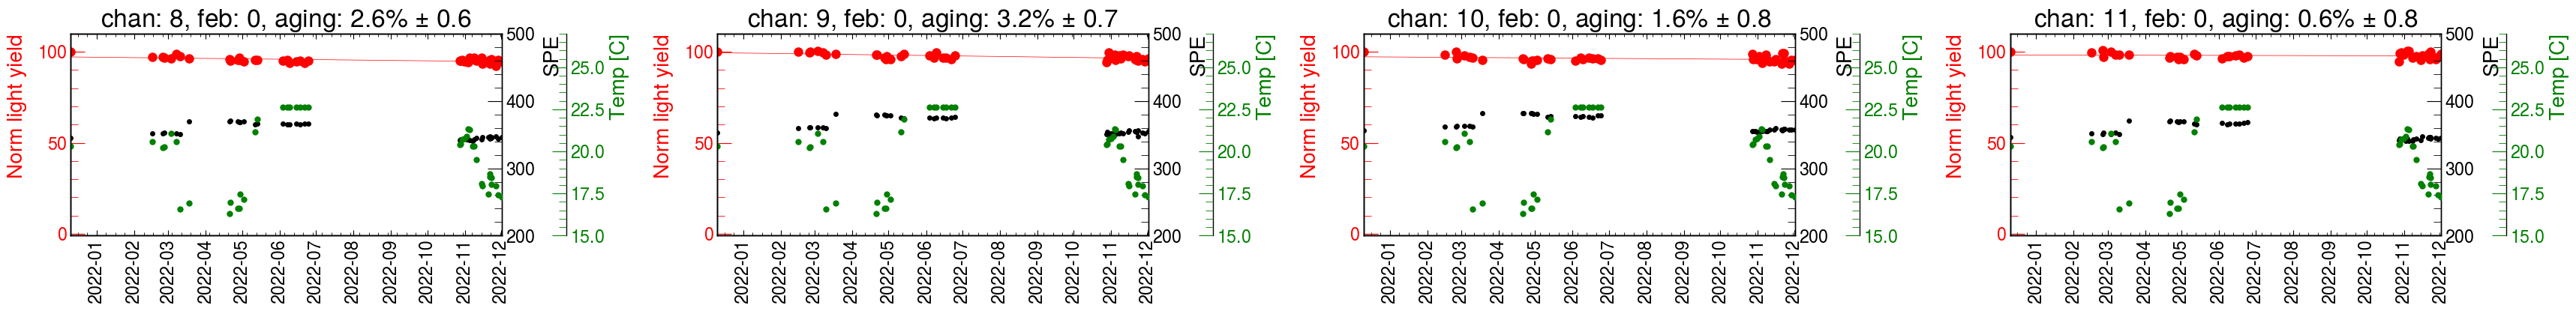

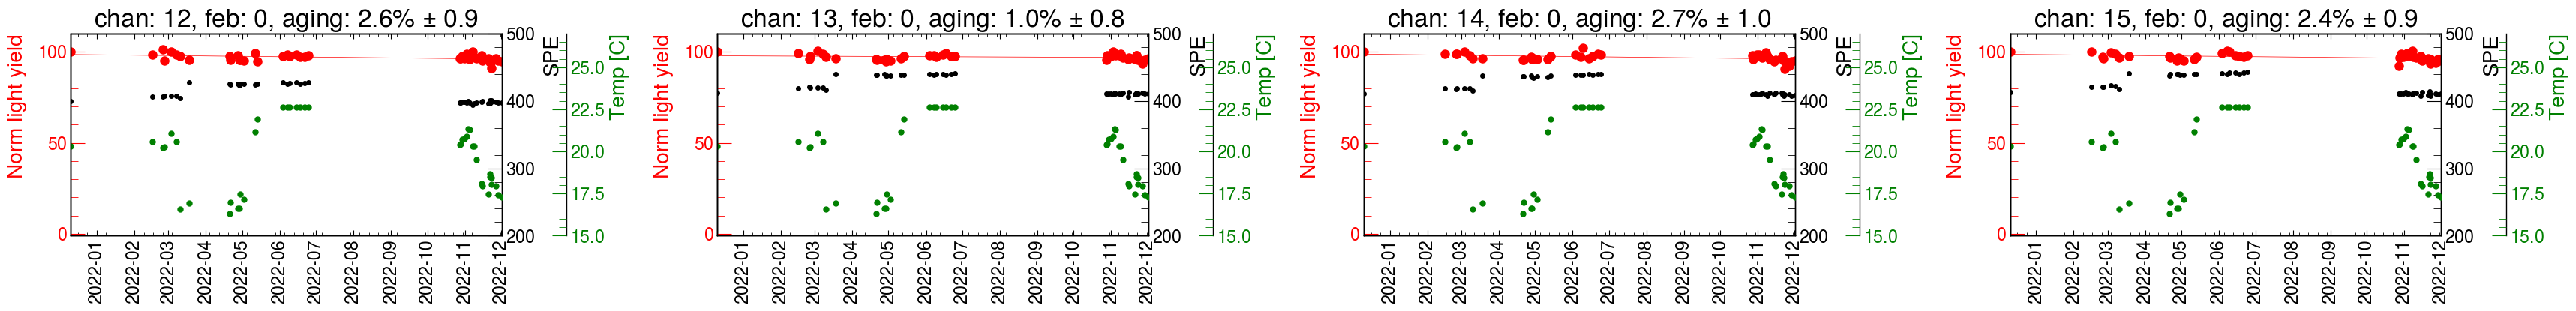

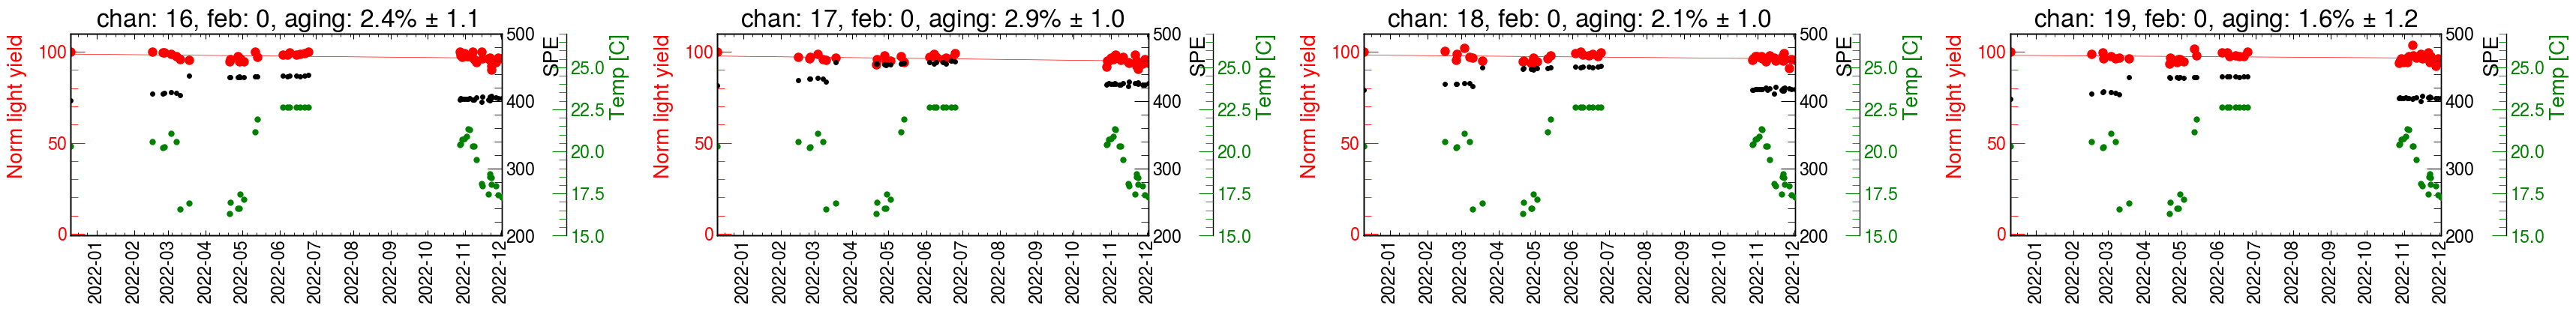

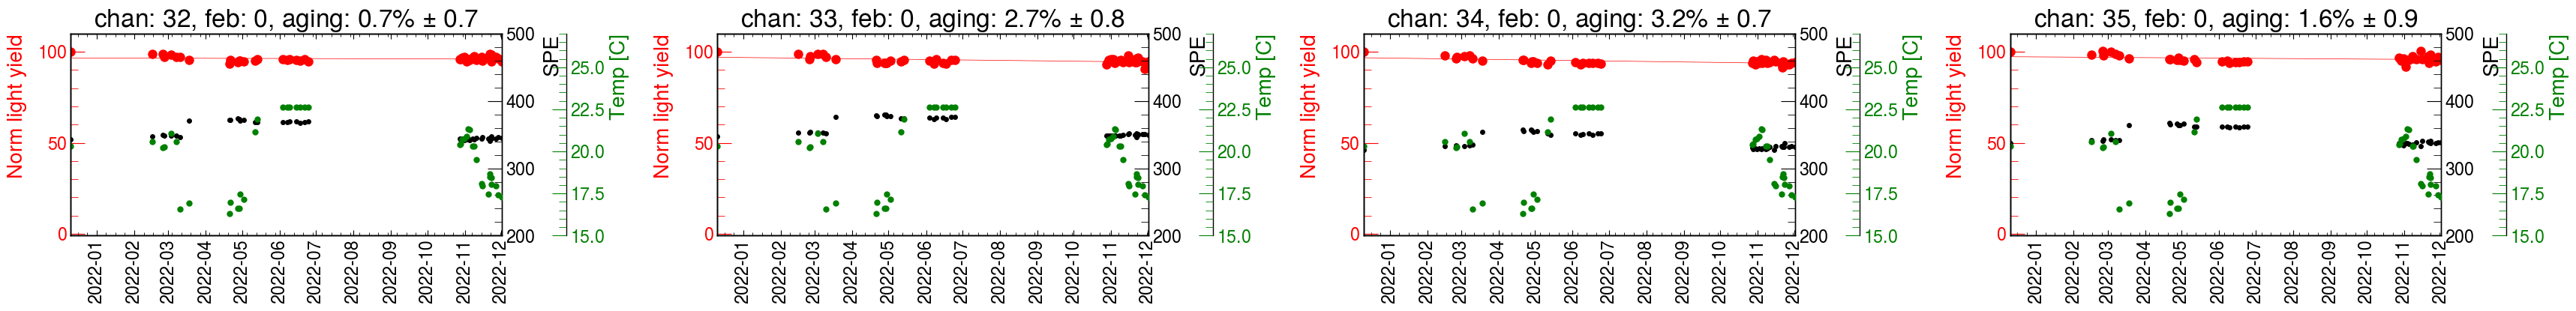

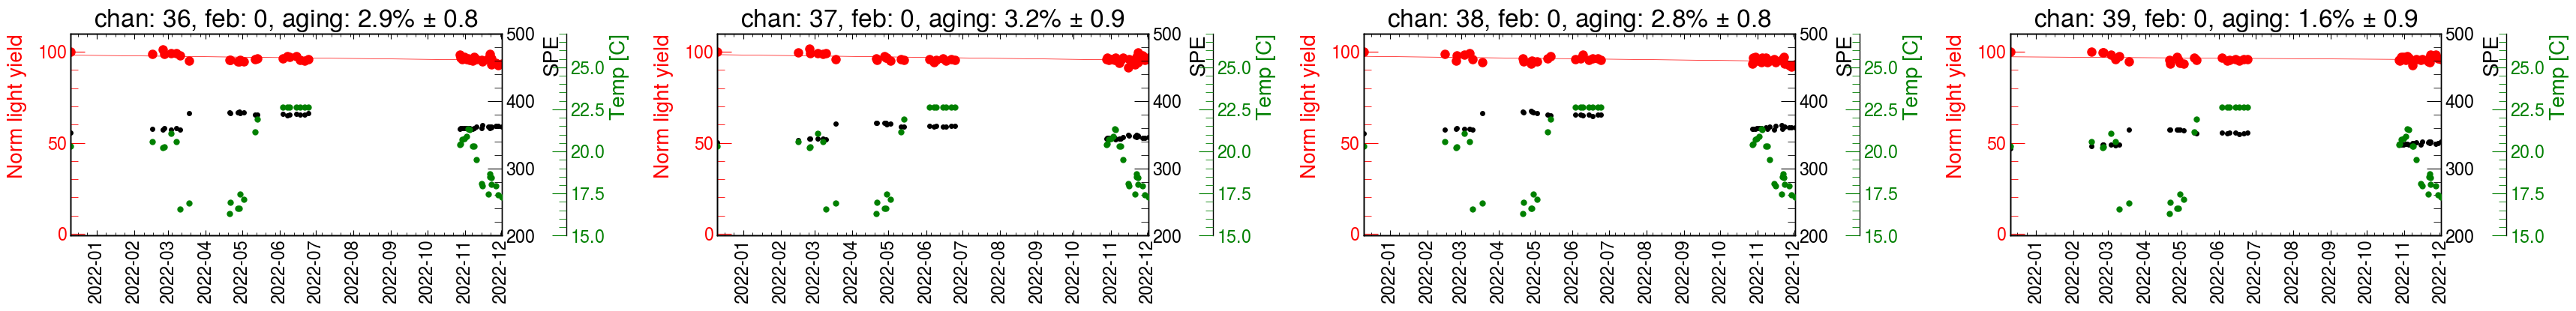

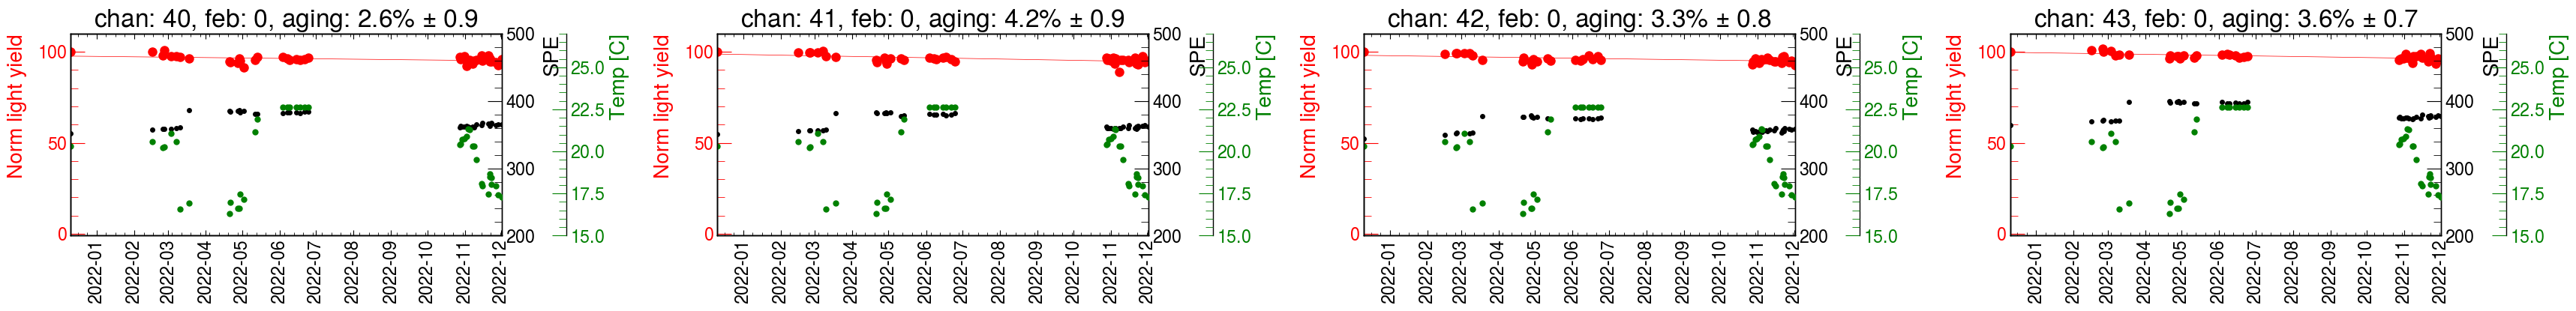

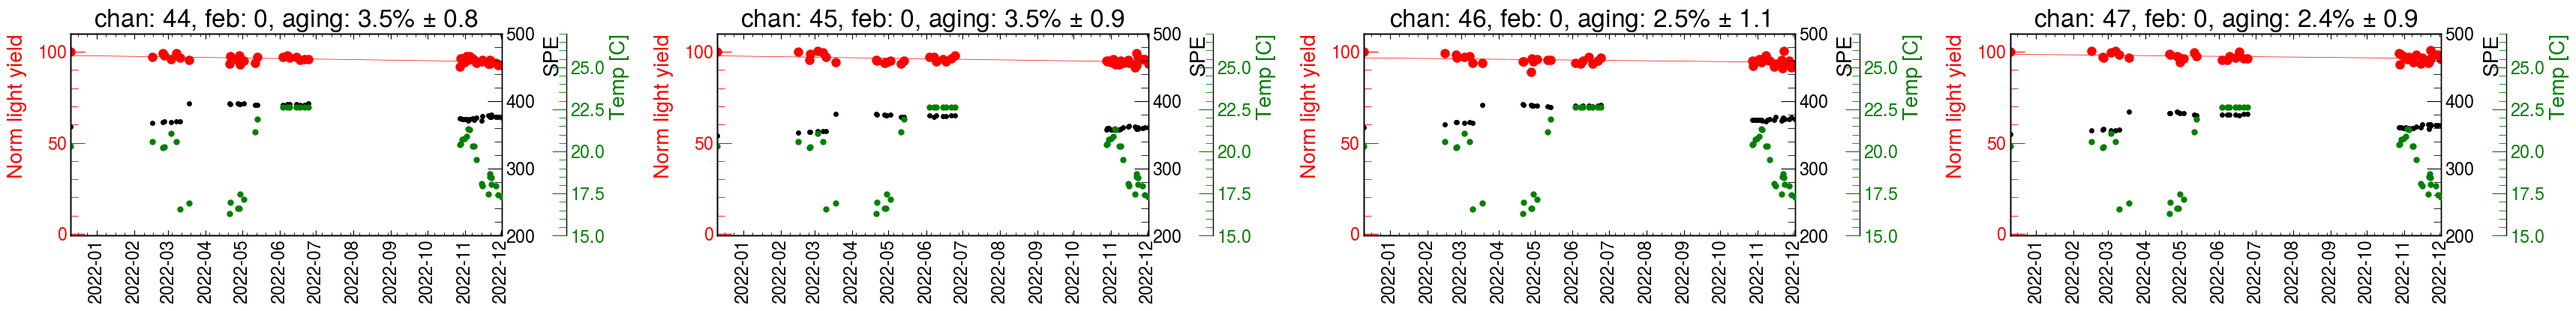

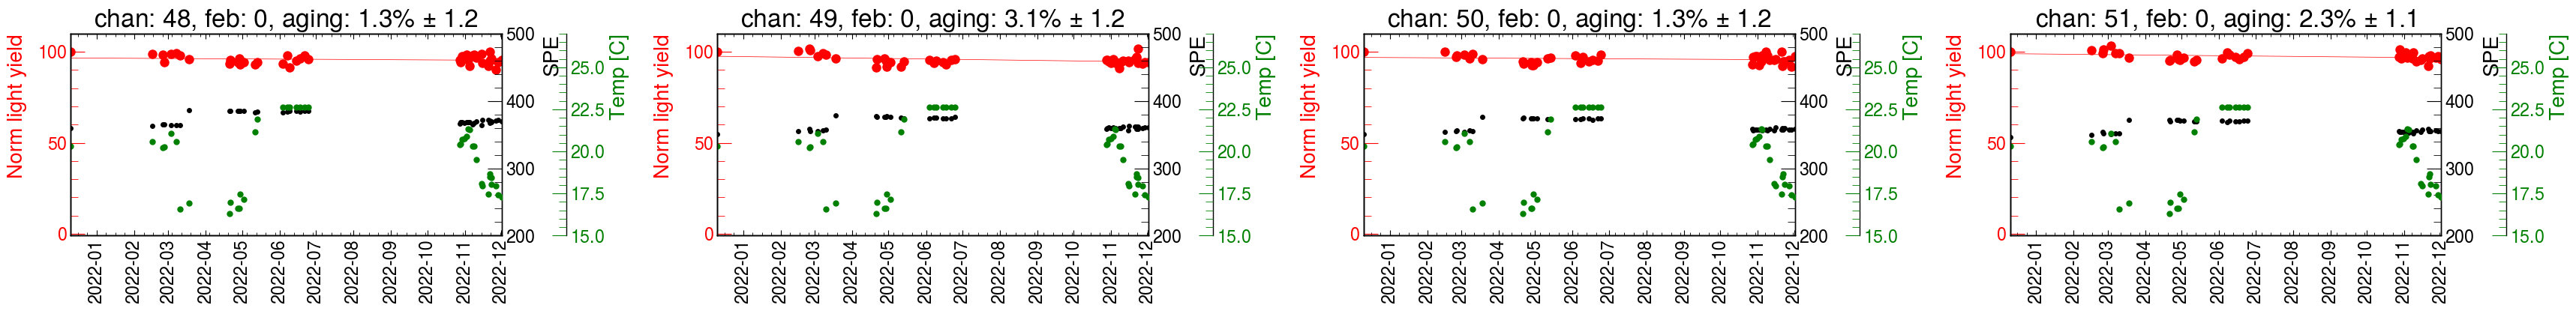

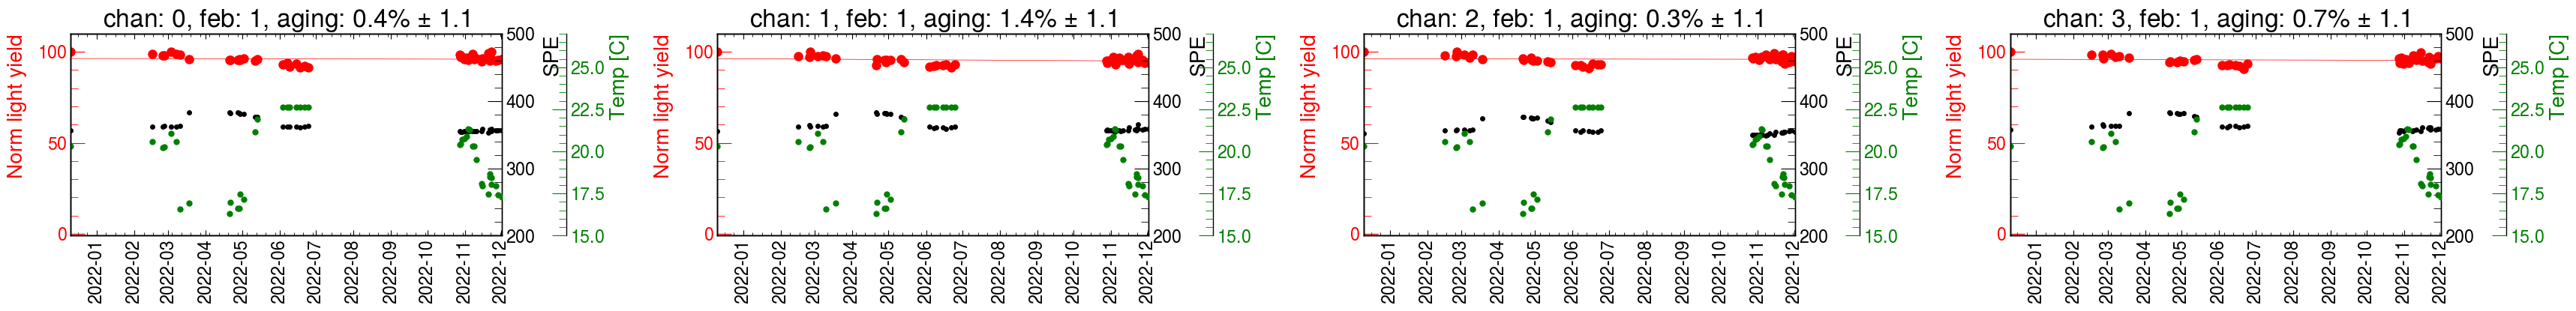

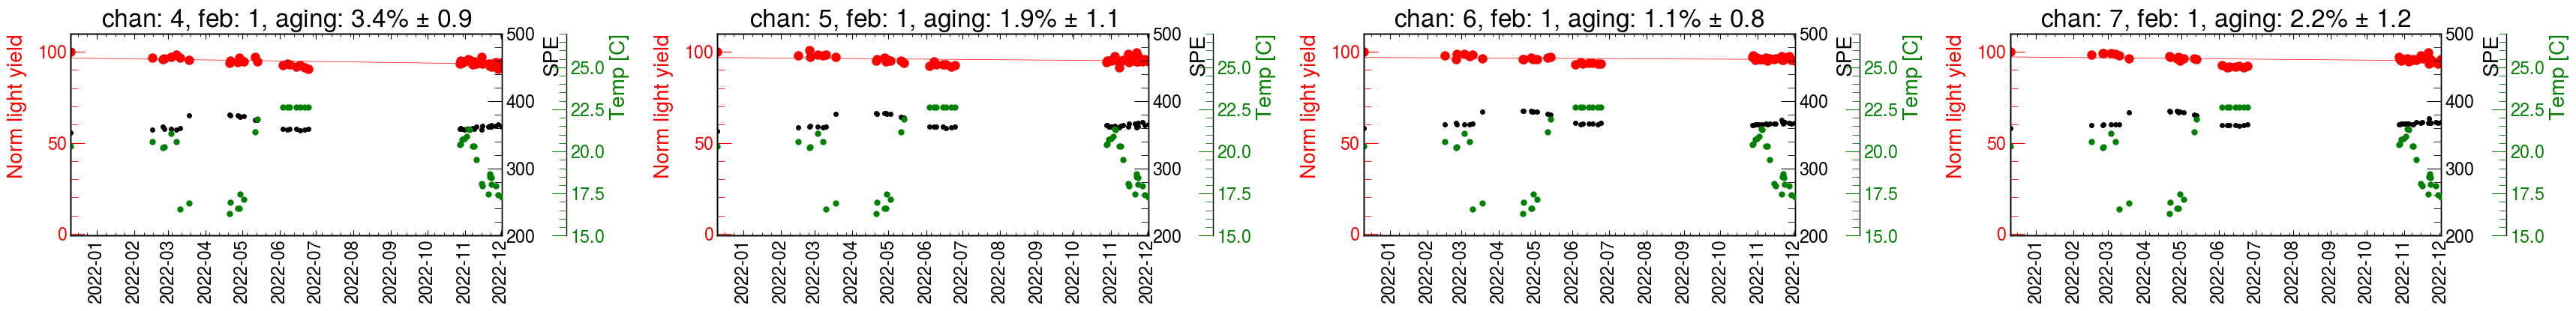

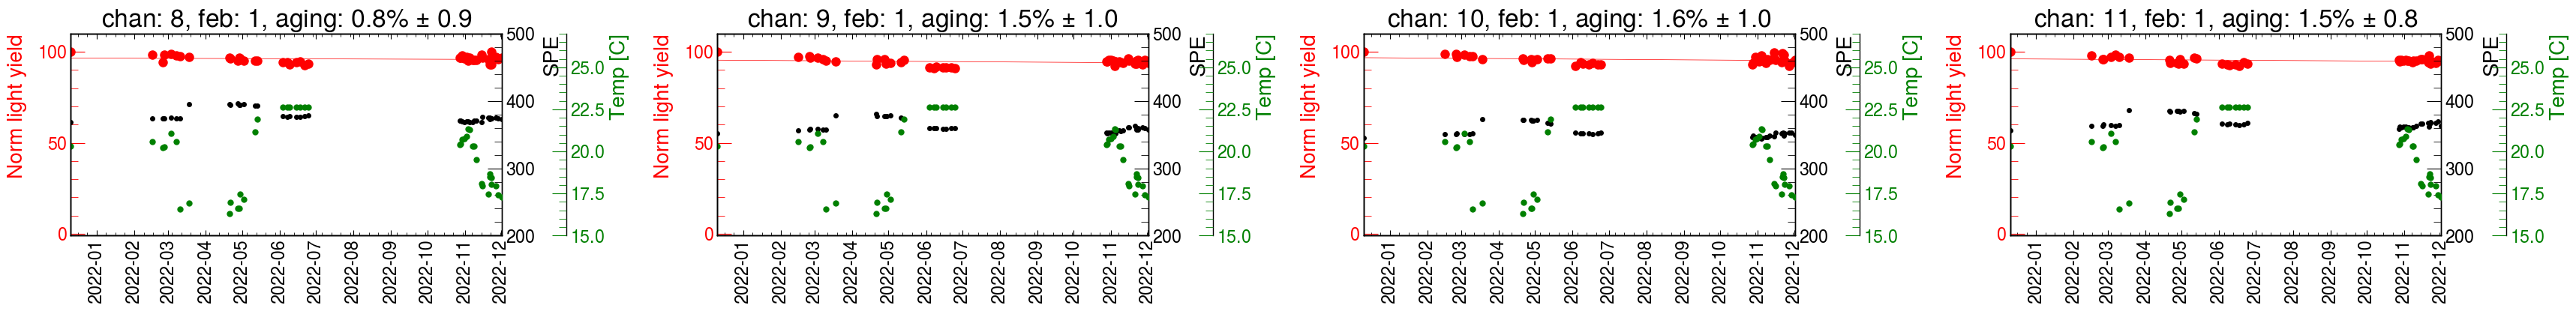

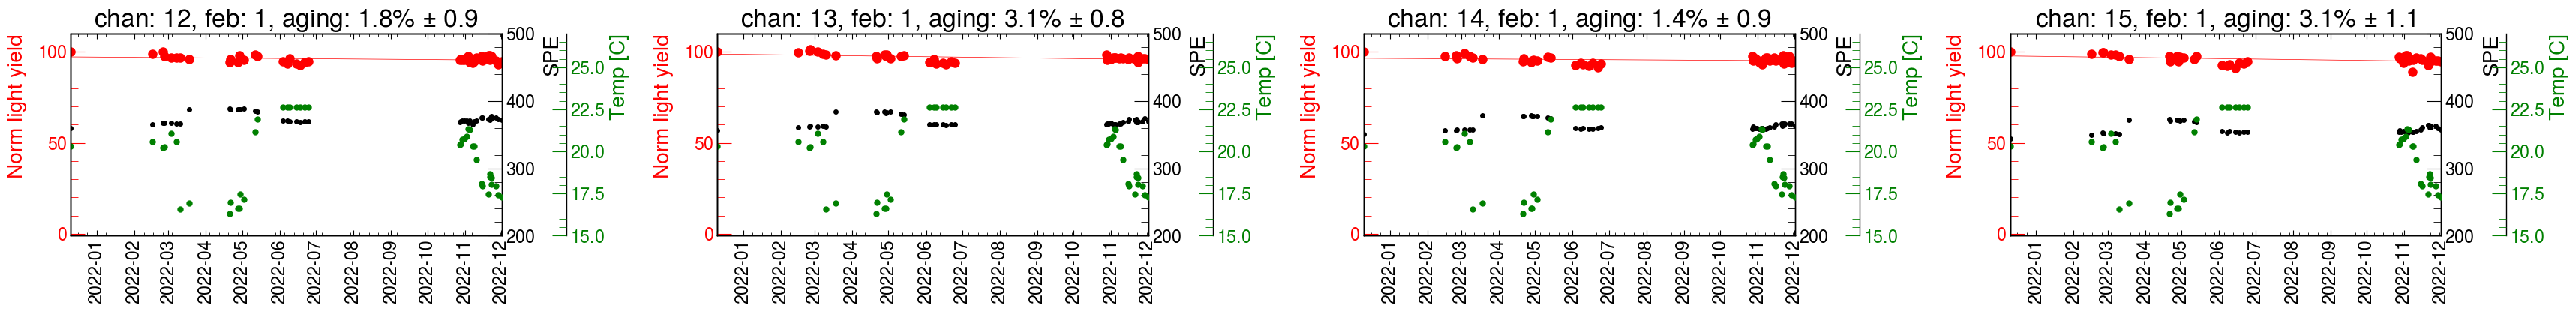

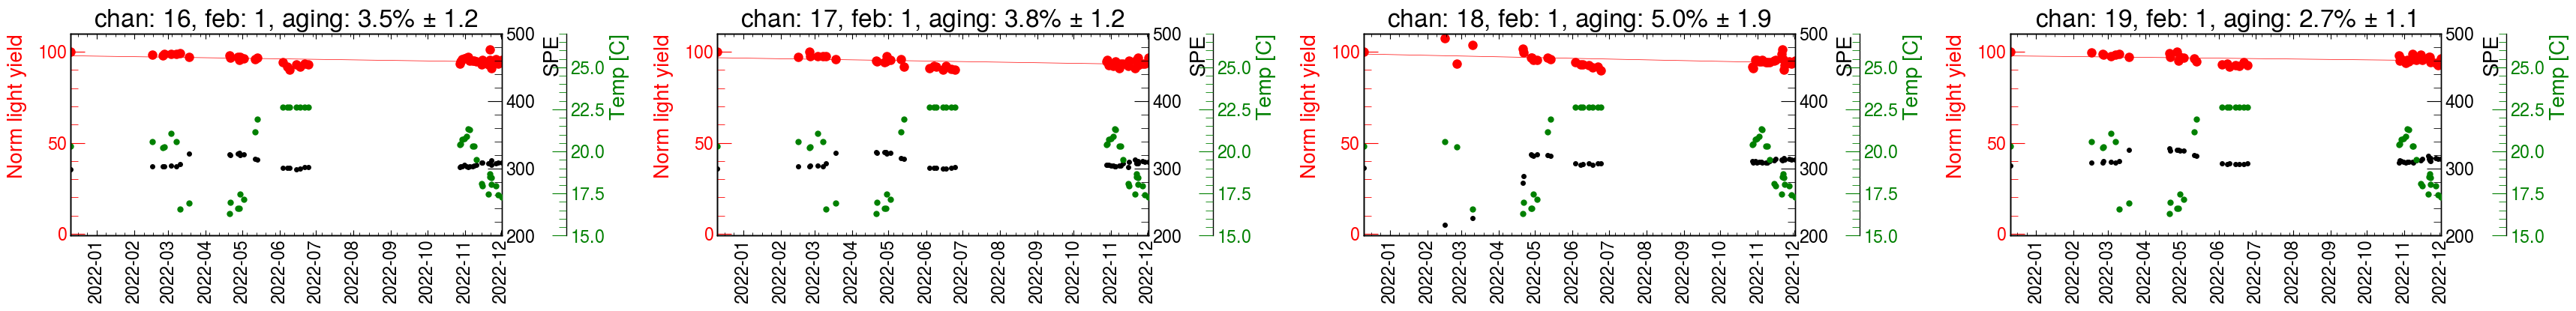

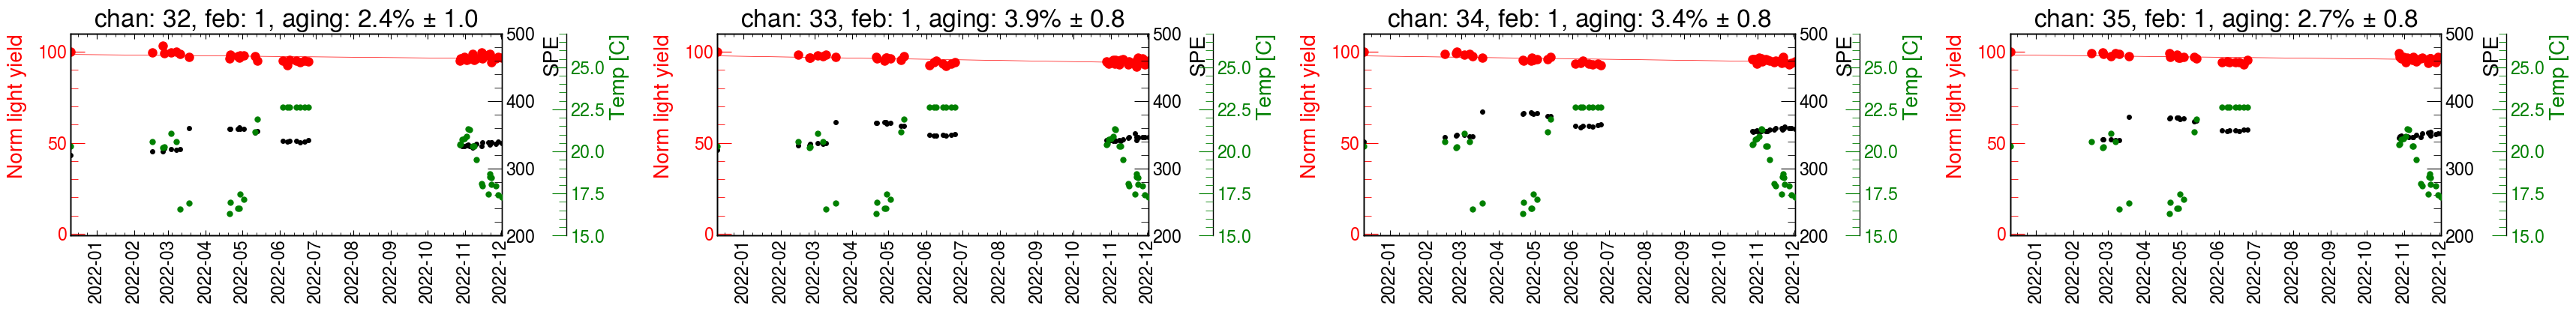

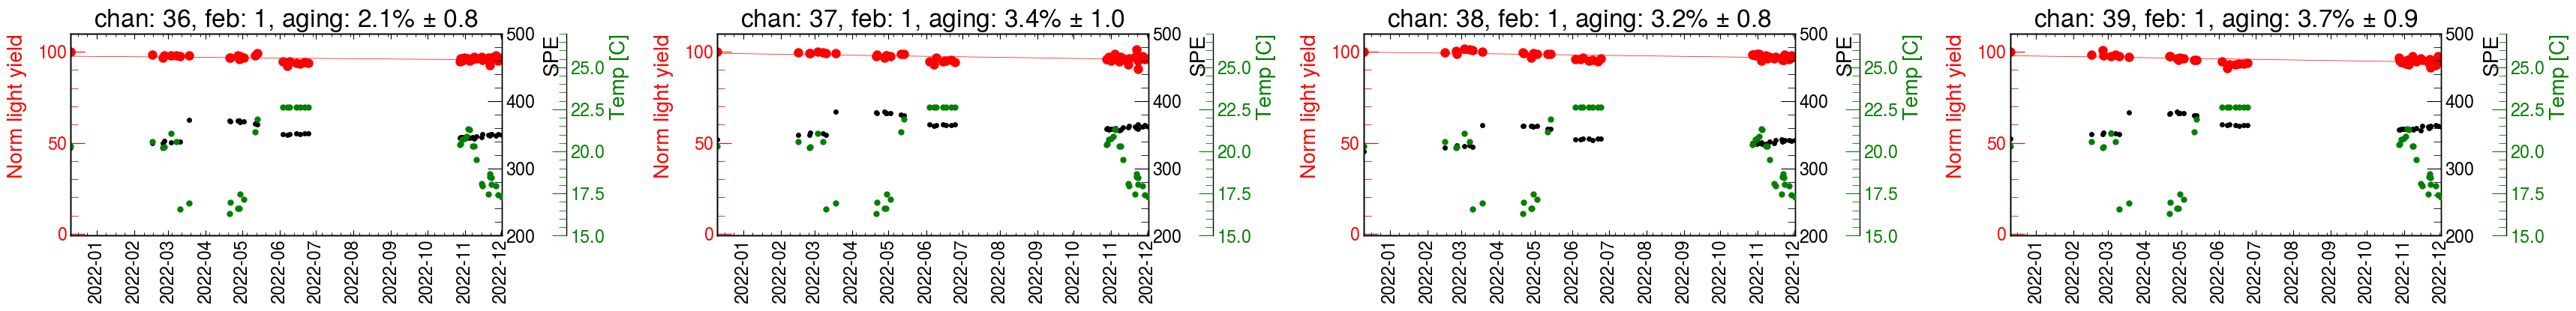

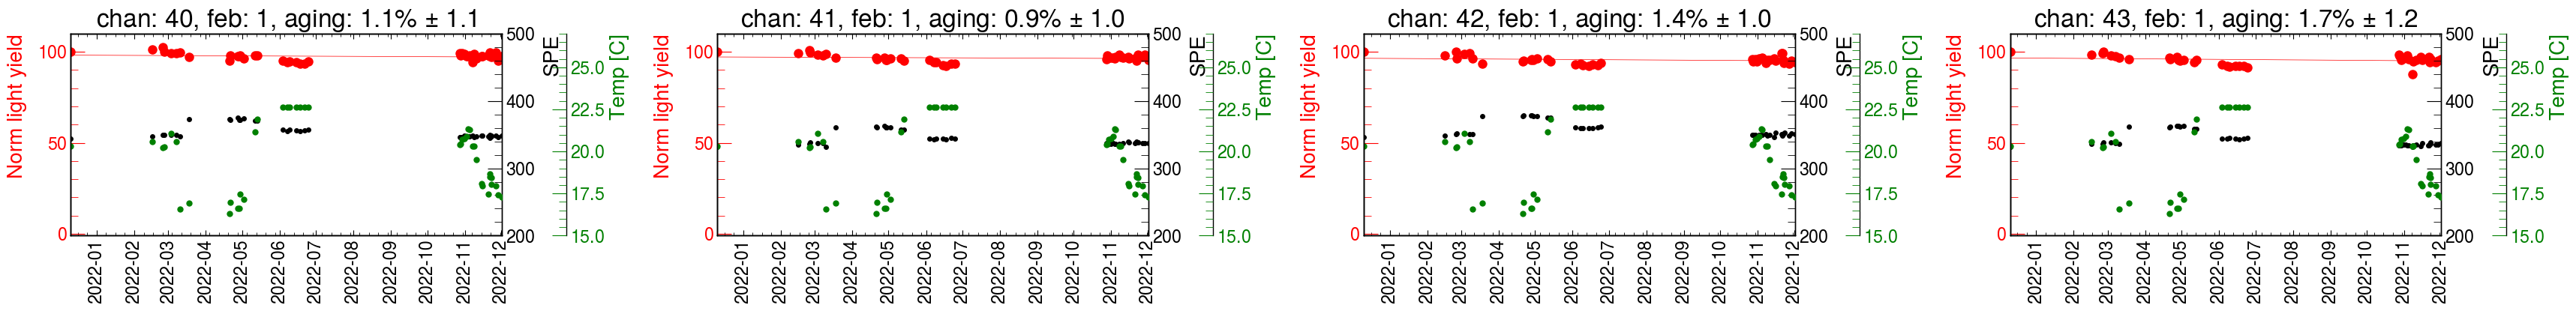

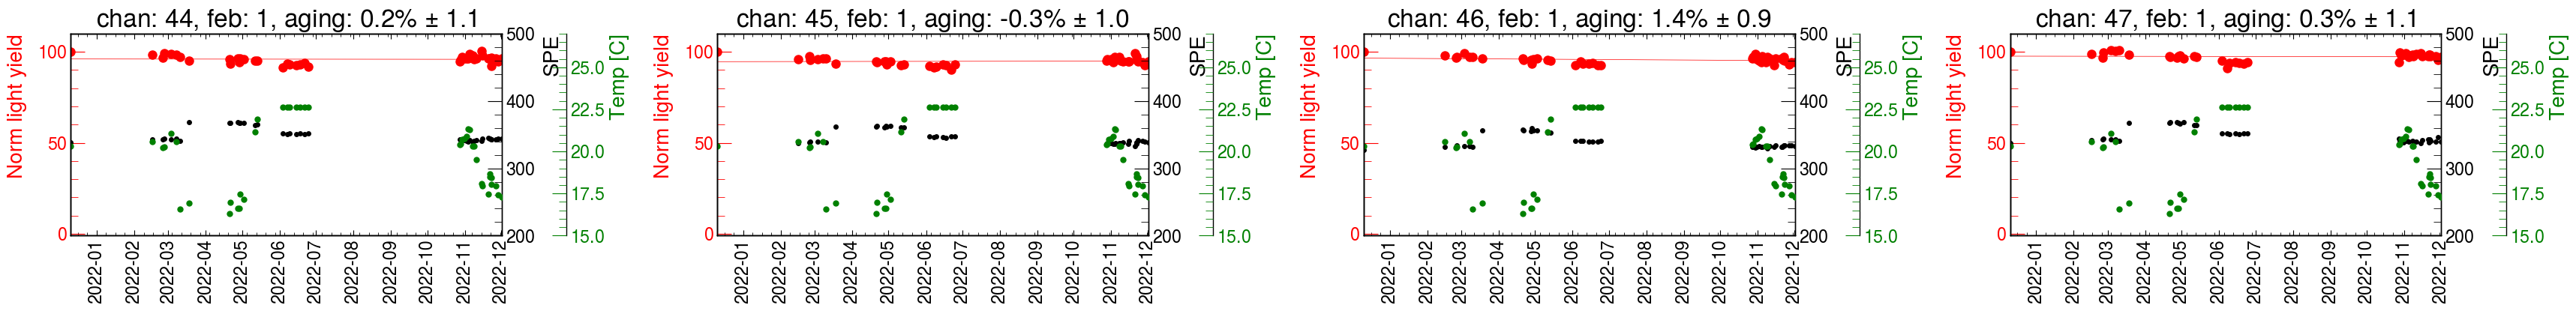

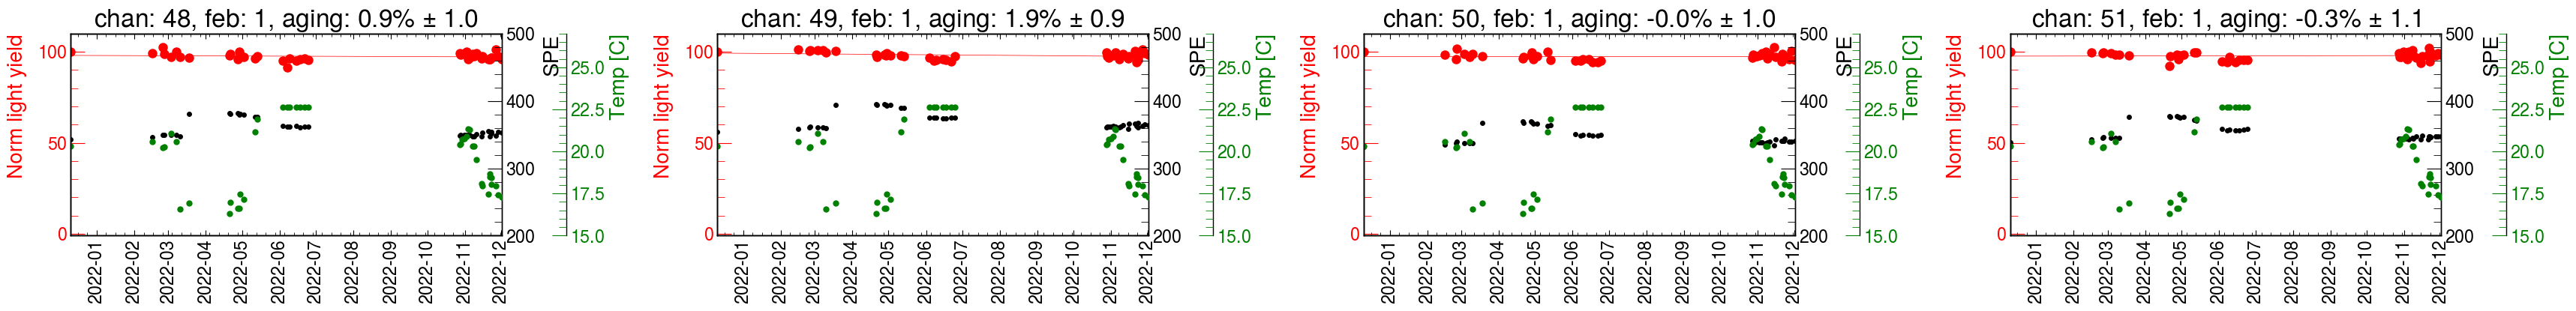

In [94]:
NFEB = 2
NHDMI = 16
skip_hdmi=[5,6,7,13,14,15]
SEC_YEAR=3.154e+7
aging_arr = -999*np.ones((3,64))
t0=str(ar['timestamp'].to_numpy()[0])

for feb in range(0, NFEB):
  for hdmi in range(0, NHDMI):
#Skip the channels on the edge with low stats    
    if hdmi in skip_hdmi:
        continue
        
    fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(40, 3.5))
    plt.subplots_adjust(wspace=0.5)
    plt.xticks(rotation = 90);

    for chan in range(0, 4):
      ax2 = ax1[chan].twinx()
      ax3 = ax1[chan].twinx()
      ax3.spines['right'].set_position(("axes", 1.15))

      #Plot normalized PE over years
      chan_infeb = hdmi*4+chan 
    
      cut = (ar['subrunNumber'] == 0) & (ar['PEsTemperatureCorrected'][:,feb,chan_infeb] > 0)
      x=ar['timestamp', cut].to_numpy()  
      y=ar['PEsTemperatureCorrected', cut][:,feb,chan_infeb].to_numpy()  
      if y[0]>0:
          y=y/y[0]*100

      slope, intercept, r_value, p_value, std_err = stats.linregress(x/SEC_YEAR, np.log(y))
#      print(slope)
      slope, intercept, r_value, p_value, std_err = stats.linregress(x/SEC_YEAR, y)
#      print(slope)
      ax1[chan].set_title('chan: %d, feb: %d, aging: %.1f%% $\pm$ %.1f'%(hdmi*4+chan,feb,-slope,std_err ))
      ax1[chan].set_ylim(-1,110)
      ax1[chan].set_ylabel('Norm light yield', color='r')
      ax1[chan].tick_params(axis='y', which='both', colors='r')
      ax1[chan].tick_params(axis='x', rotation = 90)

      ax1[chan].plot(x.astype('datetime64[s]'), y , 'ro')
      line_x = np.arange(x.min(), x.max(),36000) # 10 hour bins - used to draw fit line only
      line_y = slope*line_x/SEC_YEAR + intercept
      ax1[chan].plot(line_x.astype('datetime64[s]'), line_y, 'r-',linewidth=0.5, label='$%.2fx + %.2f$, $R^2=%.2f$' % (slope, intercept, r_value**2))

      y=ar['calibConstantsTemperatureCorrected', cut][:,feb,chan_infeb].to_numpy()         
      ax2.plot(x.astype('datetime64[s]'), y , 'k.')
      ax2.set_ylim(200,500)
      ax2.set_ylabel('SPE', color='k', labelpad=7);
        
      #Plot temp over time
      y=ar['meanTemperatures', cut][:,0,0].to_numpy()
      ax3.plot(x.astype('datetime64[s]'), y, 'go', markersize=5.0)
      ax3.set_ylabel('Temp [C]', color='g', labelpad=5)
      ax3.set_ylim(15,27)
      ax3.tick_params(axis='y', which='both', colors='g')
      aging_arr[feb][chan_infeb] =-slope

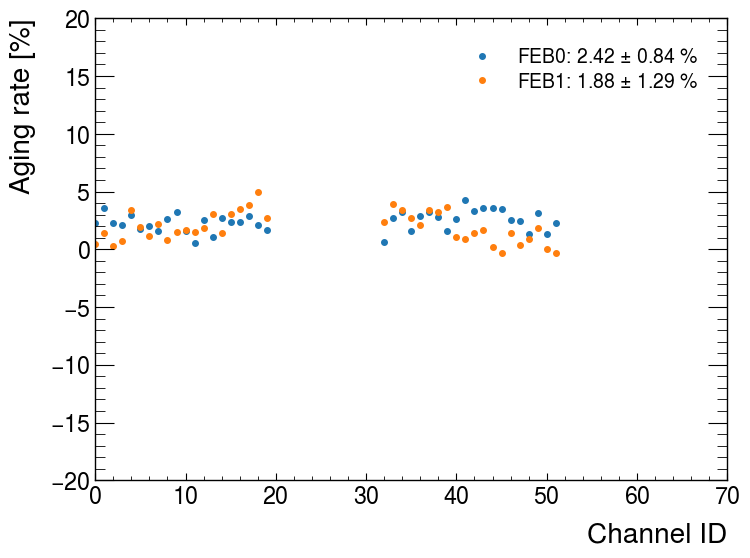

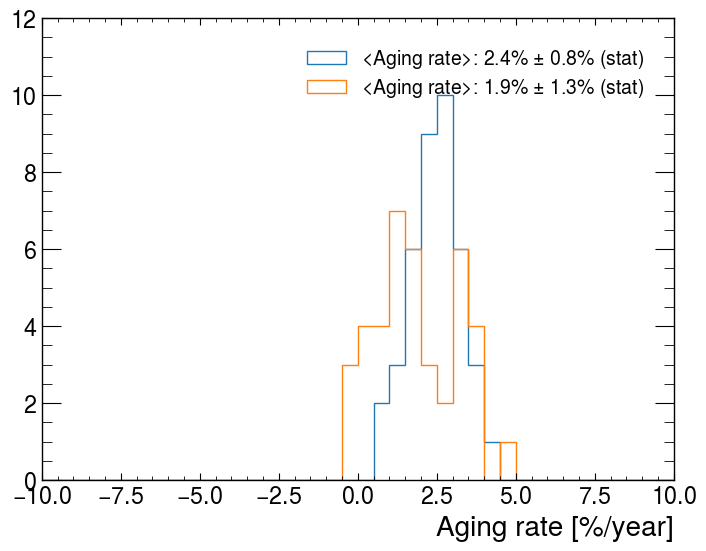

In [113]:
for feb in range(0, NFEB):
    feb_age_arr = aging_arr[feb,:]
    feb_age_arr_=feb_age_arr[feb_age_arr > -20] # Drop bad points with failed fits 
    mean = feb_age_arr_[~np.isnan(feb_age_arr_)].mean()
    std = feb_age_arr_[~np.isnan(feb_age_arr_)].std()    
    plt.plot(feb_age_arr, '.', label='FEB%d: %.2f $\pm$ %.2f %%'%(feb, mean, std  ))
    
    plt.legend()
    plt.xlabel('Channel ID')
    plt.ylim(-20,20)
    plt.ylabel('Aging rate [%]')

plt.figure()
for feb in range(0, NFEB):
    feb_age_arr = aging_arr[feb,:]
    feb_age_arr = feb_age_arr[feb_age_arr>-999]
    plt.hist(feb_age_arr, bins=40, range=(-10,10), histtype='step', label='<Aging rate>: %.1f%% $\pm$ %.1f%% (stat)'%(np.mean(feb_age_arr), np.std(feb_age_arr)) );
    plt.xlabel('Aging rate [%/year]', labelpad=5);
    plt.legend();

<Figure size 800x600 with 0 Axes>

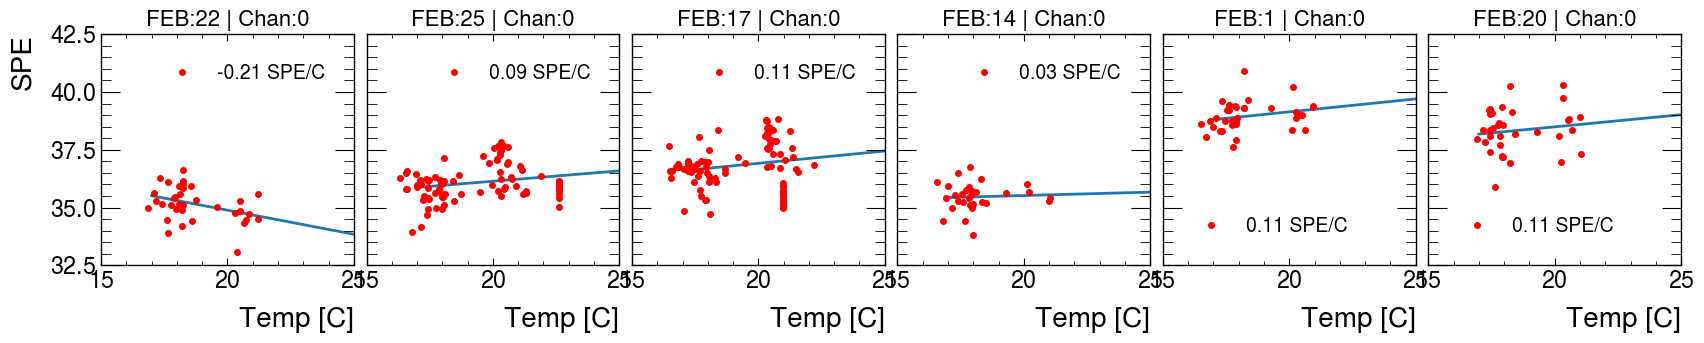

<Figure size 800x600 with 0 Axes>

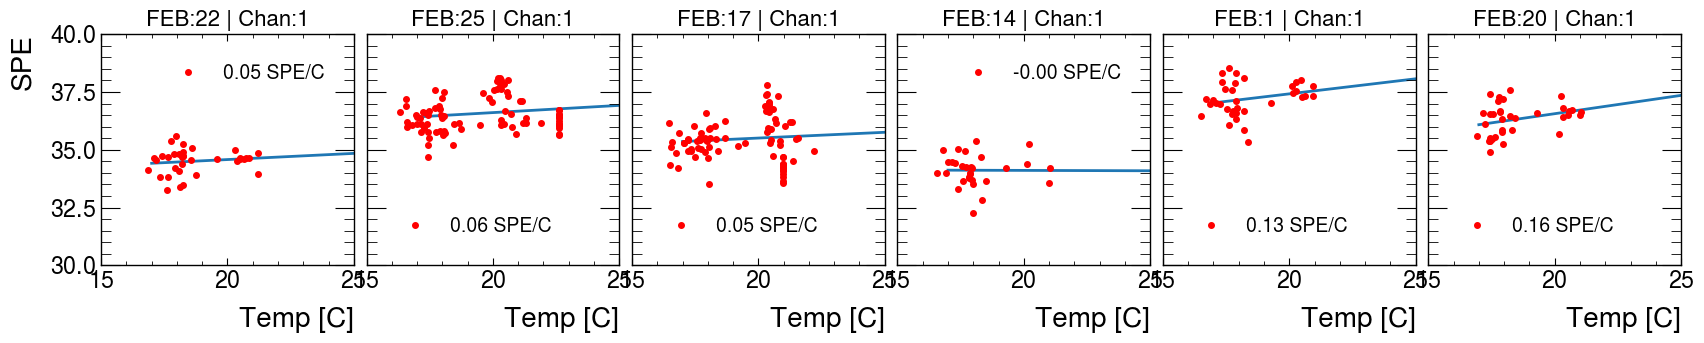

<Figure size 800x600 with 0 Axes>

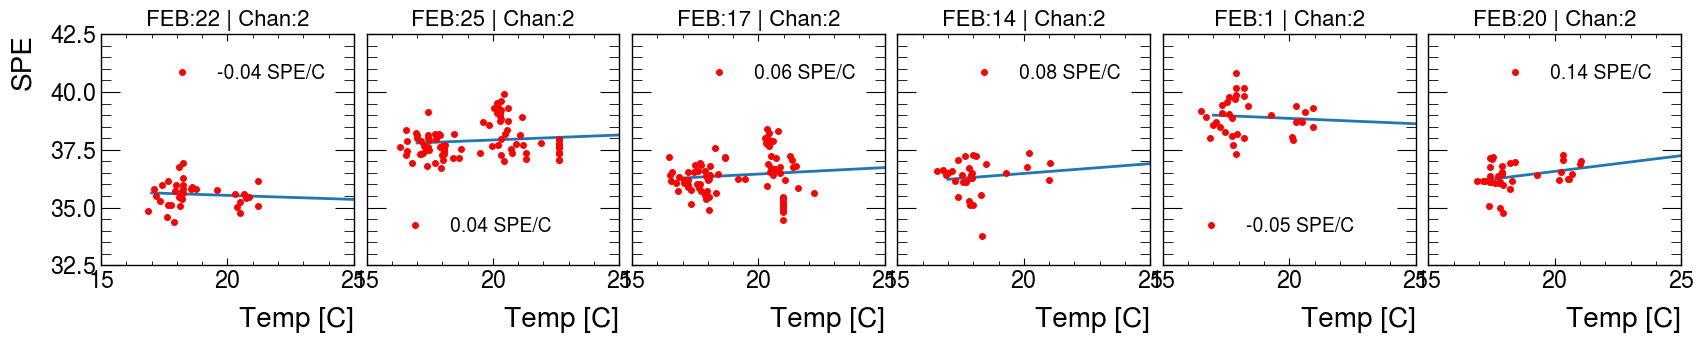

<Figure size 800x600 with 0 Axes>

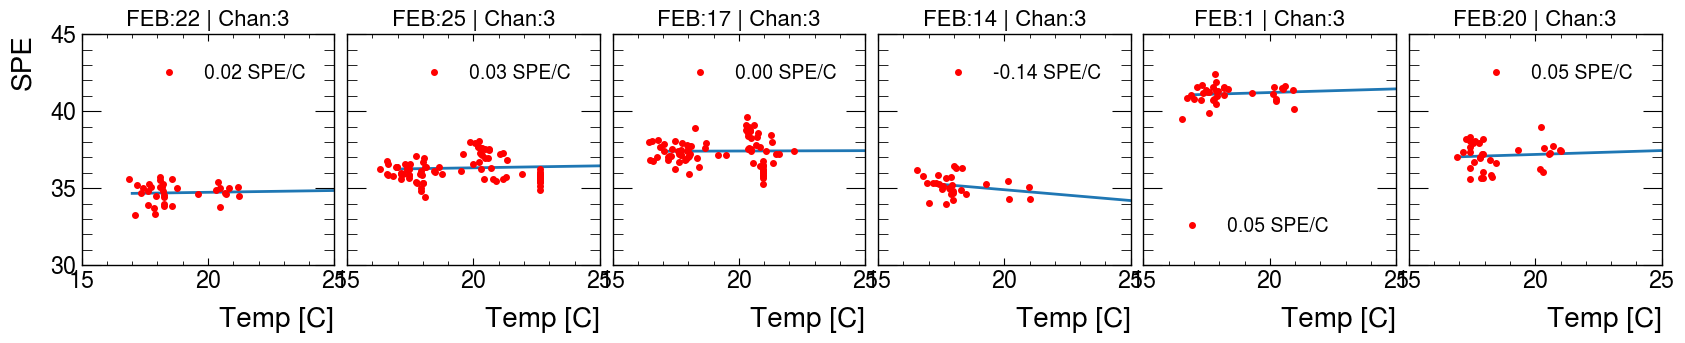

<Figure size 800x600 with 0 Axes>

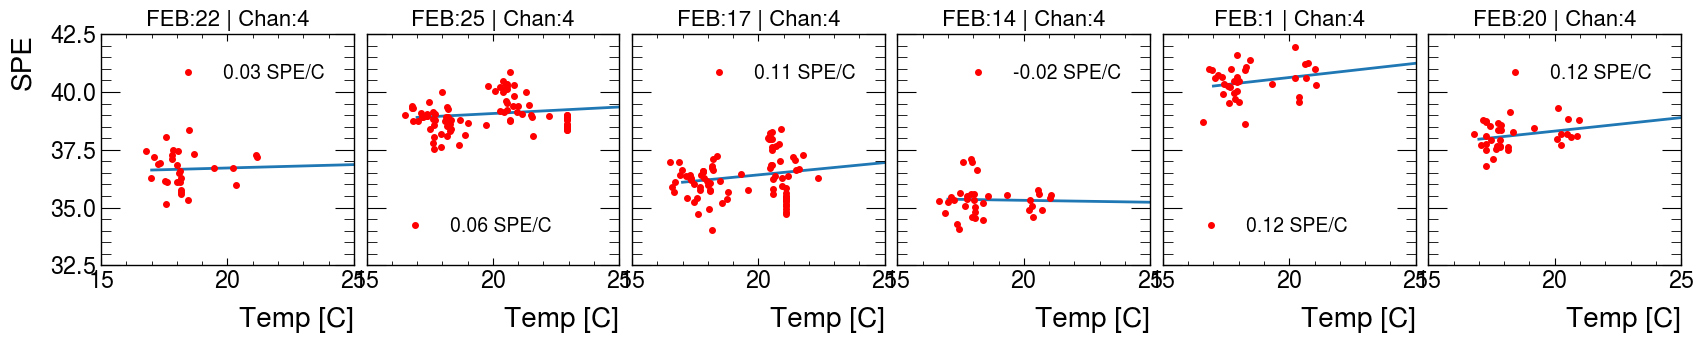

<Figure size 800x600 with 0 Axes>

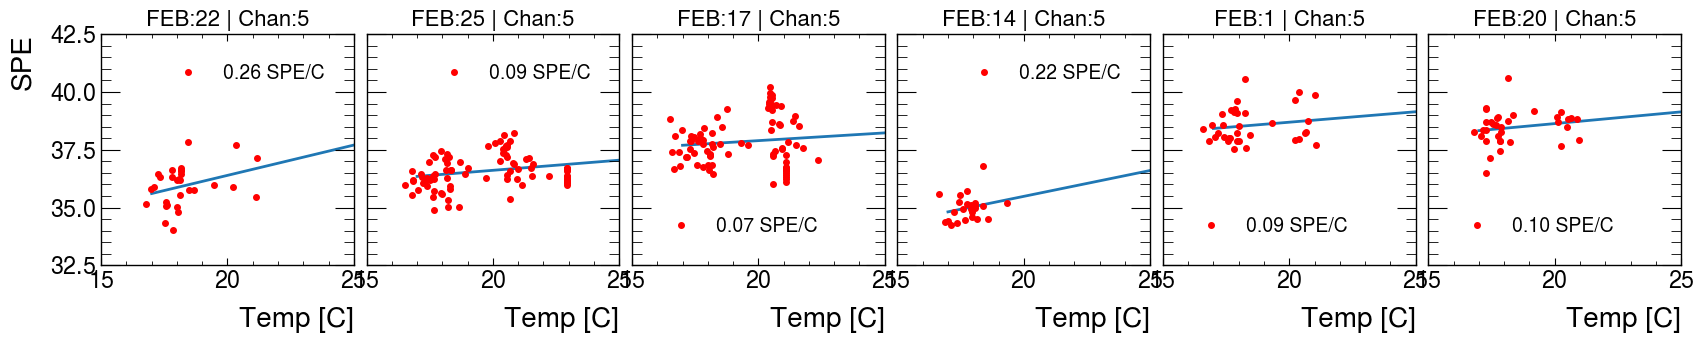

<Figure size 800x600 with 0 Axes>

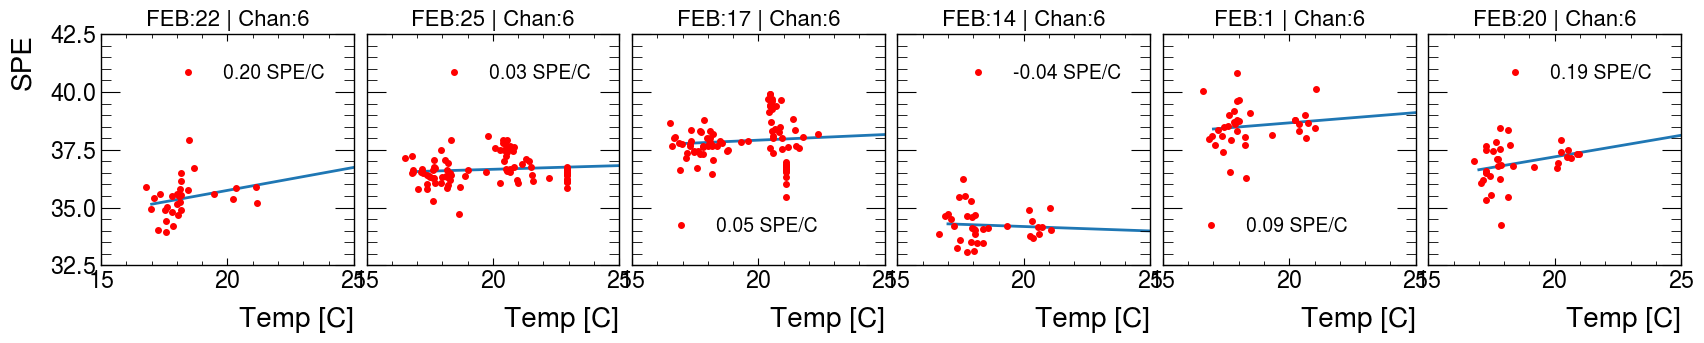

<Figure size 800x600 with 0 Axes>

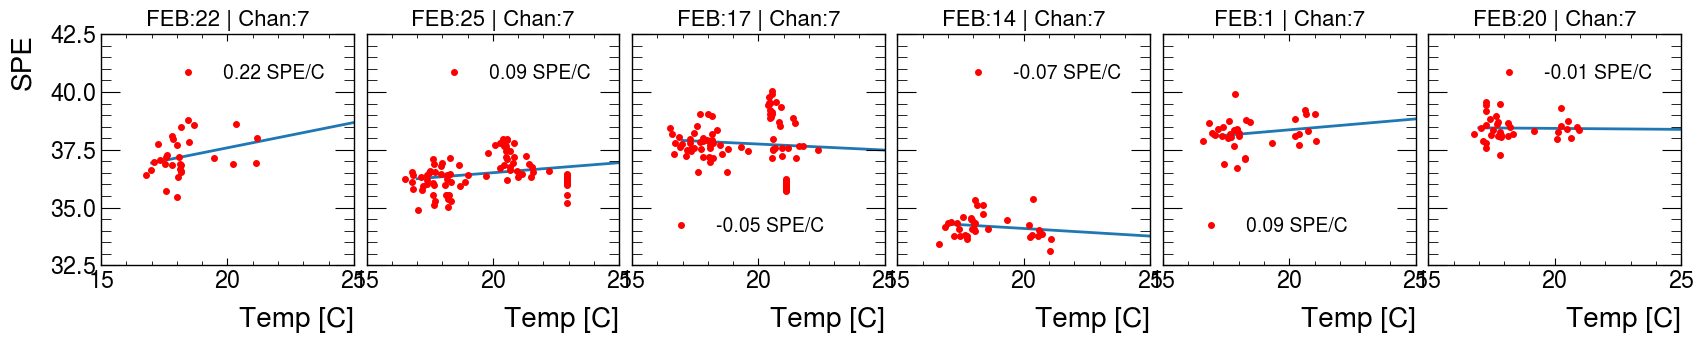

<Figure size 800x600 with 0 Axes>

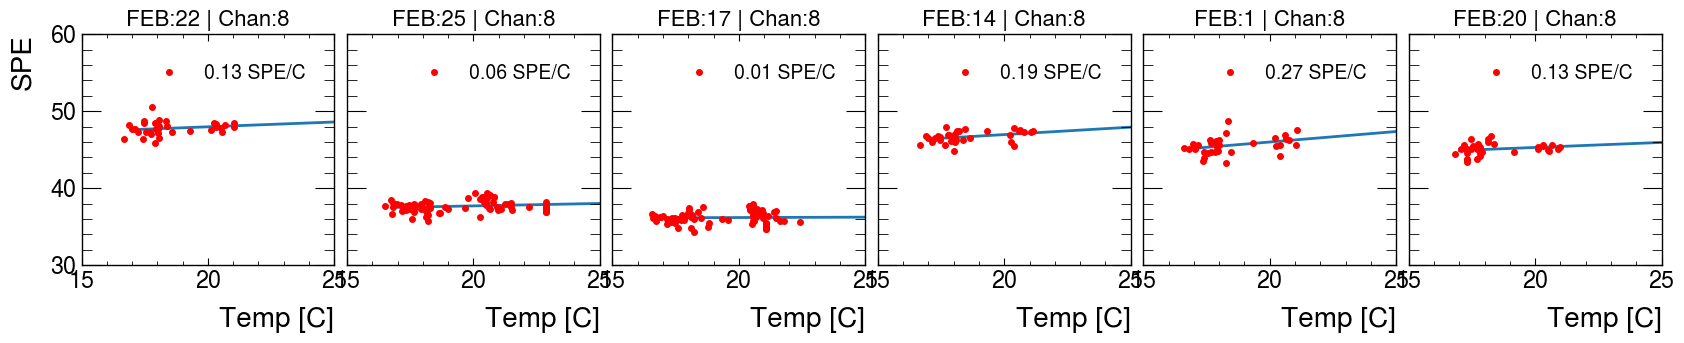

<Figure size 800x600 with 0 Axes>

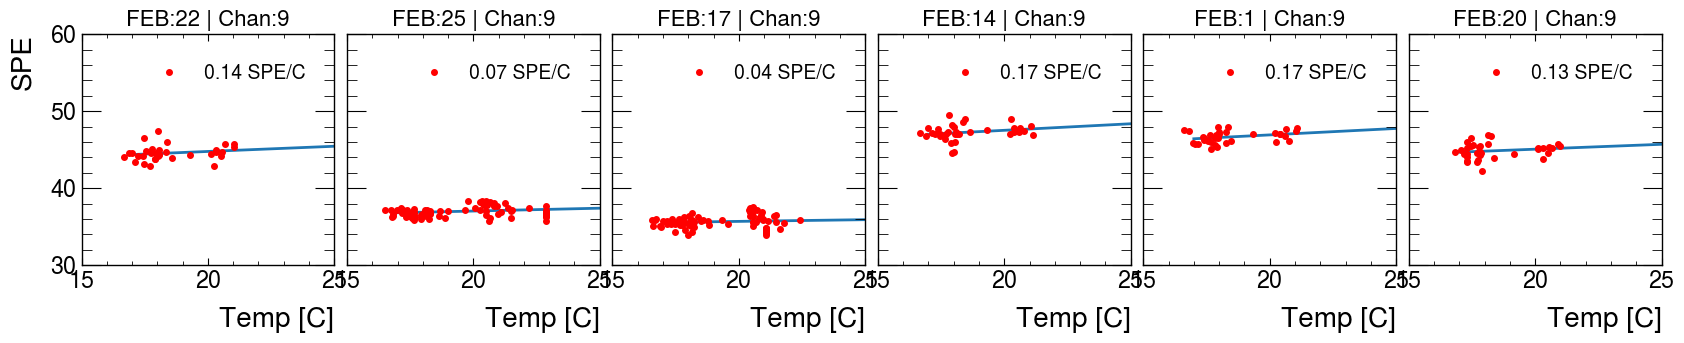

<Figure size 800x600 with 0 Axes>

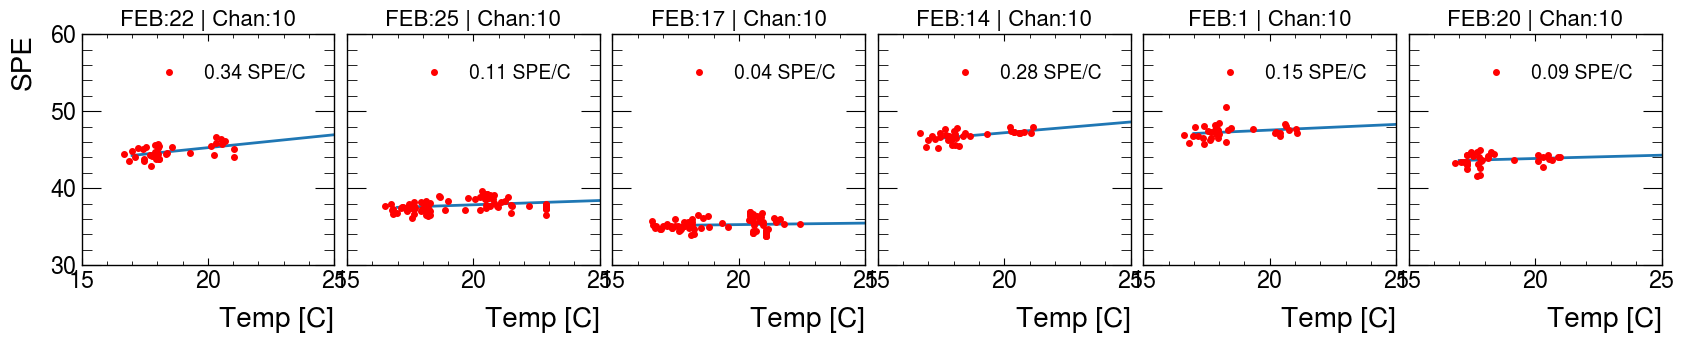

<Figure size 800x600 with 0 Axes>

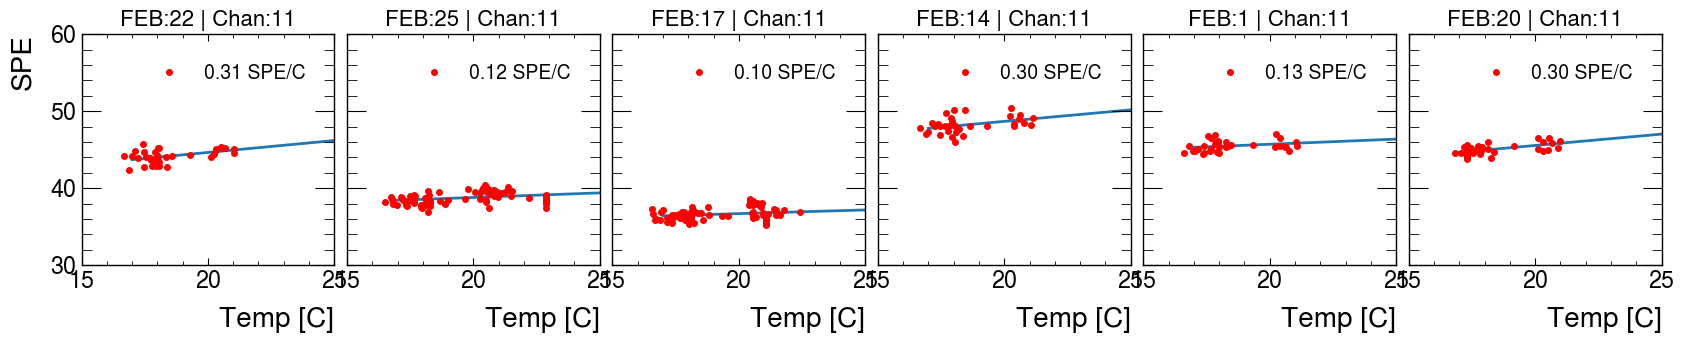

<Figure size 800x600 with 0 Axes>

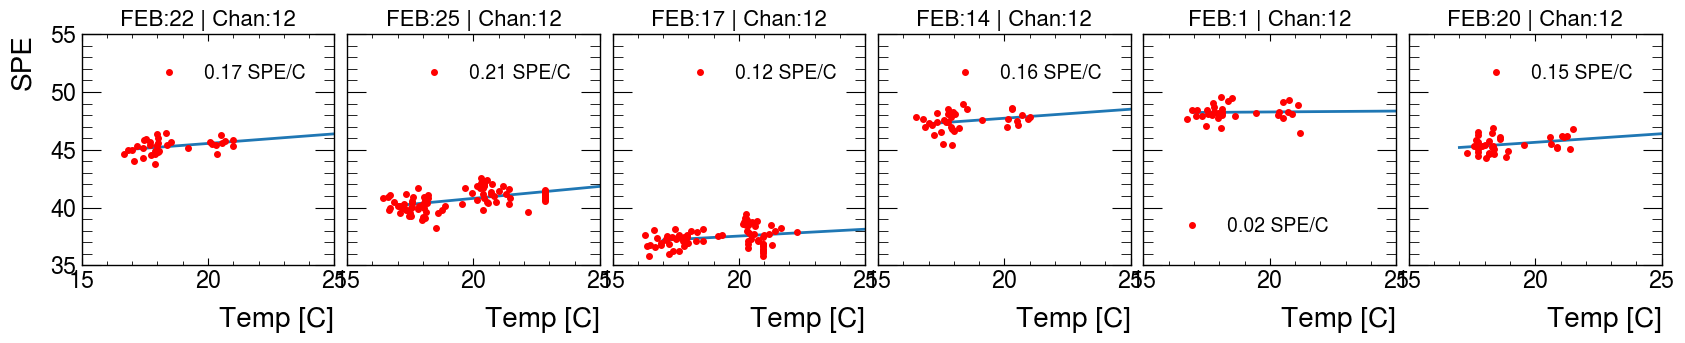

<Figure size 800x600 with 0 Axes>

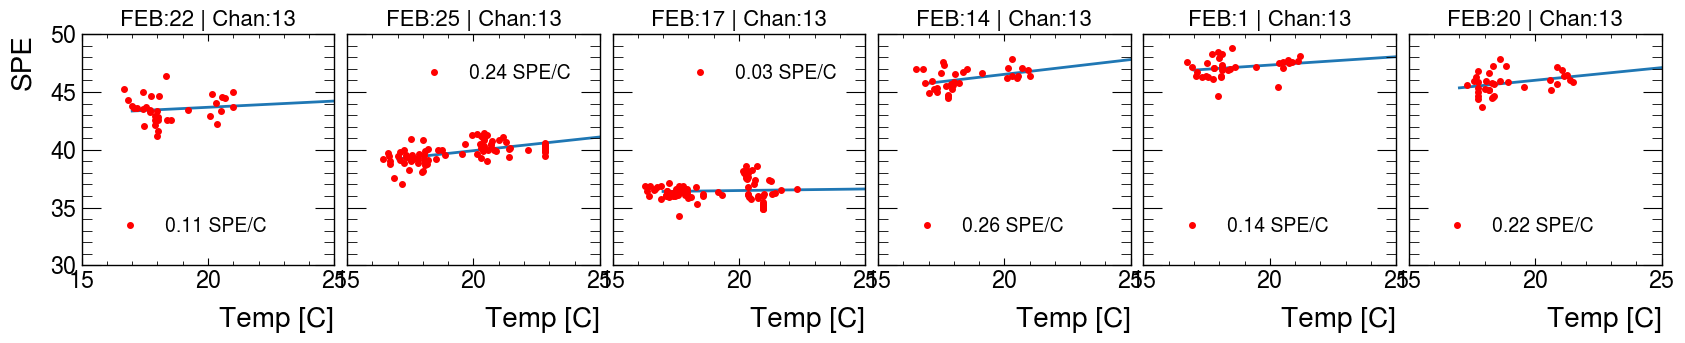

<Figure size 800x600 with 0 Axes>

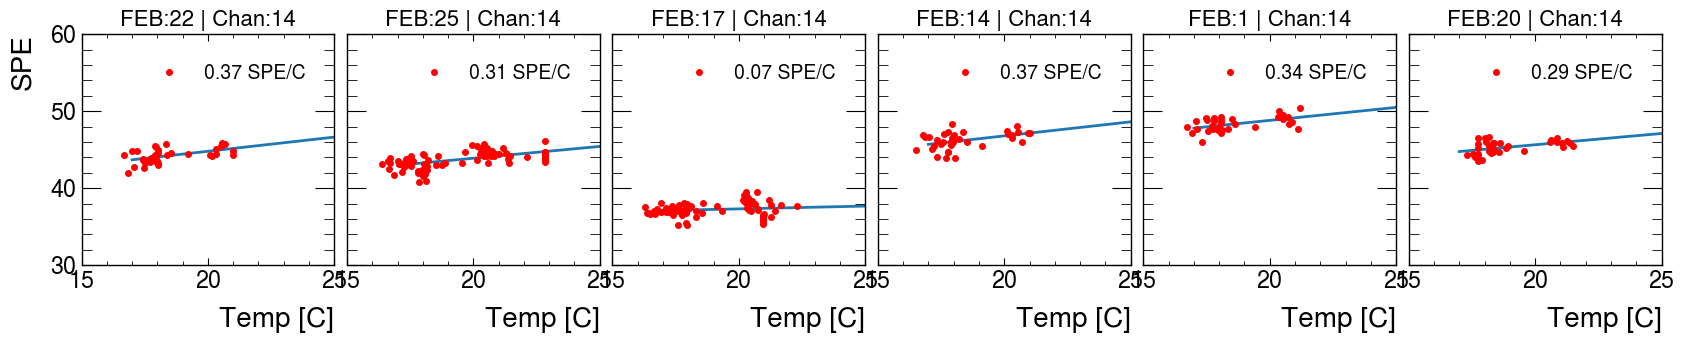

<Figure size 800x600 with 0 Axes>

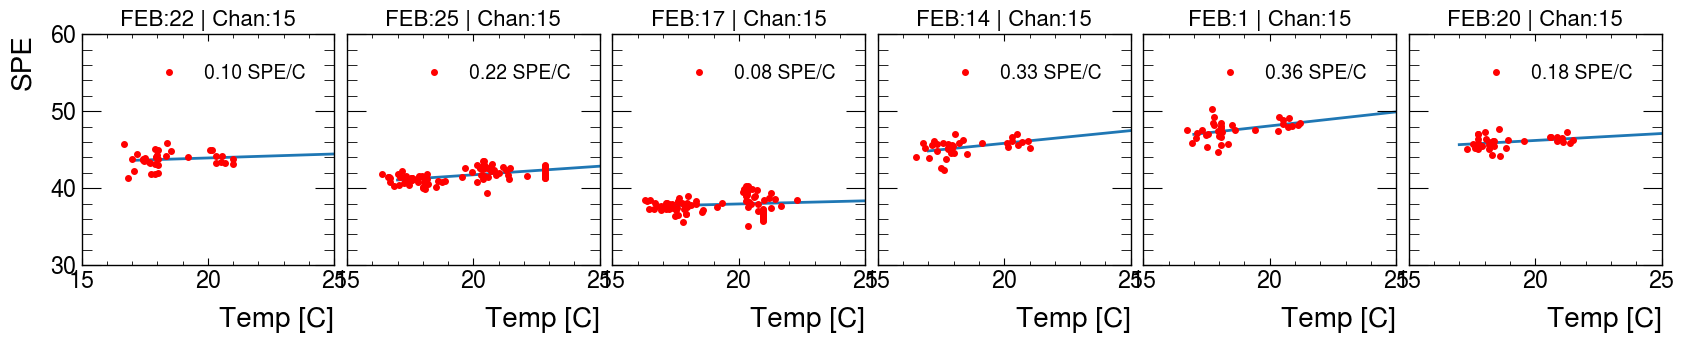

<Figure size 800x600 with 0 Axes>

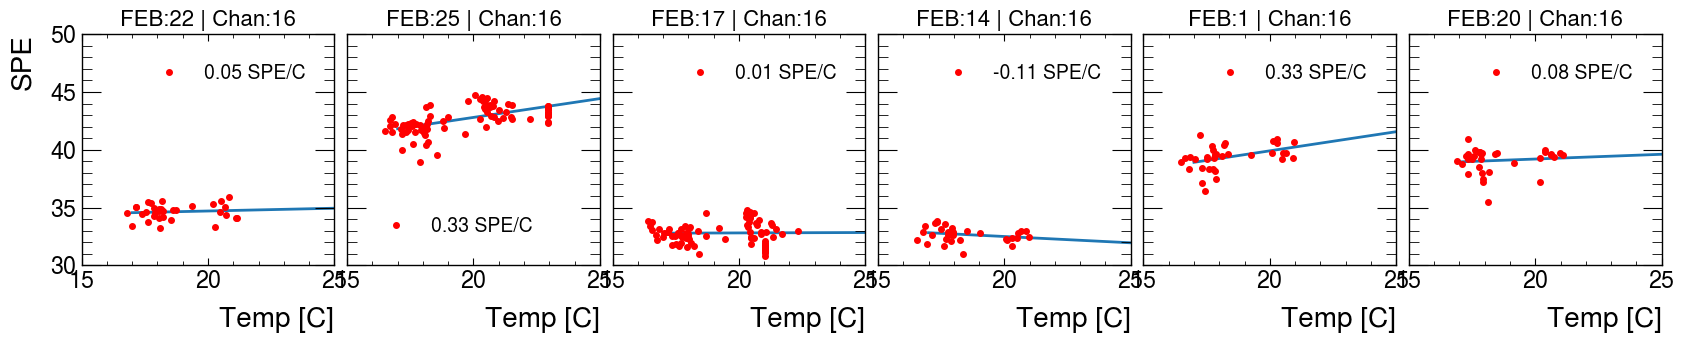

<Figure size 800x600 with 0 Axes>

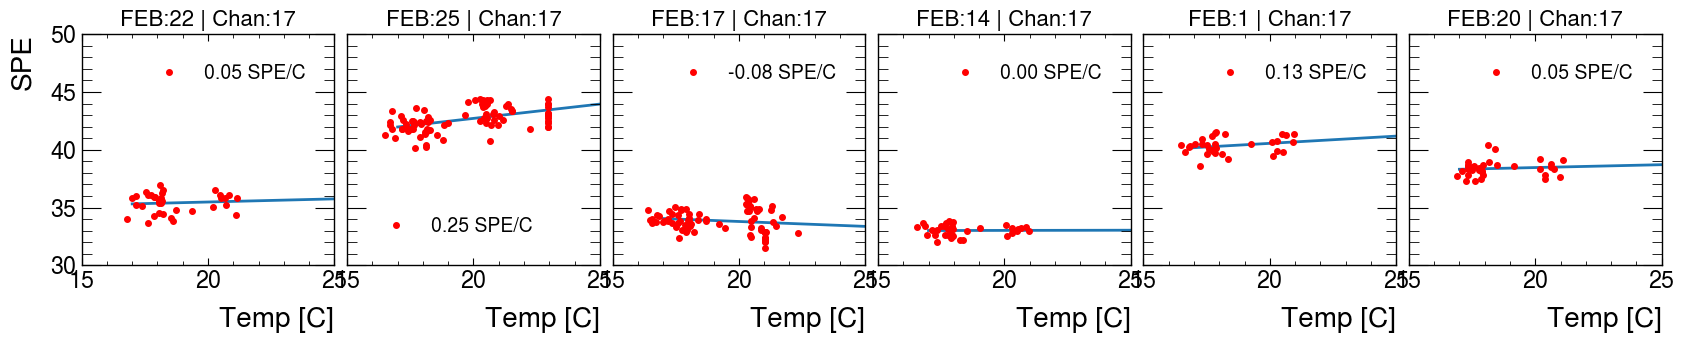

<Figure size 800x600 with 0 Axes>

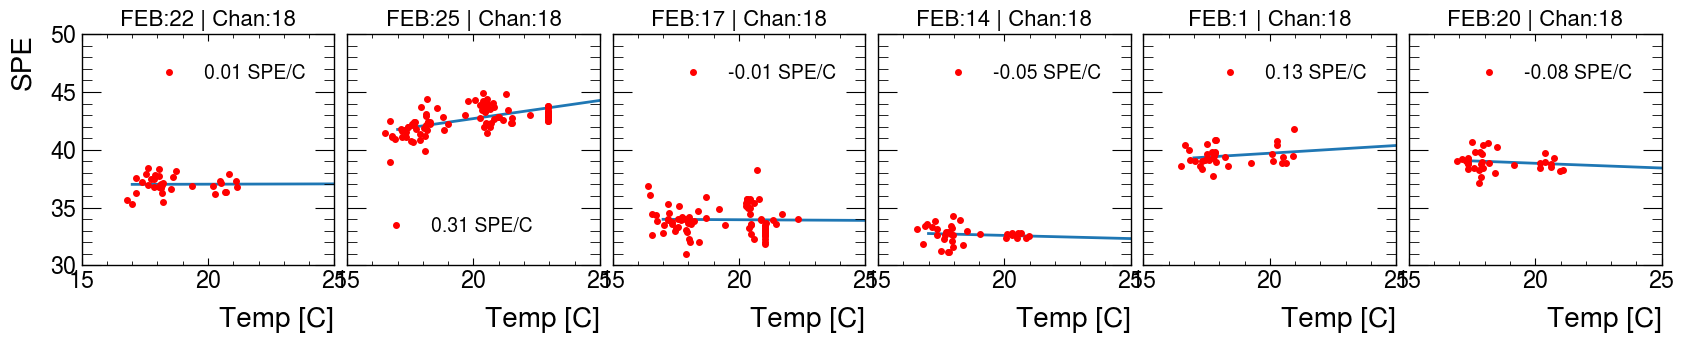

<Figure size 800x600 with 0 Axes>

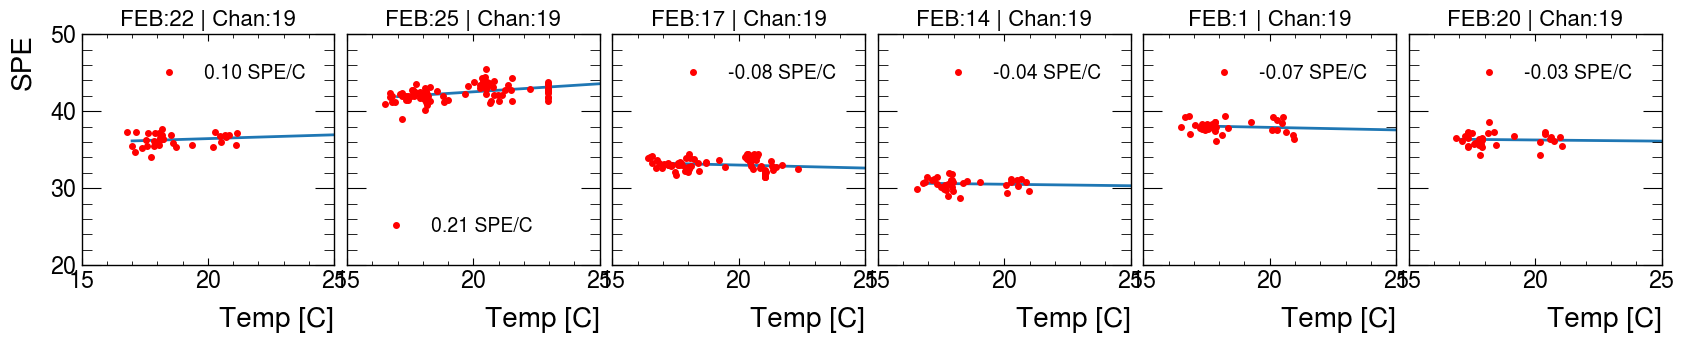

<Figure size 800x600 with 0 Axes>

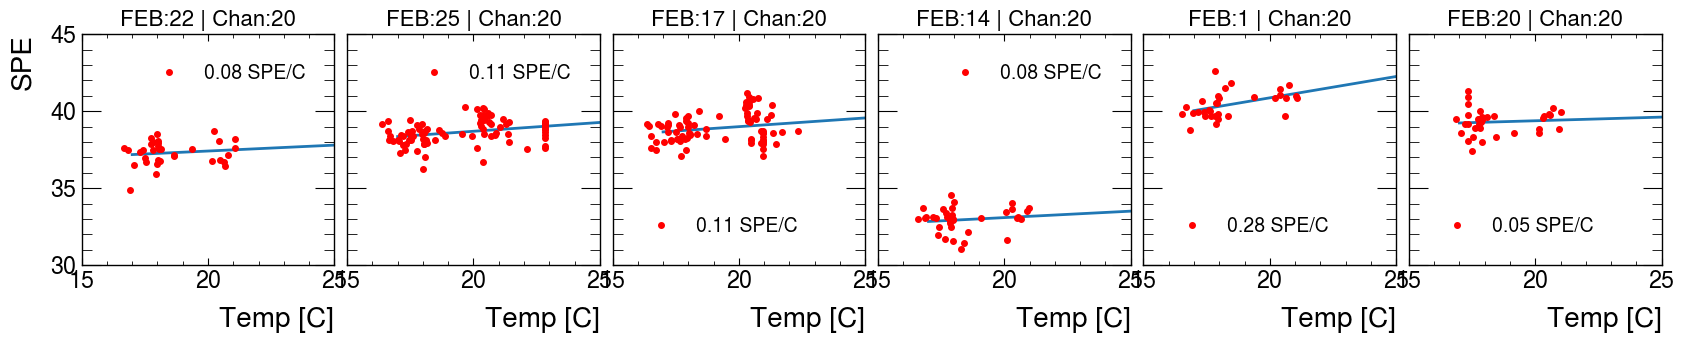

<Figure size 800x600 with 0 Axes>

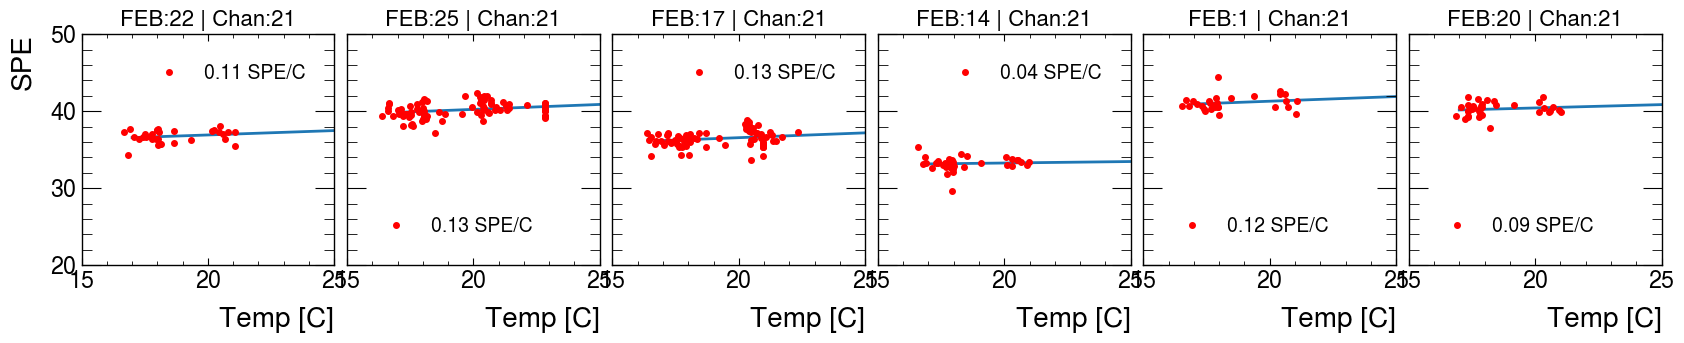

<Figure size 800x600 with 0 Axes>

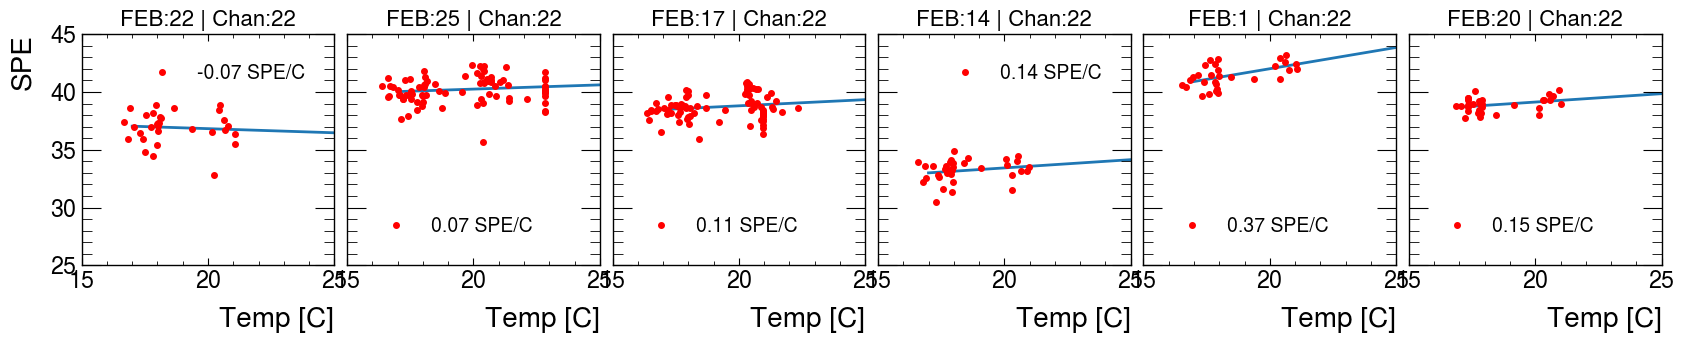

<Figure size 800x600 with 0 Axes>

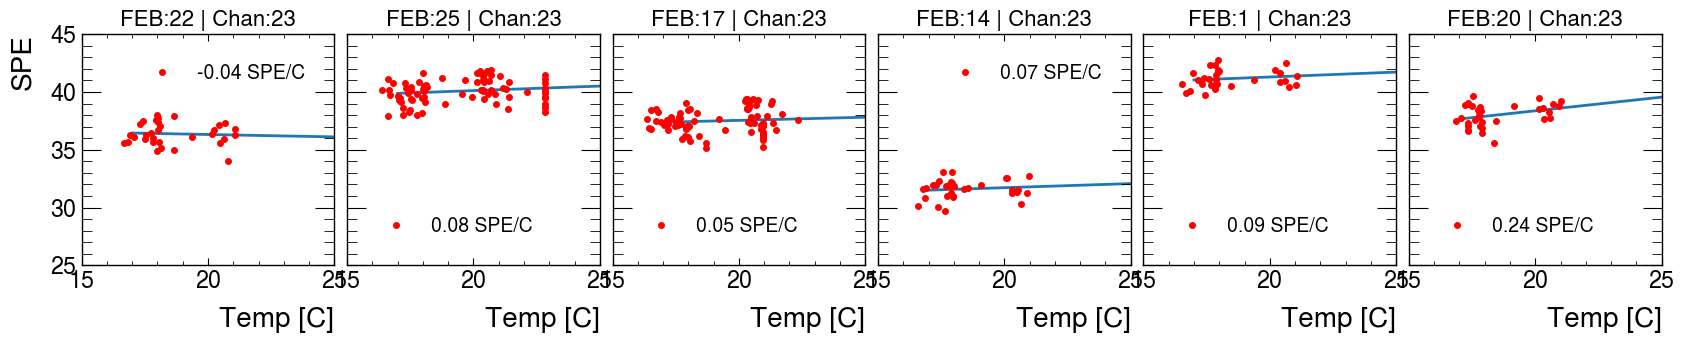

<Figure size 800x600 with 0 Axes>

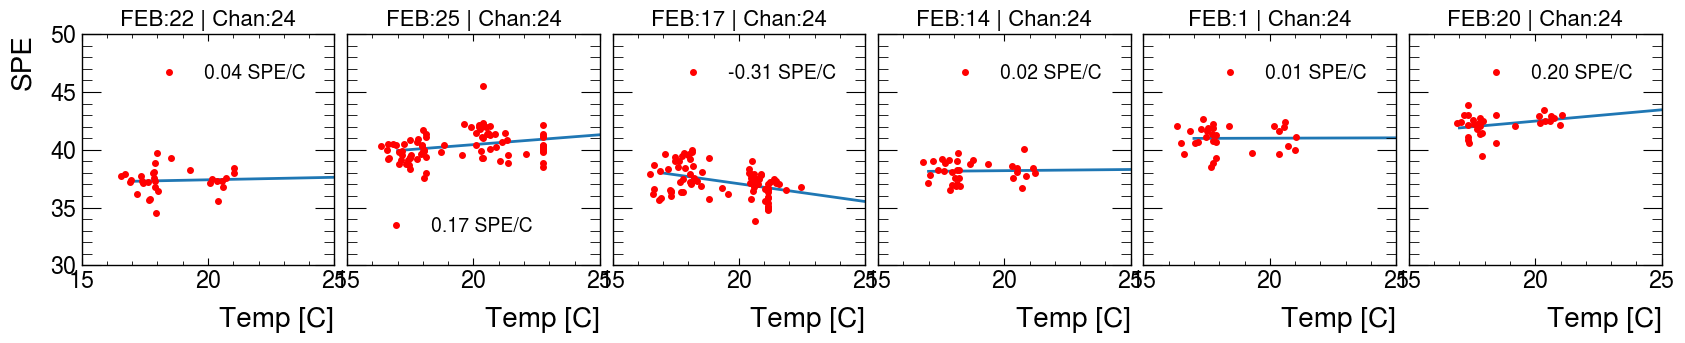

<Figure size 800x600 with 0 Axes>

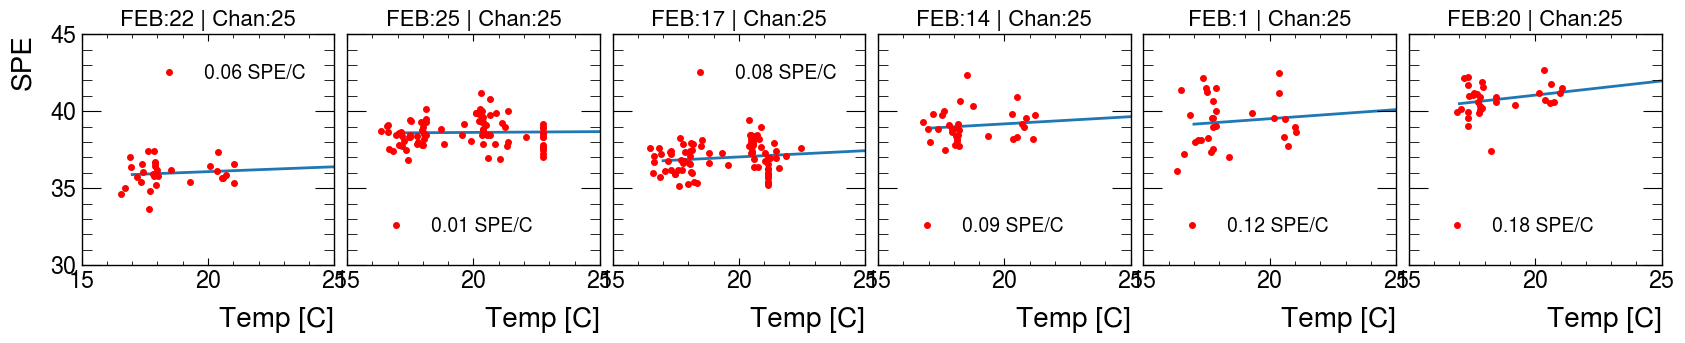

<Figure size 800x600 with 0 Axes>

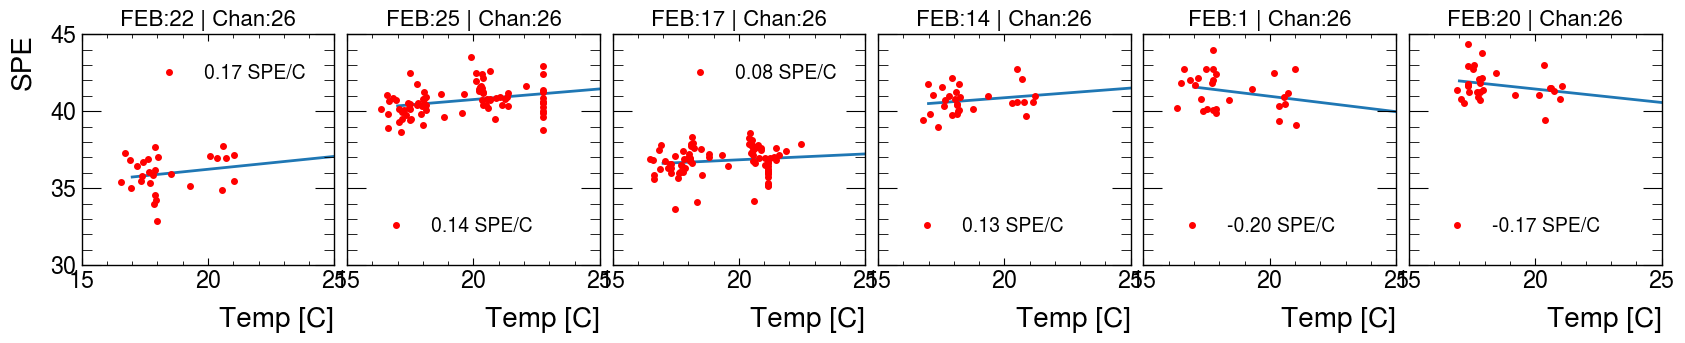

<Figure size 800x600 with 0 Axes>

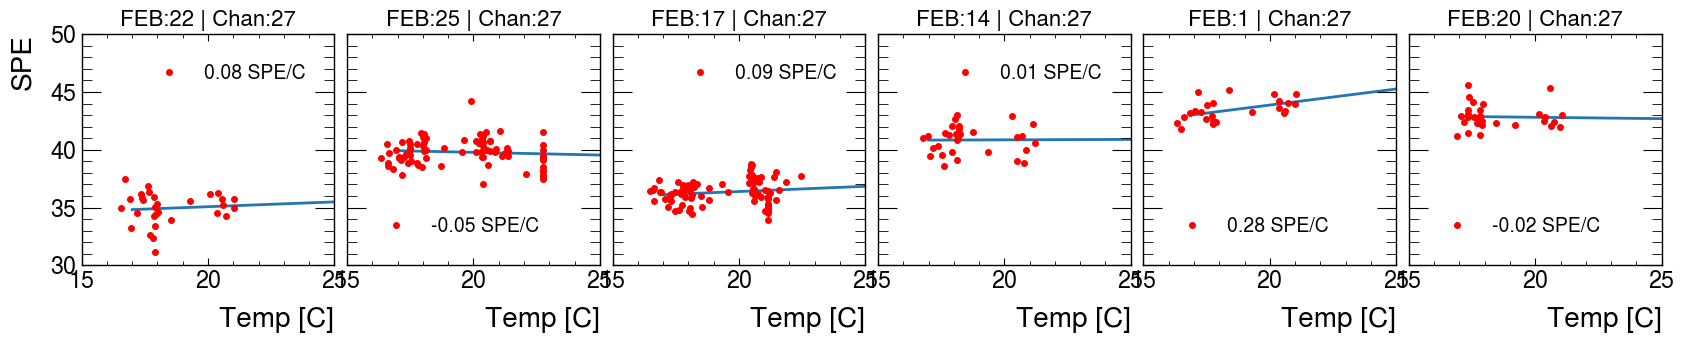

<Figure size 800x600 with 0 Axes>

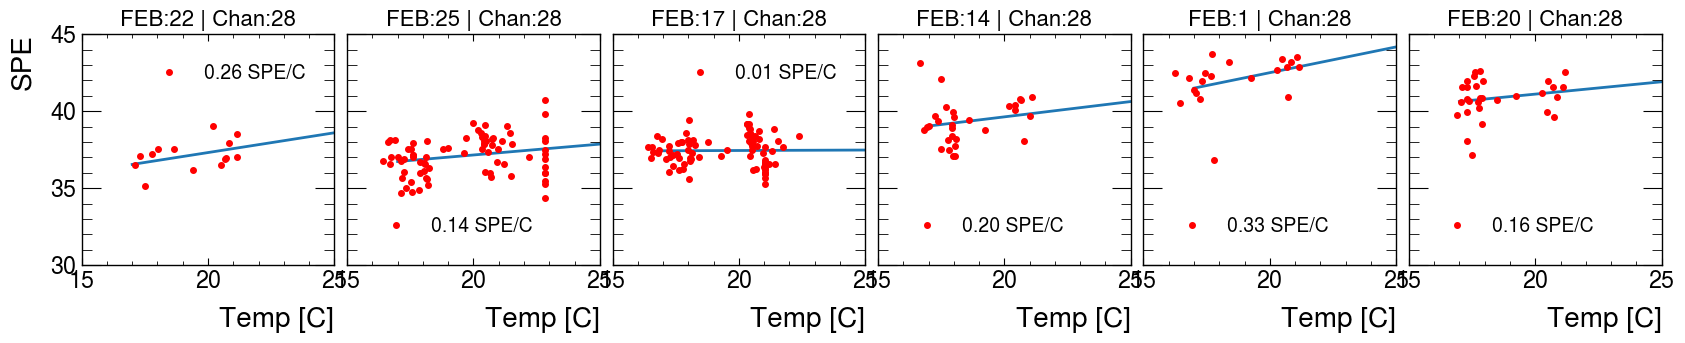

<Figure size 800x600 with 0 Axes>

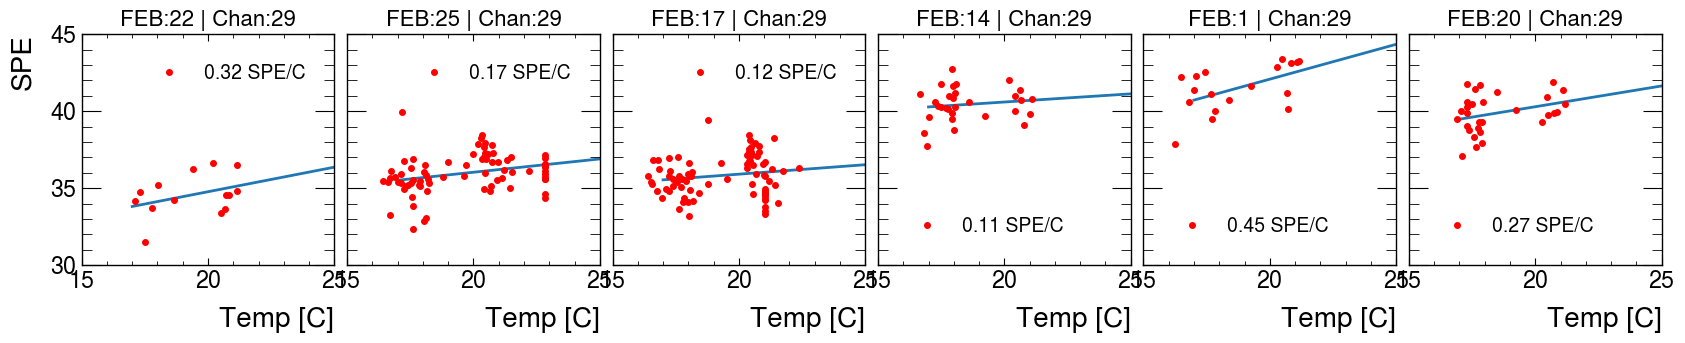

<Figure size 800x600 with 0 Axes>

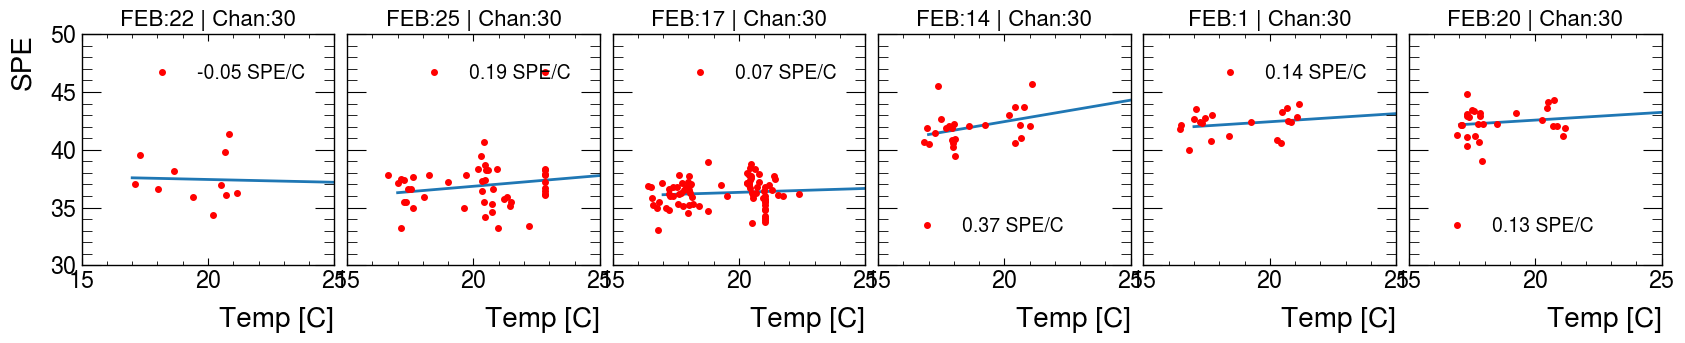

<Figure size 800x600 with 0 Axes>

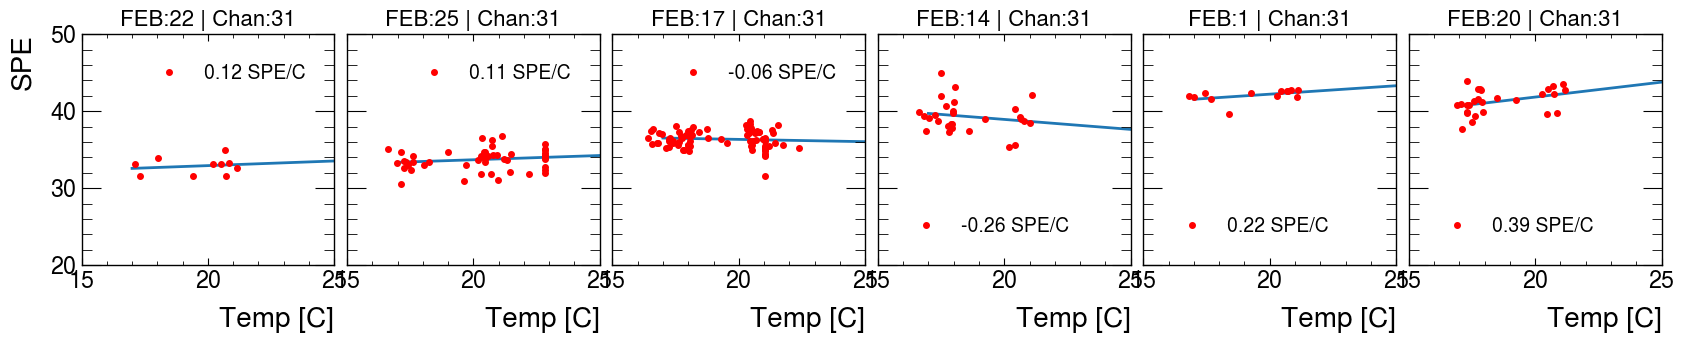

<Figure size 800x600 with 0 Axes>

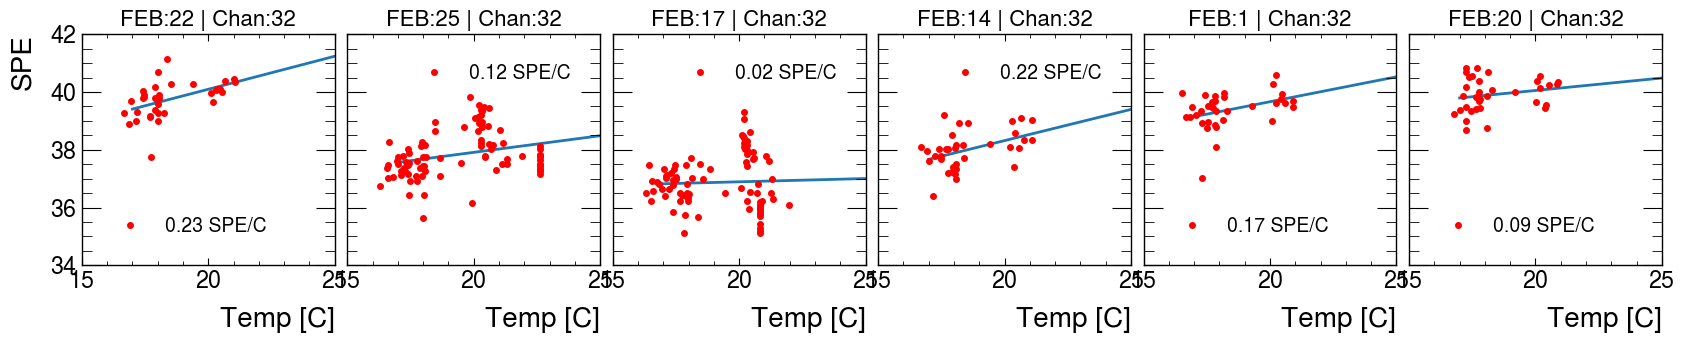

<Figure size 800x600 with 0 Axes>

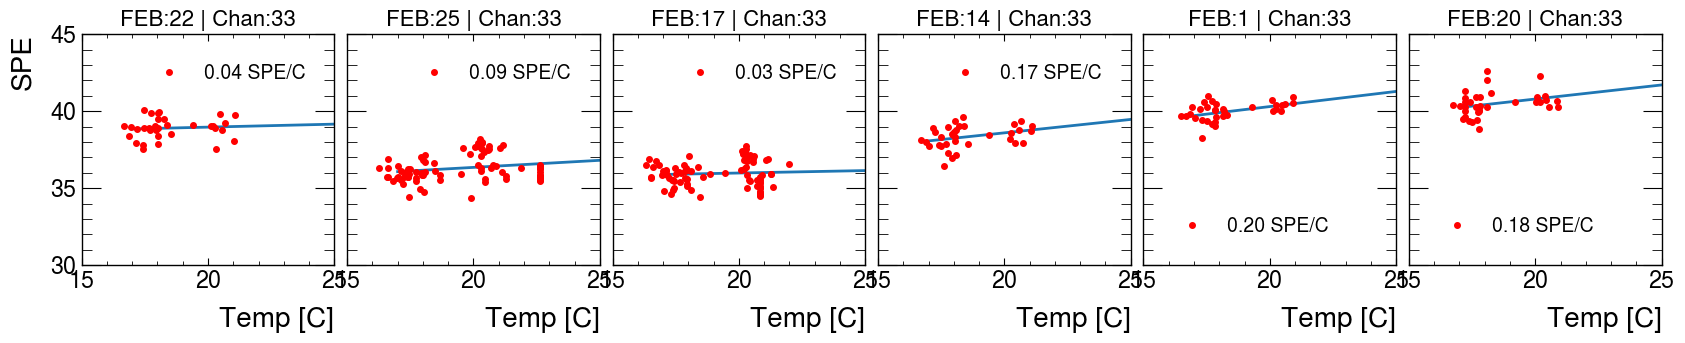

<Figure size 800x600 with 0 Axes>

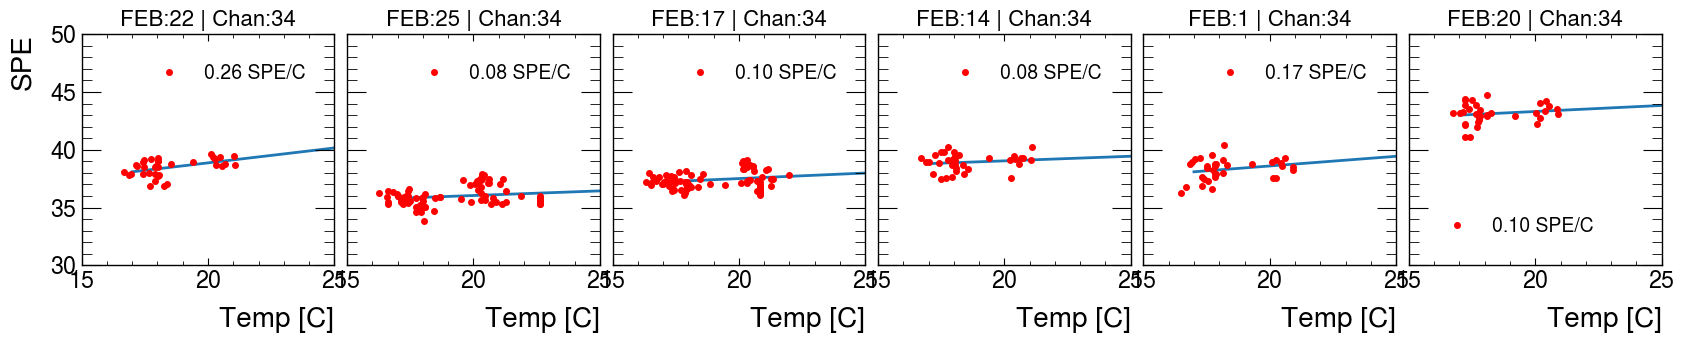

<Figure size 800x600 with 0 Axes>

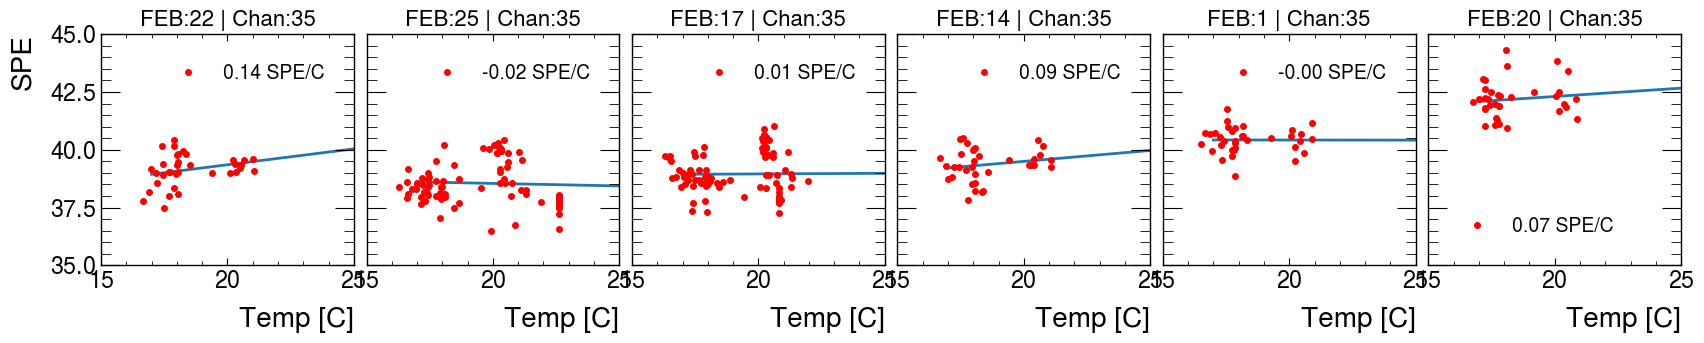

<Figure size 800x600 with 0 Axes>

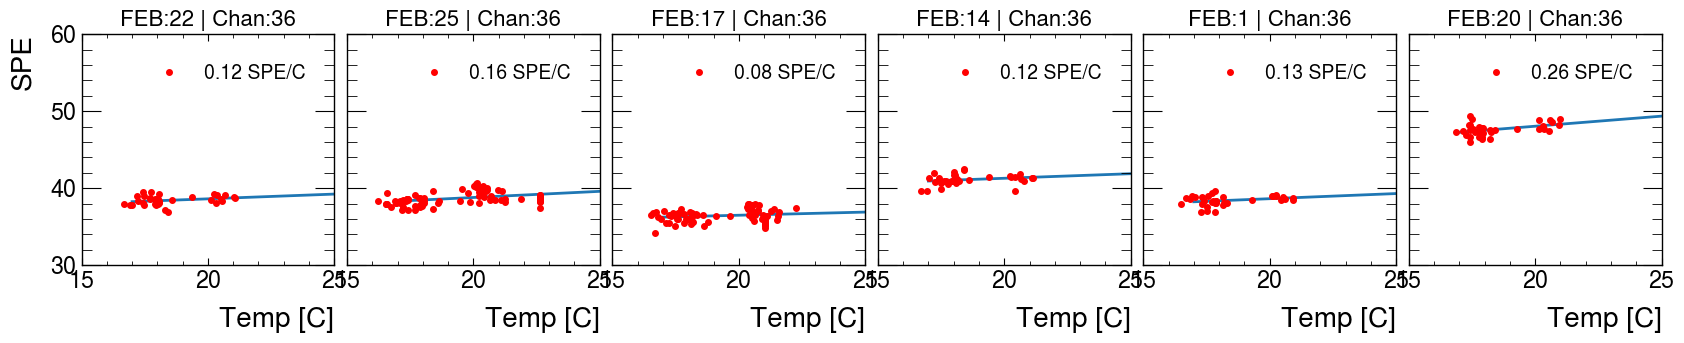

<Figure size 800x600 with 0 Axes>

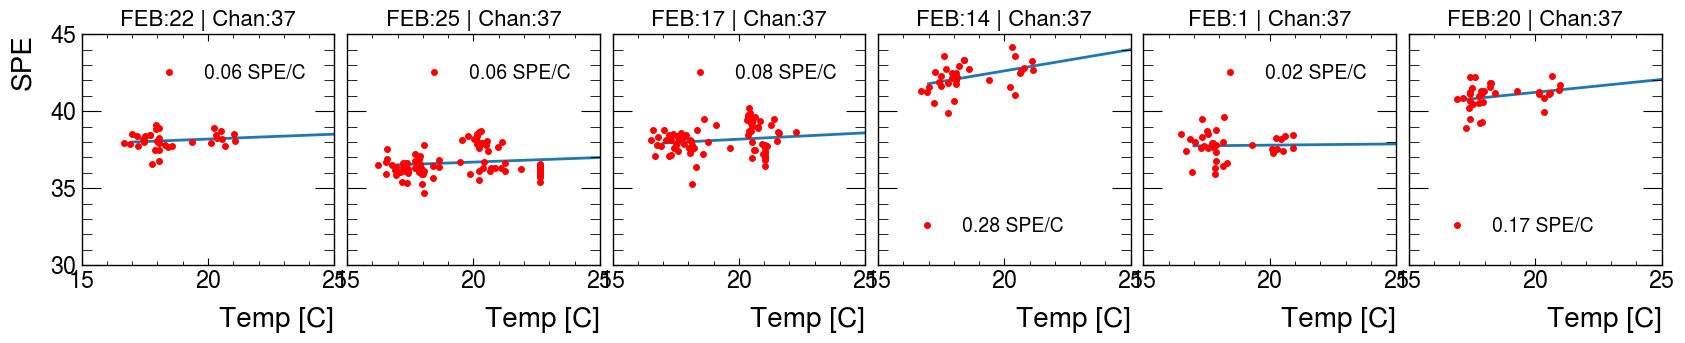

<Figure size 800x600 with 0 Axes>

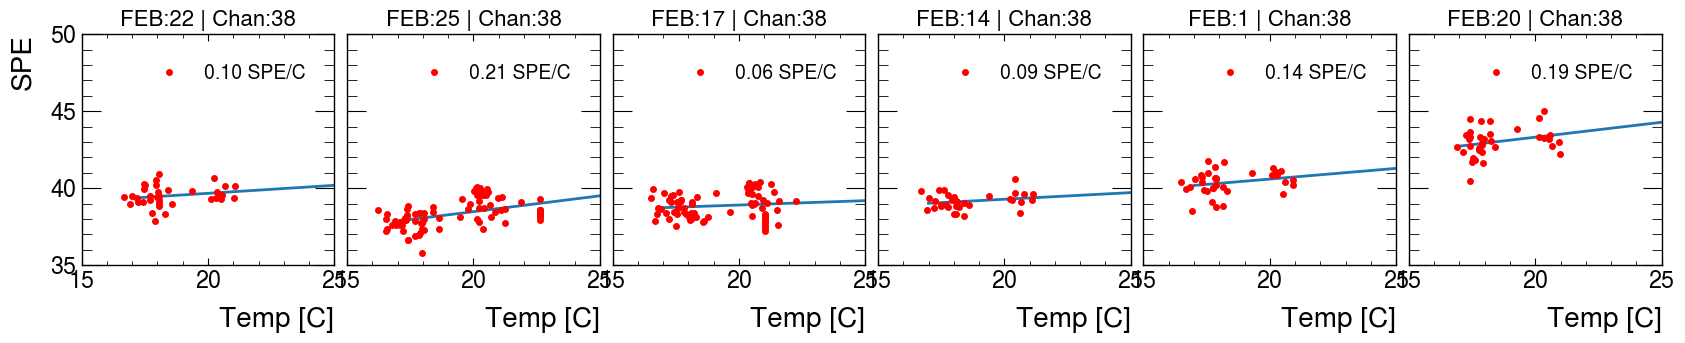

<Figure size 800x600 with 0 Axes>

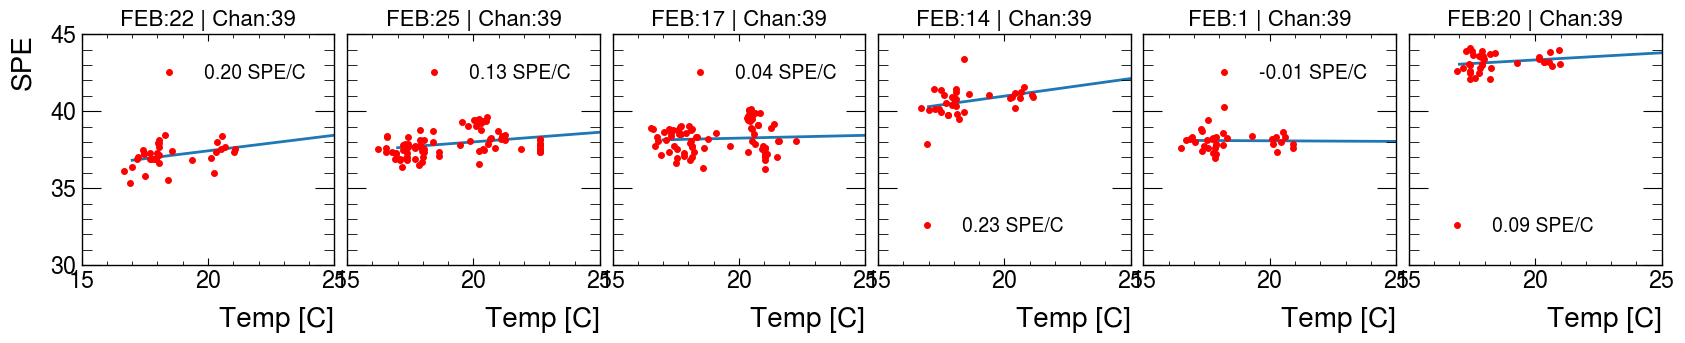

<Figure size 800x600 with 0 Axes>

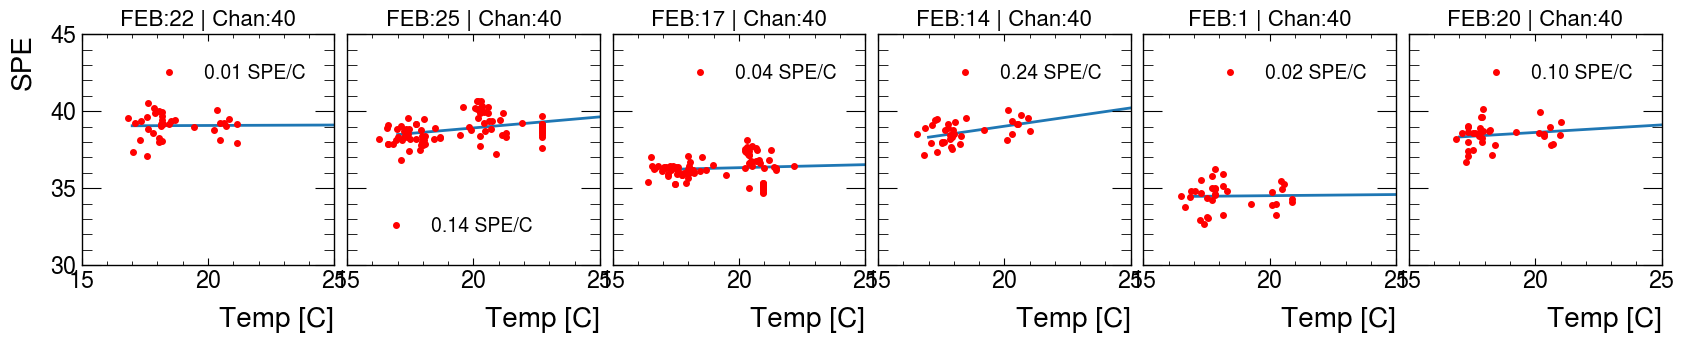

<Figure size 800x600 with 0 Axes>

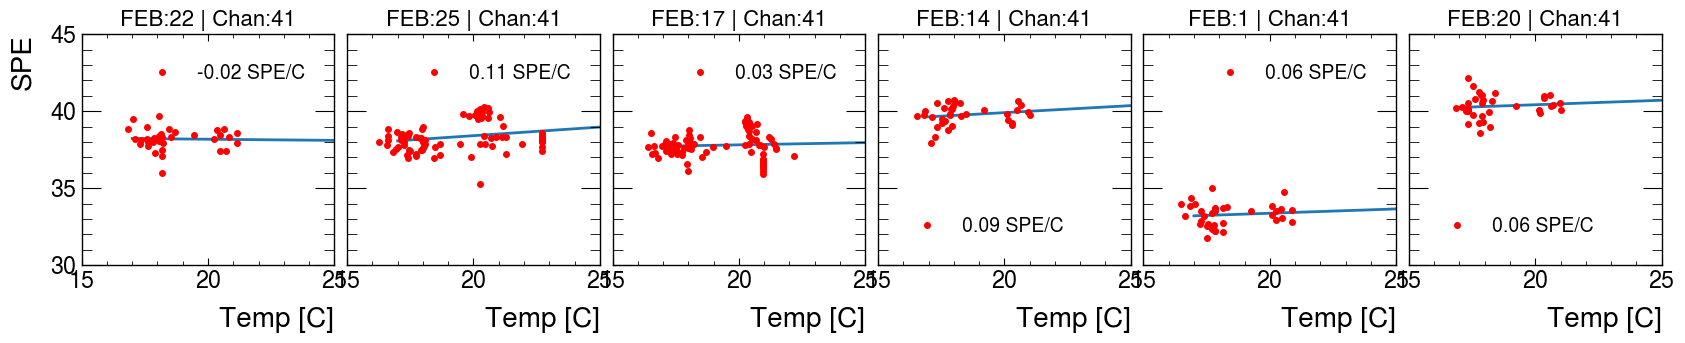

<Figure size 800x600 with 0 Axes>

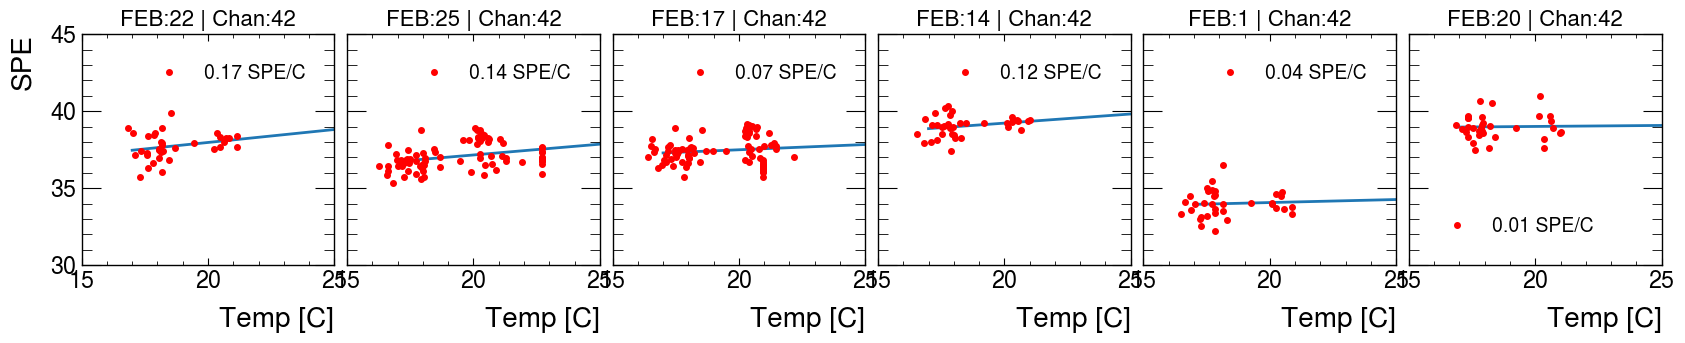

<Figure size 800x600 with 0 Axes>

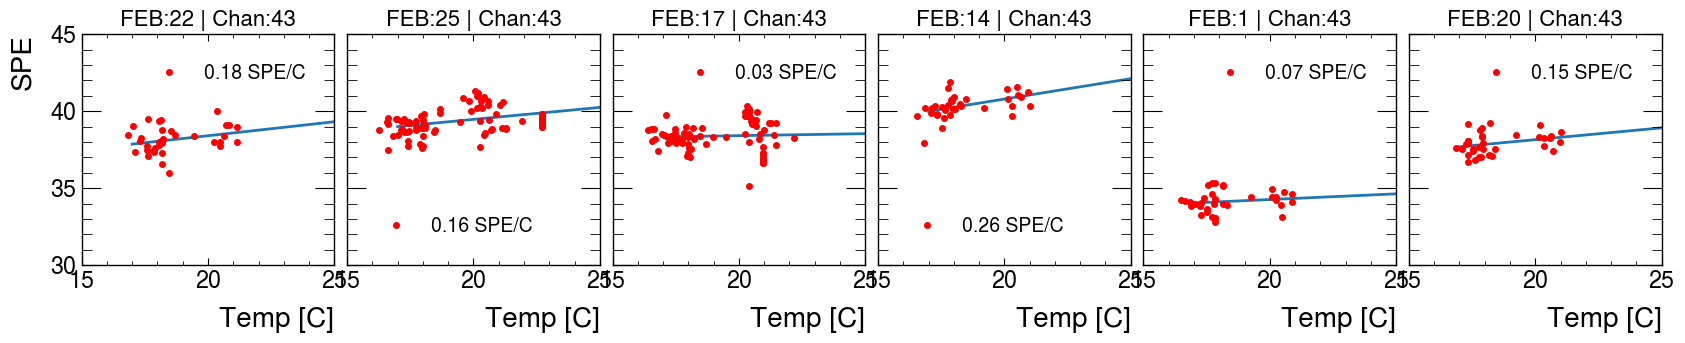

<Figure size 800x600 with 0 Axes>

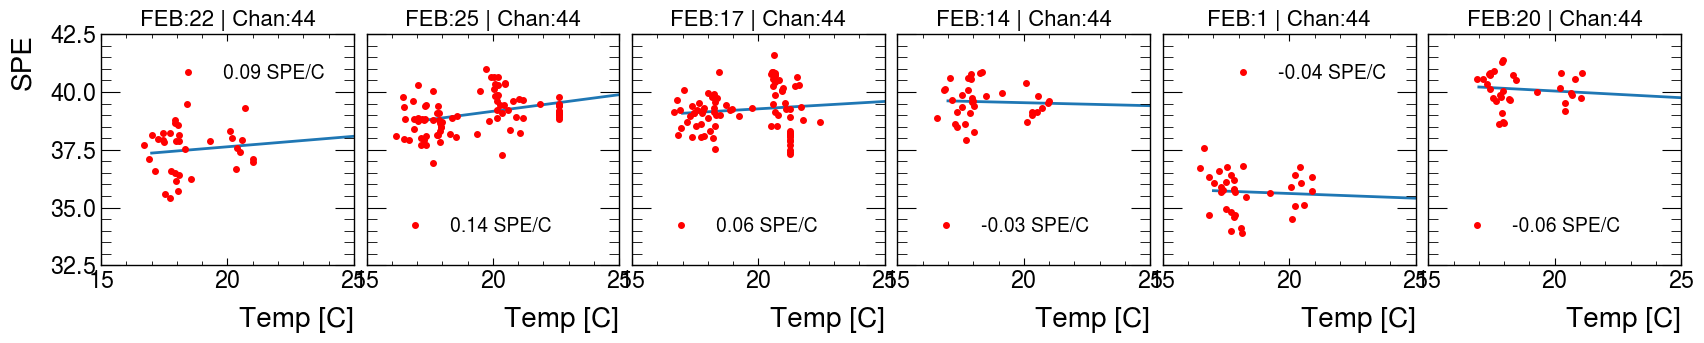

<Figure size 800x600 with 0 Axes>

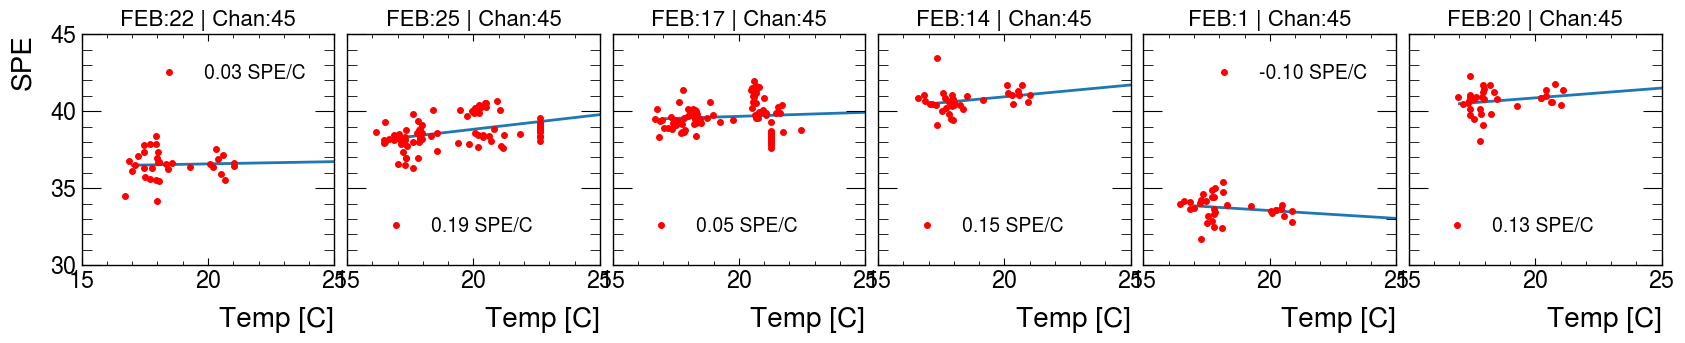

<Figure size 800x600 with 0 Axes>

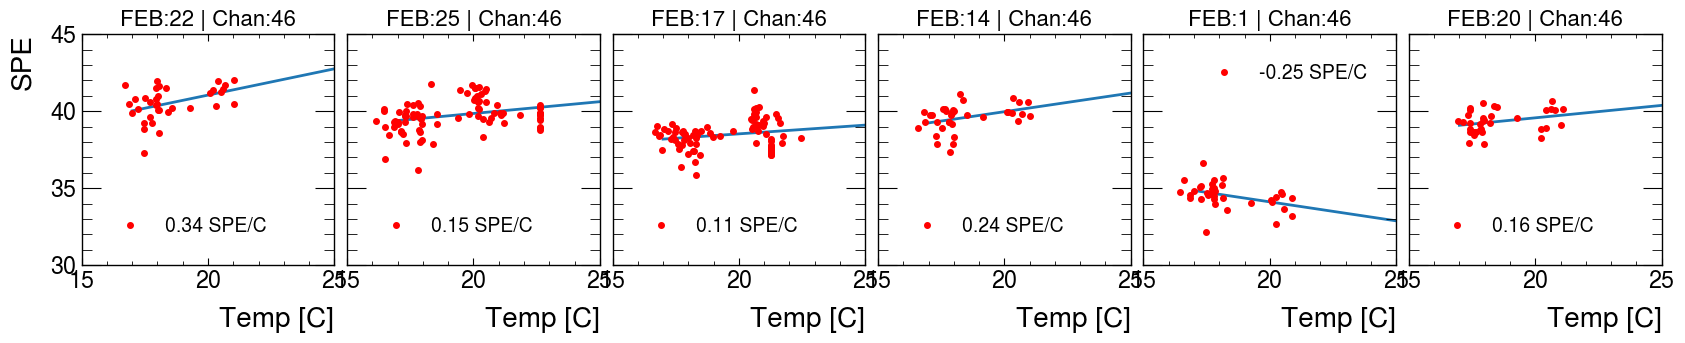

<Figure size 800x600 with 0 Axes>

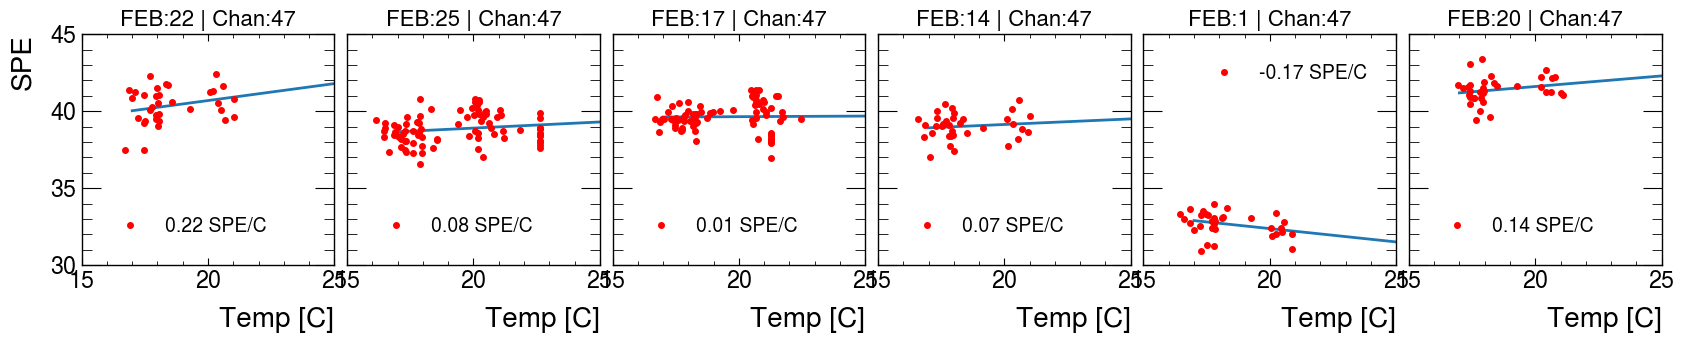

<Figure size 800x600 with 0 Axes>

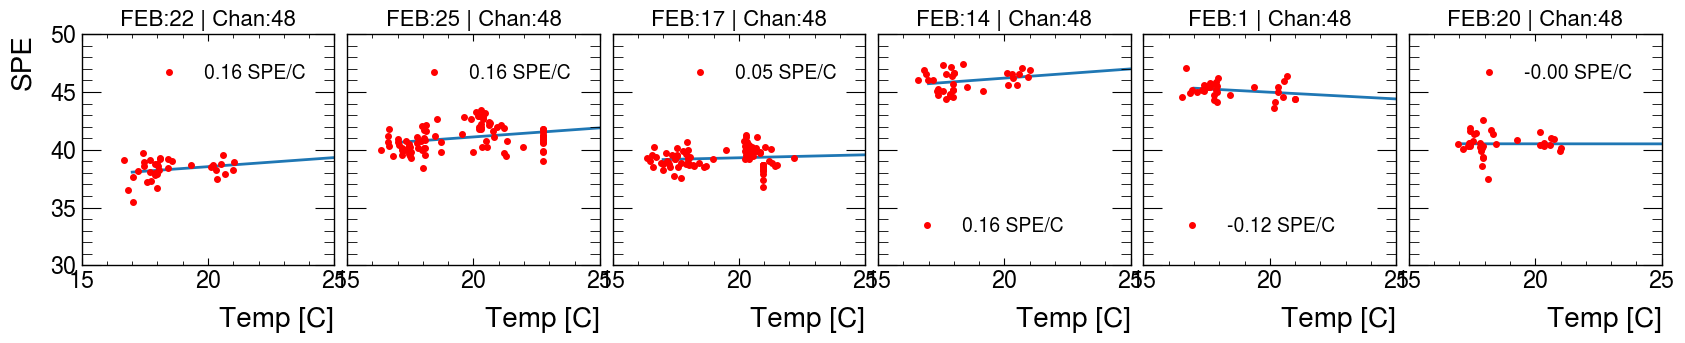

<Figure size 800x600 with 0 Axes>

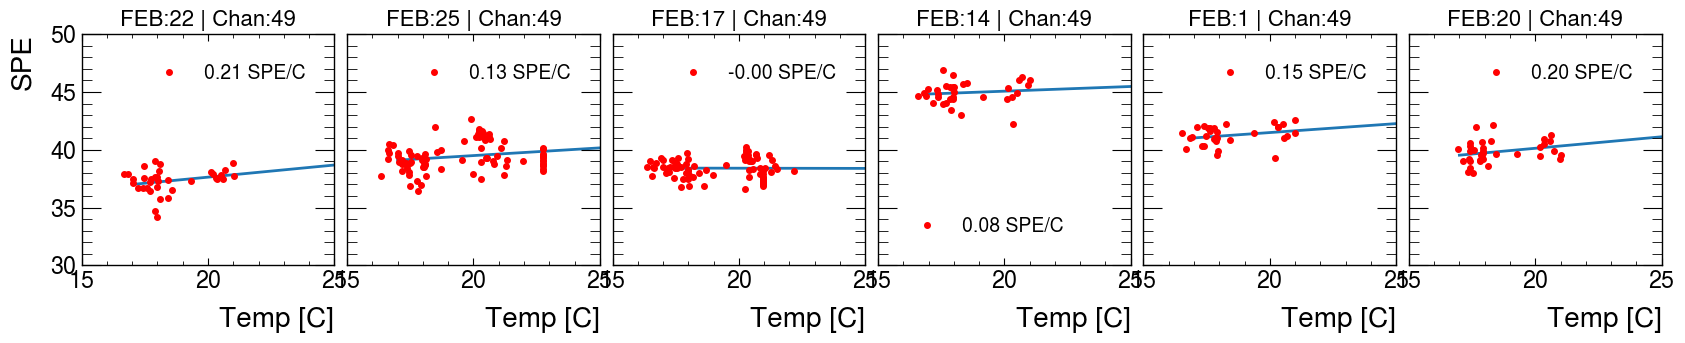

<Figure size 800x600 with 0 Axes>

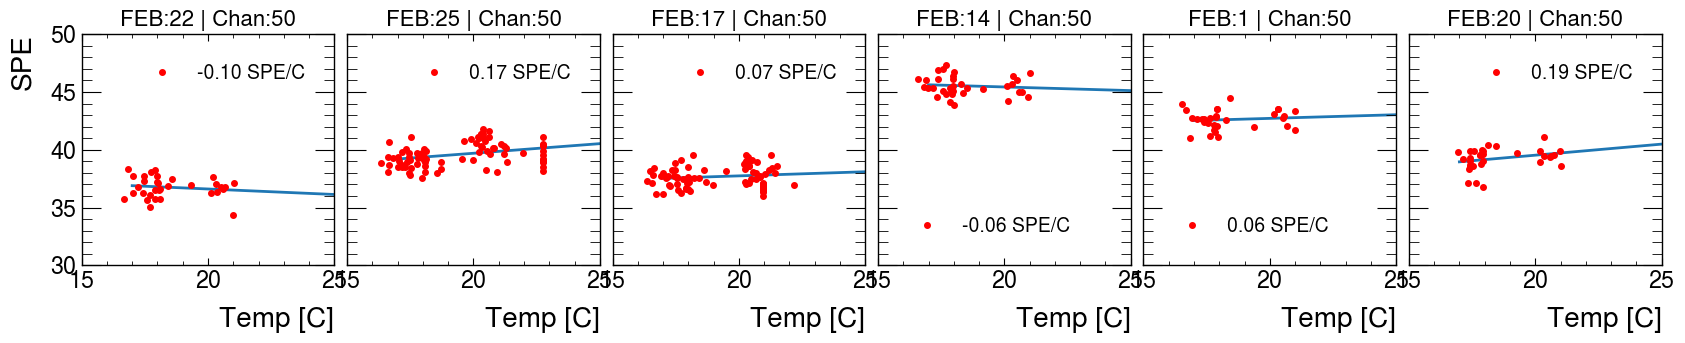

<Figure size 800x600 with 0 Axes>

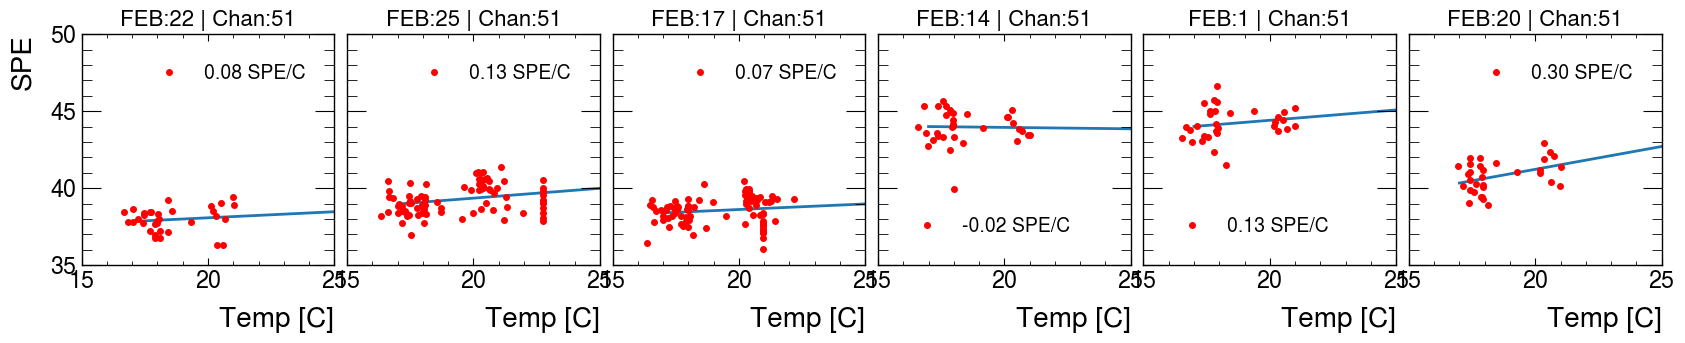

<Figure size 800x600 with 0 Axes>

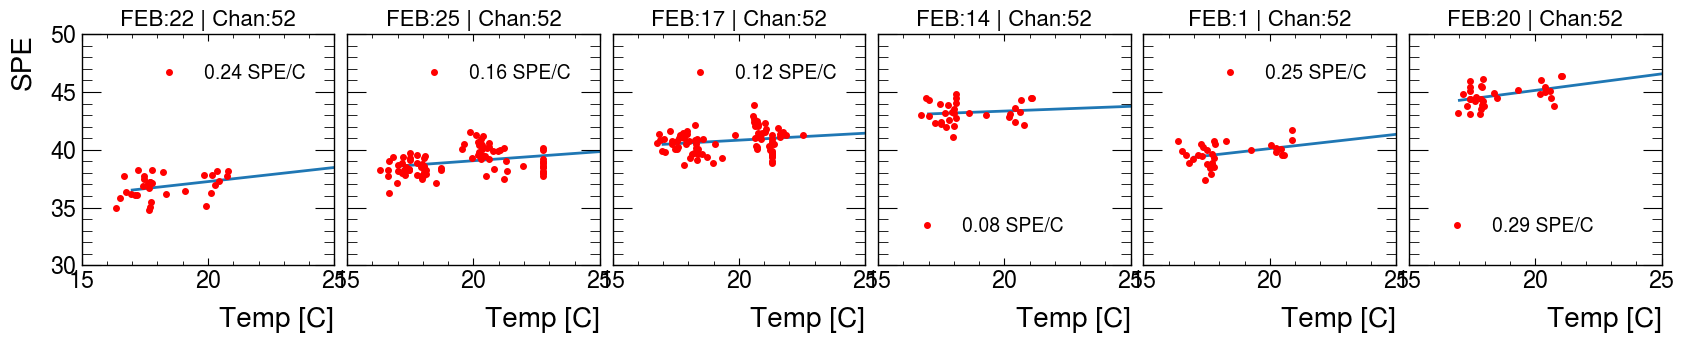

<Figure size 800x600 with 0 Axes>

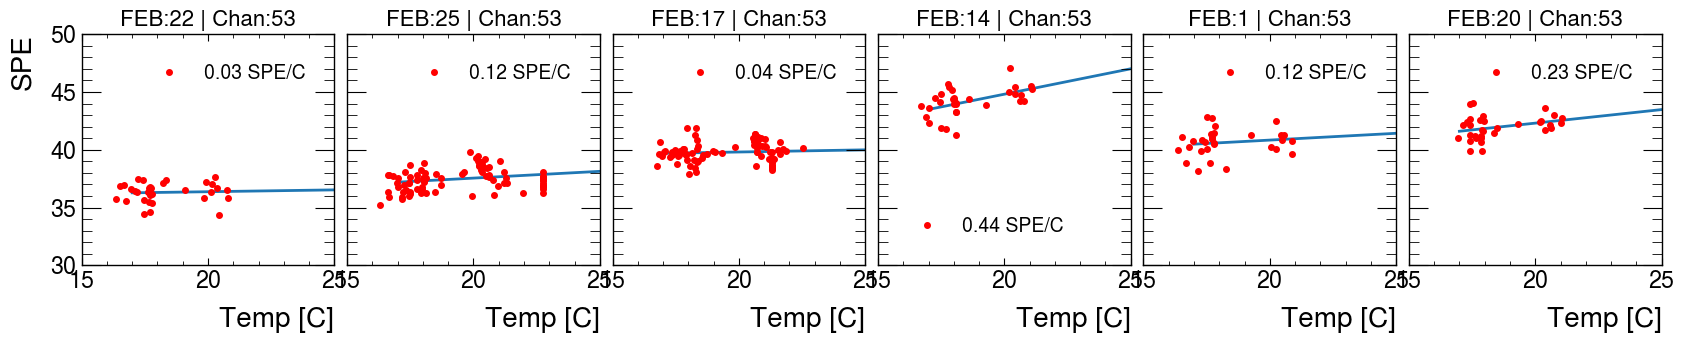

<Figure size 800x600 with 0 Axes>

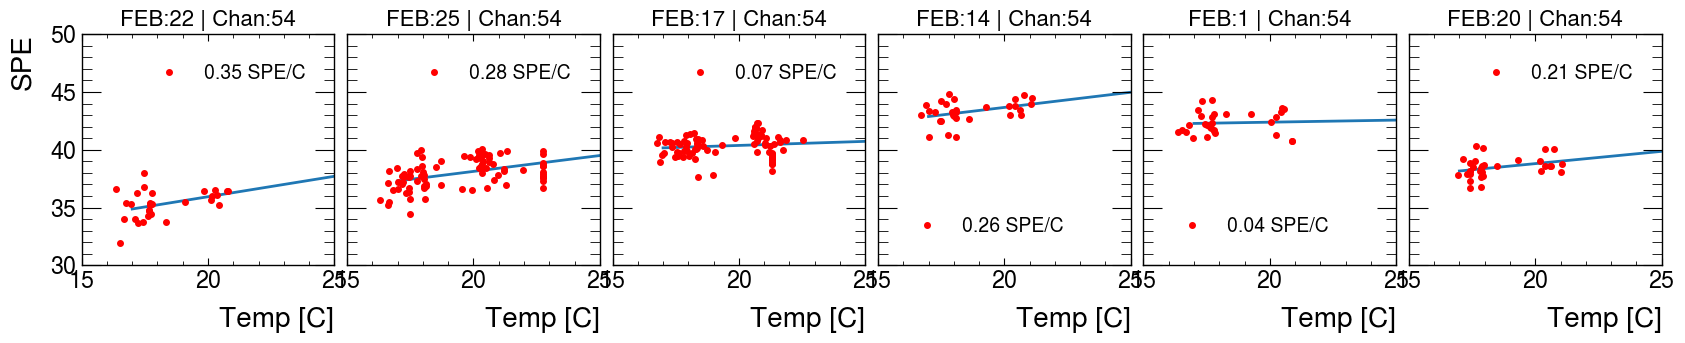

<Figure size 800x600 with 0 Axes>

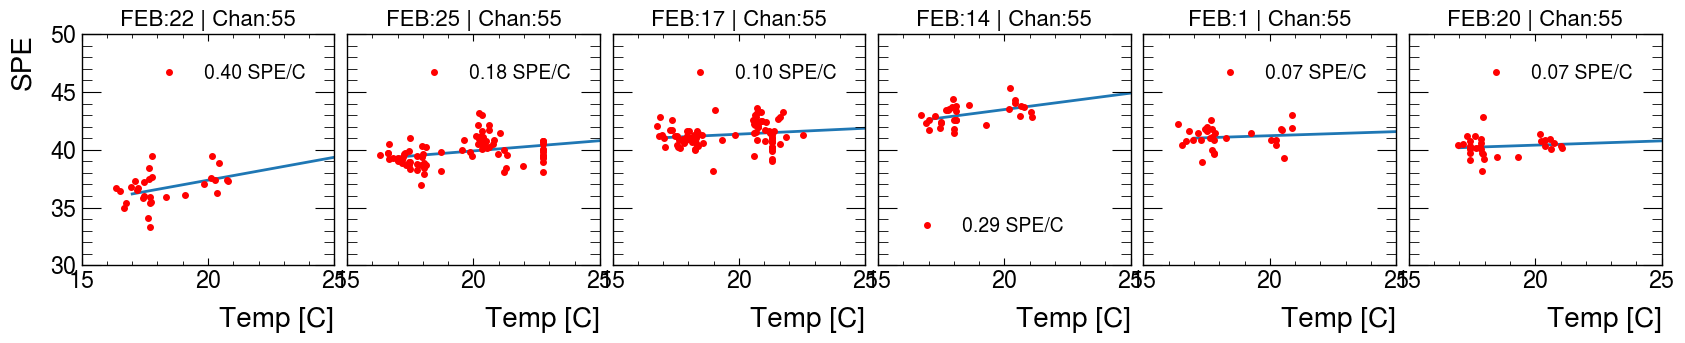

<Figure size 800x600 with 0 Axes>

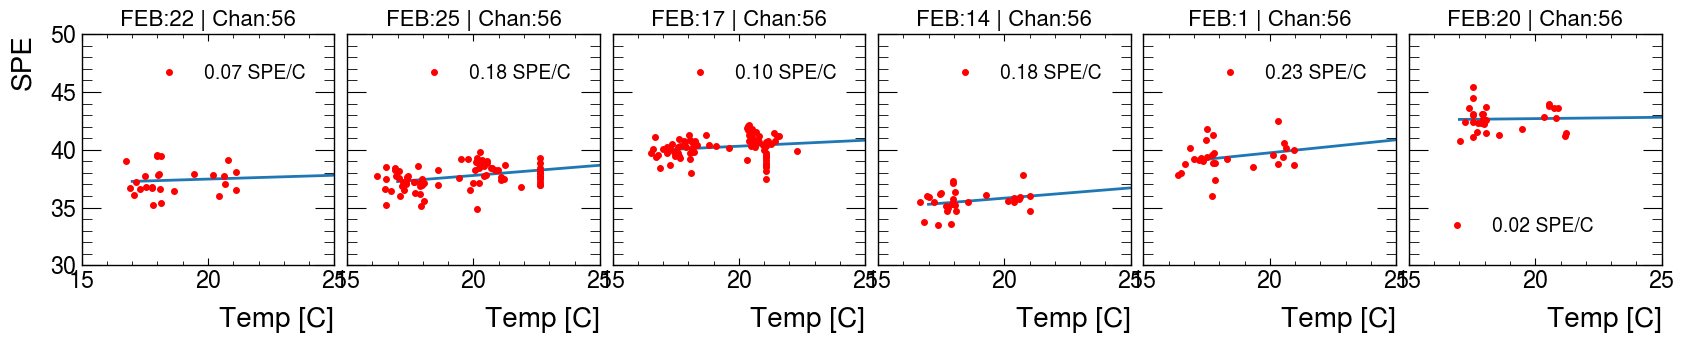

<Figure size 800x600 with 0 Axes>

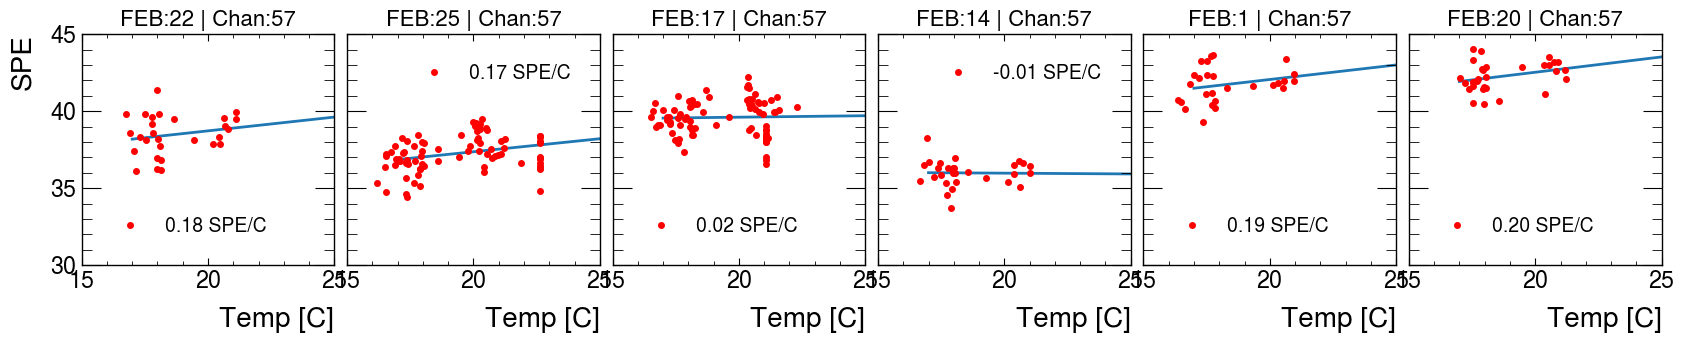

<Figure size 800x600 with 0 Axes>

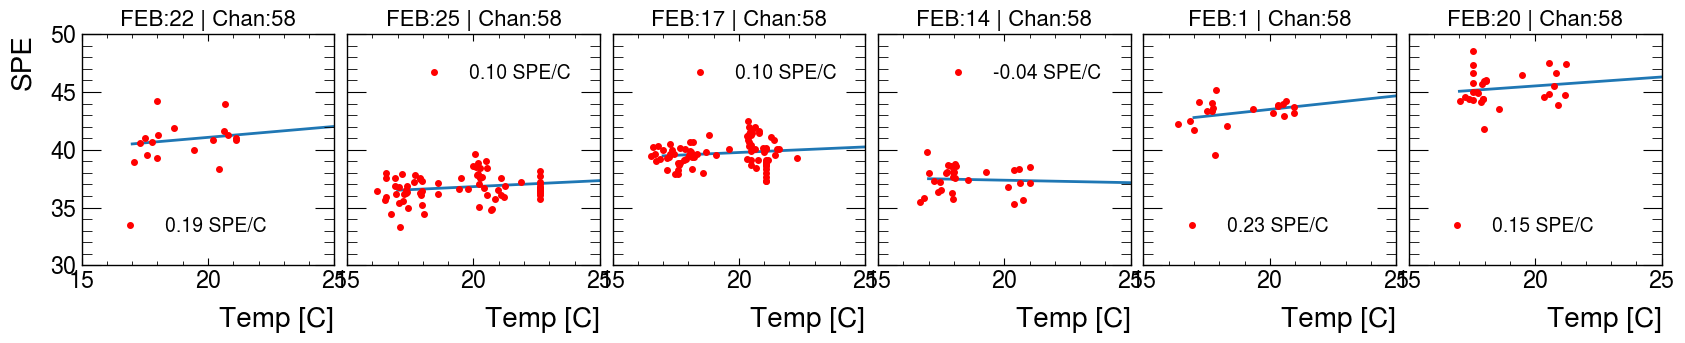

<Figure size 800x600 with 0 Axes>

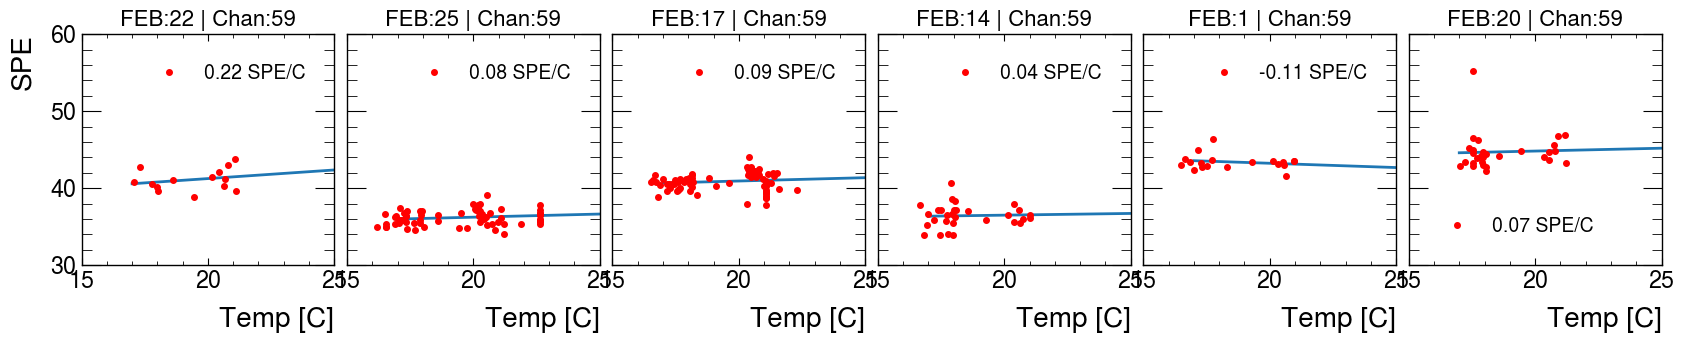

<Figure size 800x600 with 0 Axes>

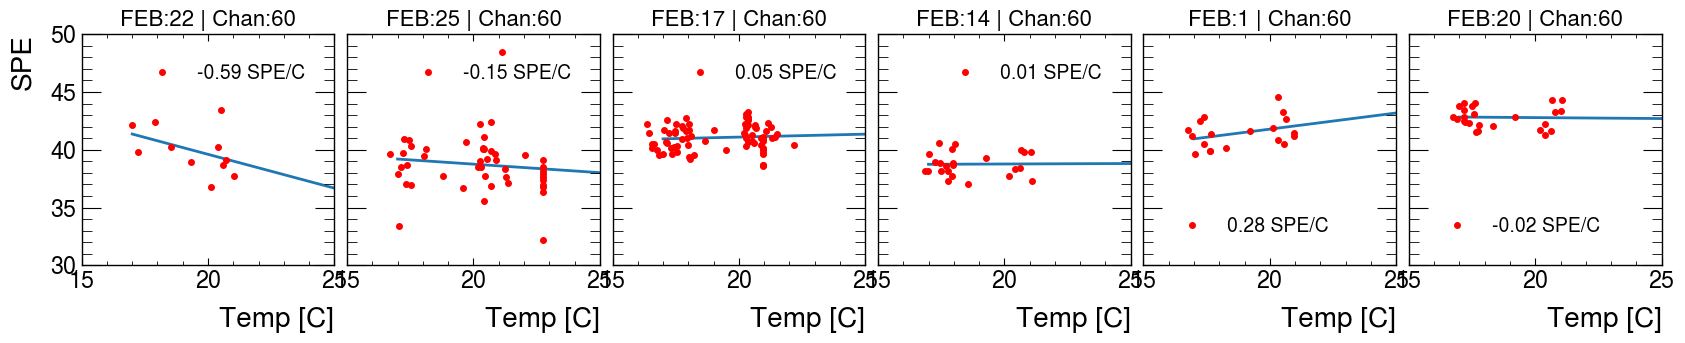

<Figure size 800x600 with 0 Axes>

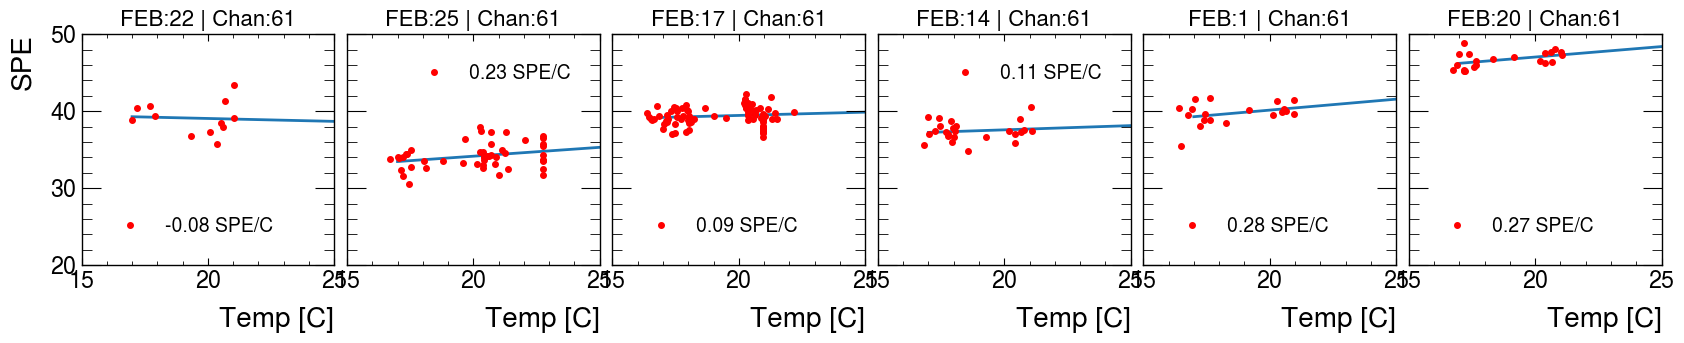

<Figure size 800x600 with 0 Axes>

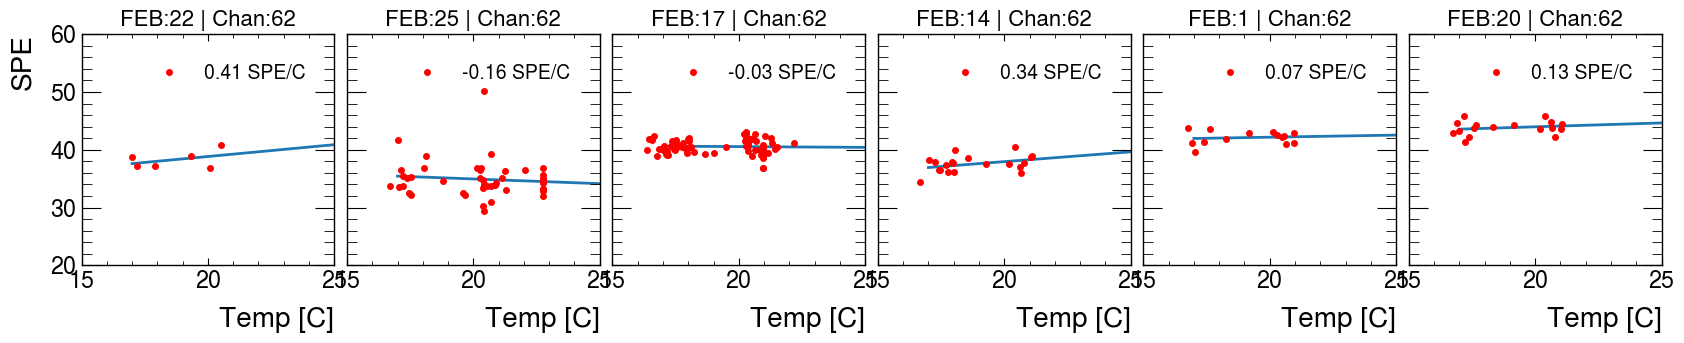

<Figure size 800x600 with 0 Axes>

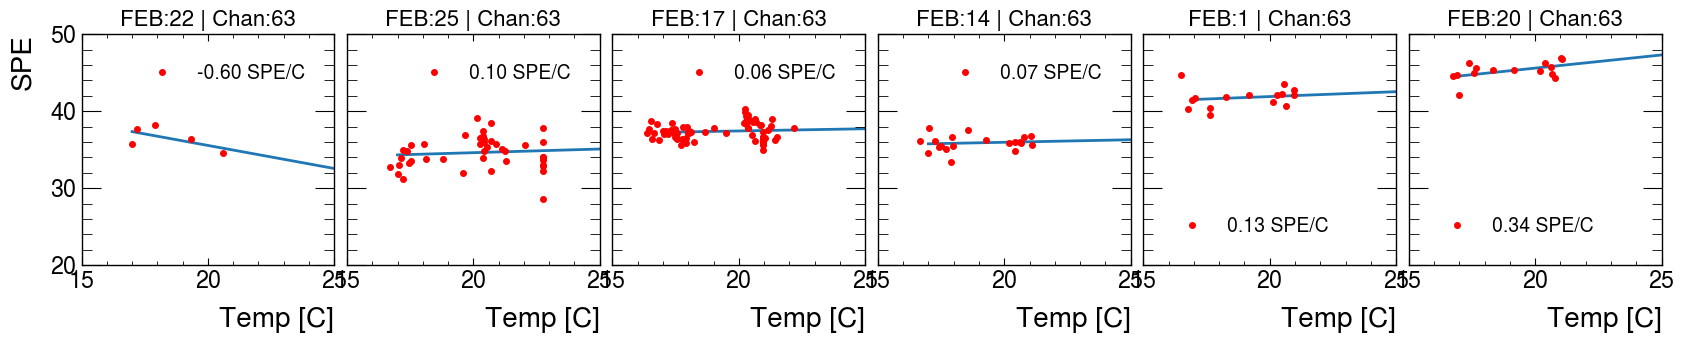

In [115]:
NFEB=6
spe_temp = -999*np.ones((NFEB,64))

for chan in range(0,64): # Loop thgough channels
  plt.figure()
  fig, ax1 = plt.subplots(nrows=1, ncols=6, figsize=(20, 3), sharey='row')
  plt.subplots_adjust(wspace=0.05)
  ax1[0].set_ylabel('SPE')

  for idx, feb in enumerate([22, 25, 17, 14, 1, 20]):
    cut = (ar['febID'] == feb)
    x=ar["meanTemperatures", cut]
#    y=ar["calibConstantsTemperatureCorrected", cut]
    y=ar["PEsTemperatureCorrected", cut]
       
    x=x[ak.num(x) > 0, 0].to_numpy()[:,chan] #Select runs that are only preent for this FEB
    y=y[ak.num(y) > 0, 0].to_numpy()[:,chan]
    x=x[y > 0] # Drop bad SPE points 
    y=y[y > 0] # Drop bad SPE points

    if len(x) == 0:
        continue
    
    linmodel = np.poly1d(np.polyfit(x, y, 1))
    xline = np.linspace(17, 25, 100)
    ax1[idx].plot(xline, linmodel(xline))
    ax1[idx].plot(x,y,'r.', label='%.2f SPE/C'%linmodel.coeffs[0])

    ax1[idx].set_xlabel('Temp [C]')
    
#    ax1[idx].set_xlim(40,65)
#    ax1[idx].set_ylim(53,55)
    ax1[idx].legend()
    ax1[idx].set_title('FEB:%d | Chan:%d'%(feb, chan), fontsize=16)
    spe_temp[idx][chan] = linmodel.coeffs[0]

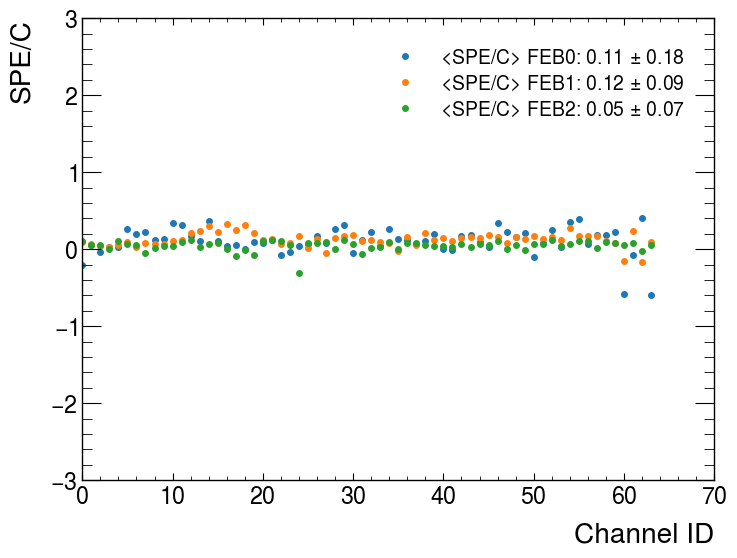

In [117]:
for feb in range(0, 3):
    arr_ = spe_temp[feb,:]
    plt.plot(arr_, '.', label='<SPE/C> FEB%d: %.2f $\pm$ %.2f'%(feb, arr_[~np.isnan(arr_)].mean(), arr_[~np.isnan(arr_)].std()   ))
    plt.legend()
    plt.xlabel('Channel ID')
    plt.ylabel('SPE/C')
#    plt.xlim(0,20)
    plt.ylim(-3,3)